Exploring directory structure...
Base directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets
Exists: True

Contents of base directory:
  cnn_conversion_metadata.json 
  test (dir)
  train (dir)
  val (dir)

test directory exists: True
  Found 150 .npy files
  Sample filenames:
    p_L_143750_rho_L_0.5625_test_input.npy
    p_L_143750_rho_L_0.5625_test_target.npy
    p_L_143750_rho_L_0.5_test_input.npy

val directory exists: True
  Found 50 .npy files
  Sample filenames:
    p_L_100000_rho_L_0.5625_val_input.npy
    p_L_100000_rho_L_0.5625_val_target.npy
    p_L_100000_rho_L_0.5_val_input.npy

train_cases_cnn directory exists: False

Searching for available files with pattern matching...

Found 75 files in test directory:
  [0] p_L=143750, rho_L=0.5625
  [1] p_L=143750, rho_L=0.5
  [2] p_L=143750, rho_L=0.625
  [3] p_L=143750, rho_L=0.6875
  [4] p_L=143750, rho_L=0.75
  ... and 70 more


Loaded file: p_L_143750_rho_L_0.

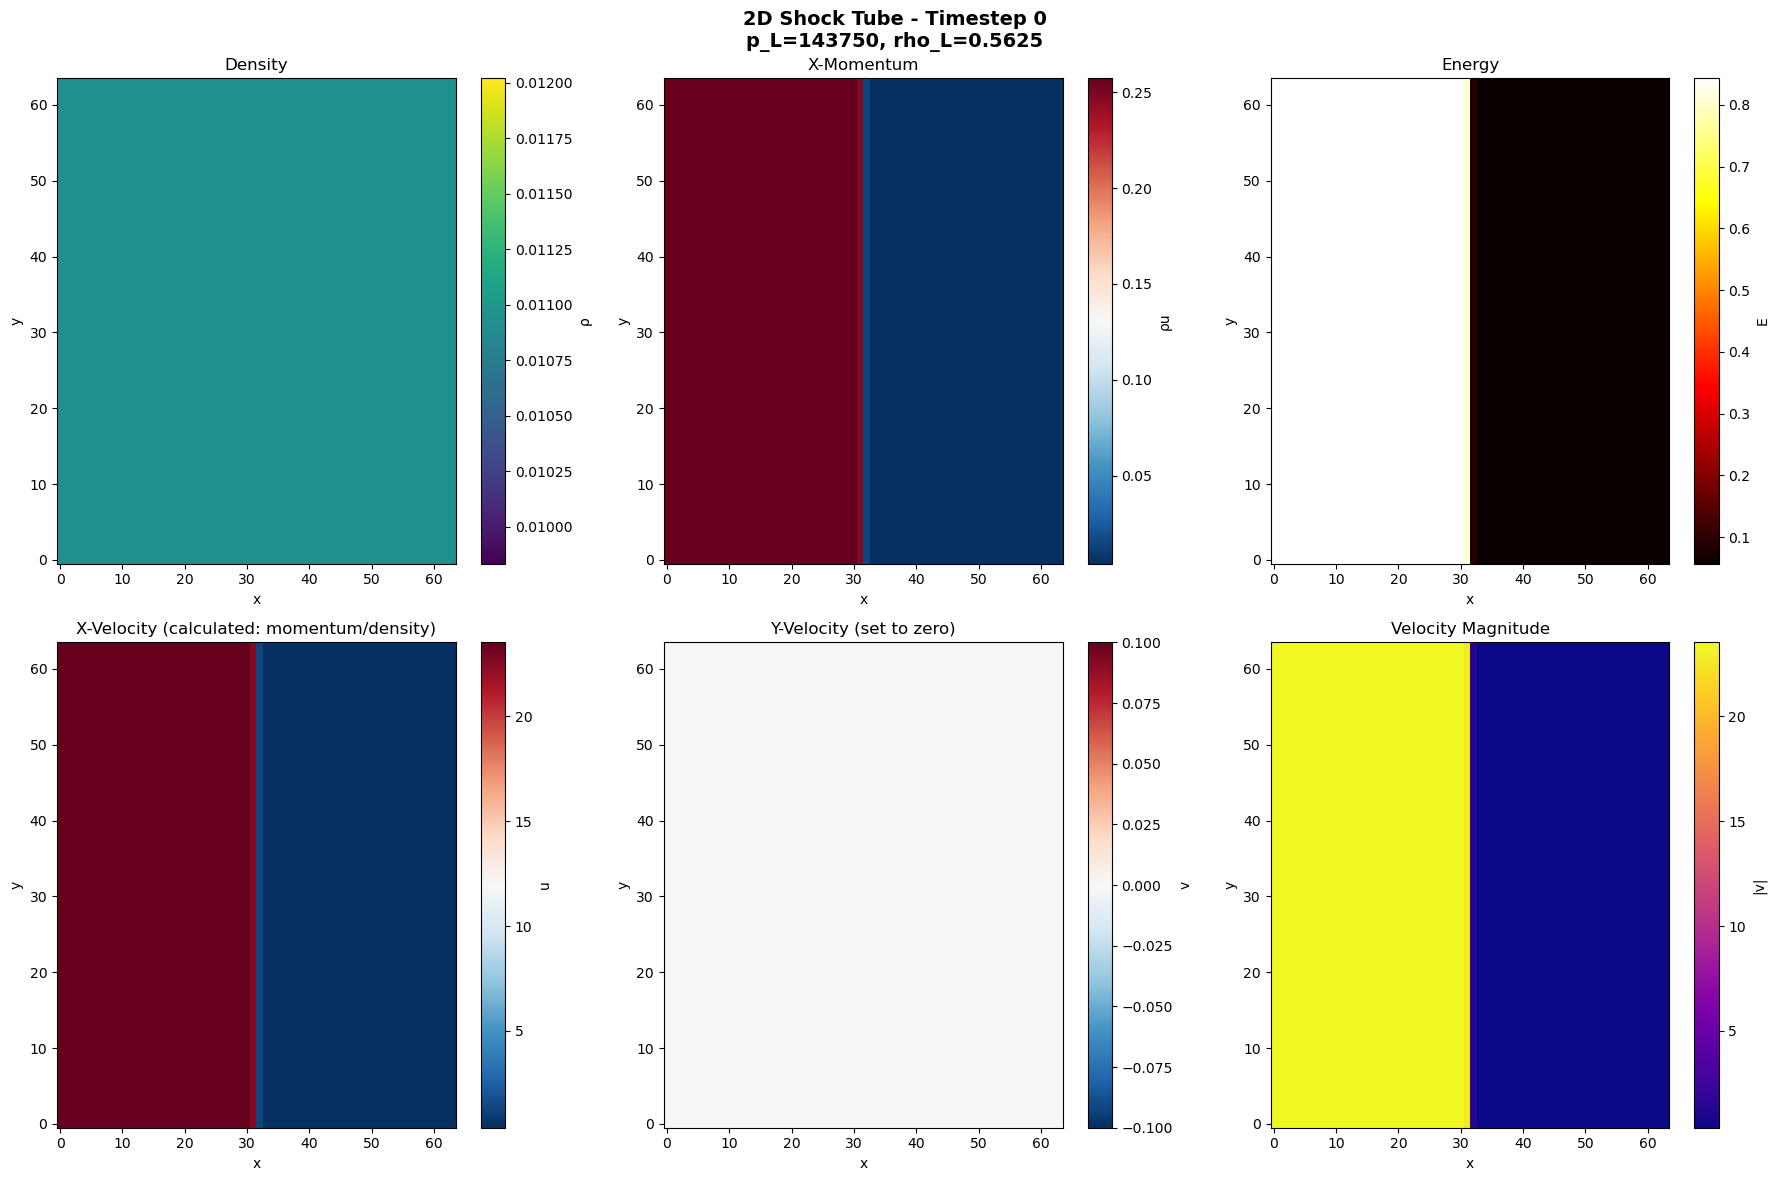

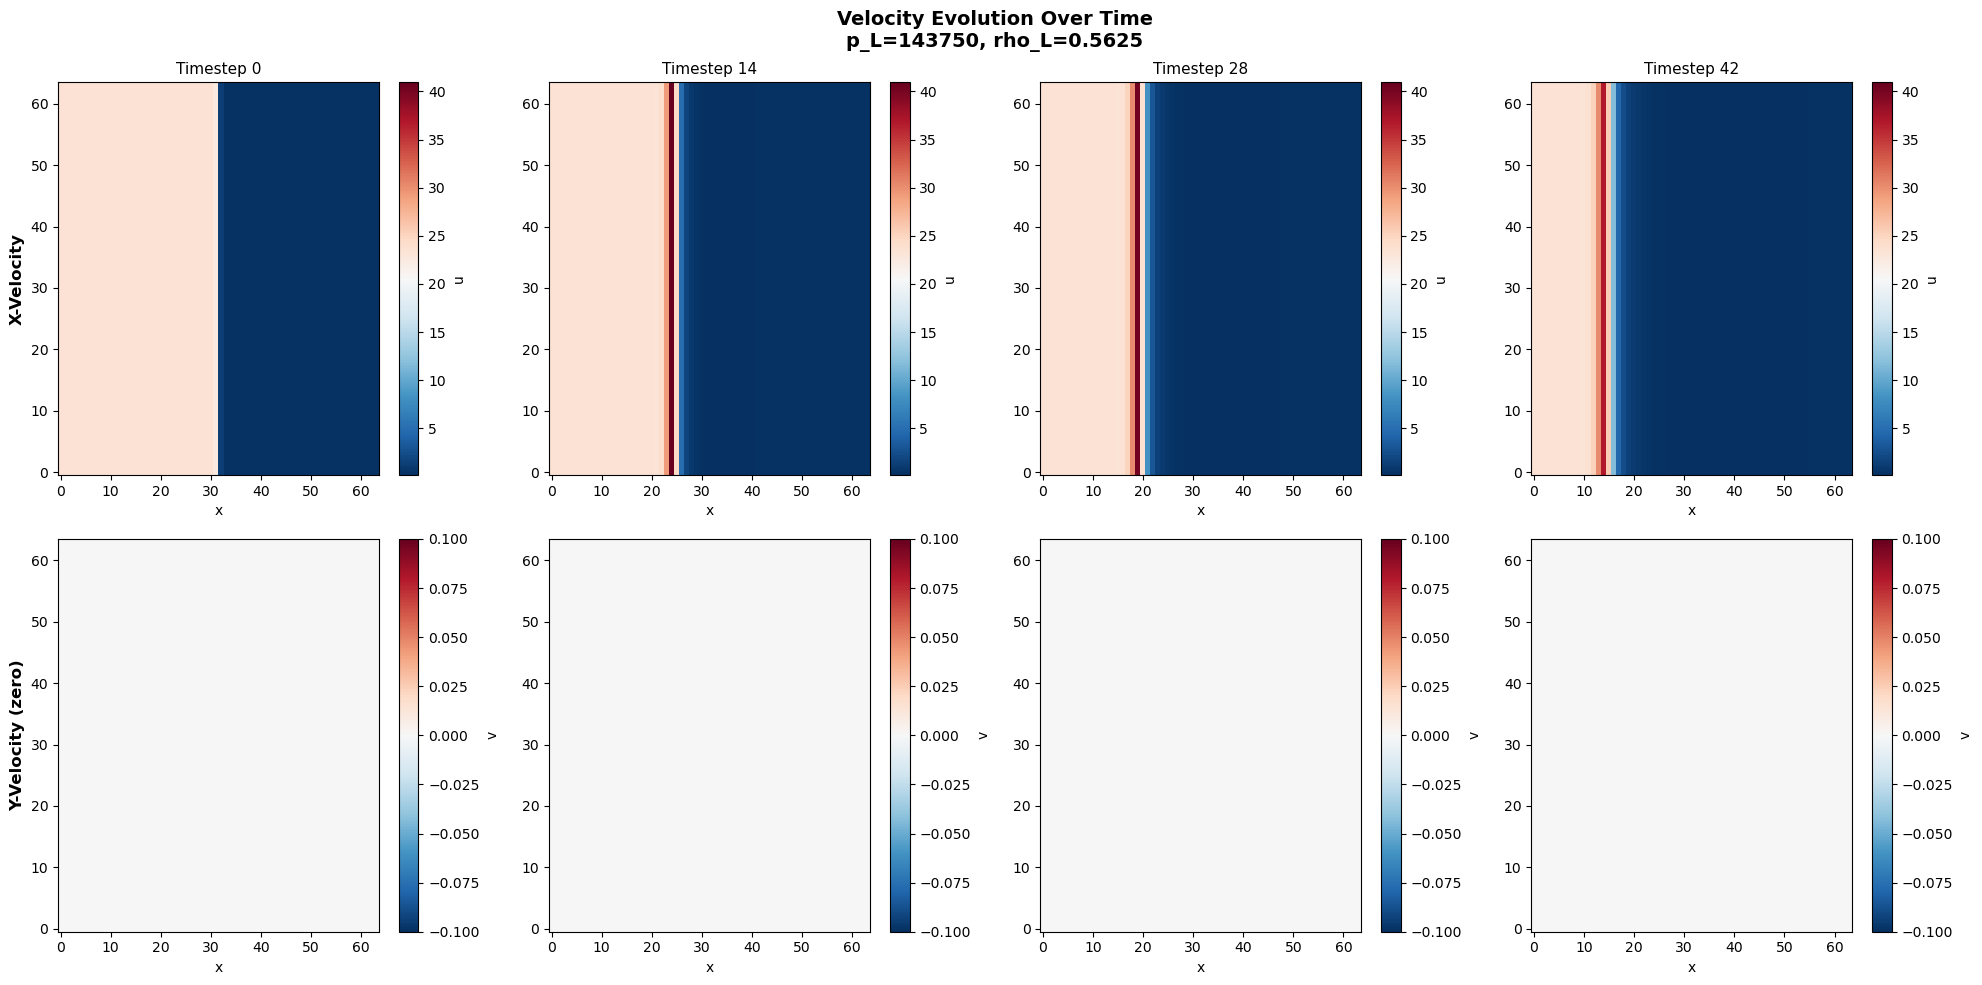

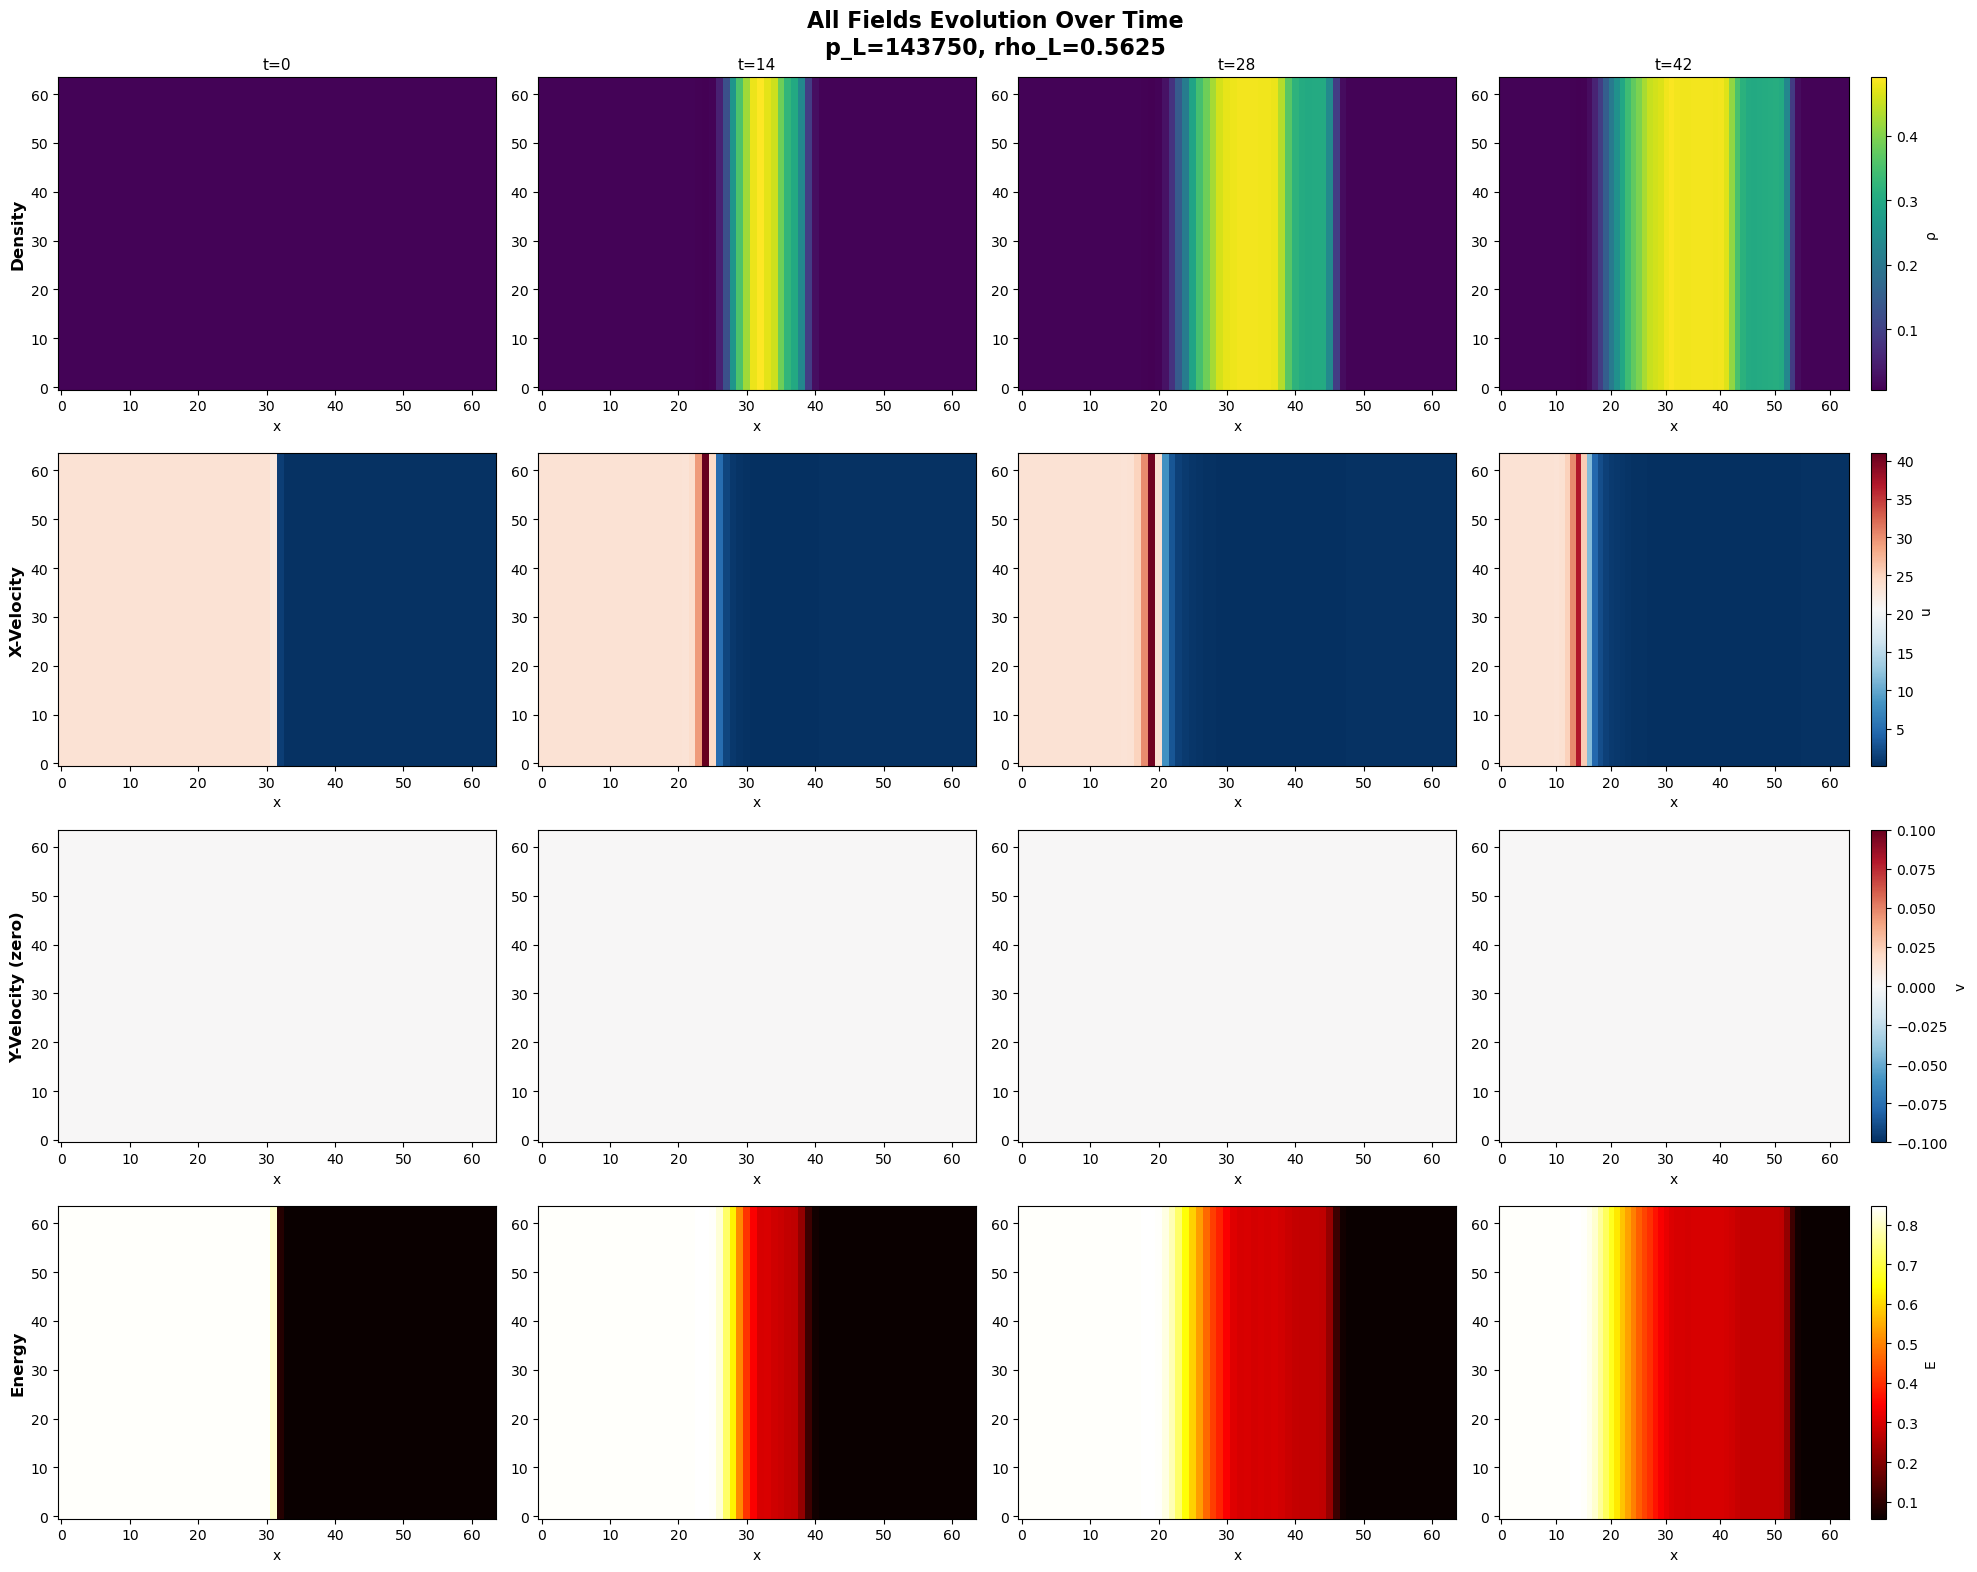

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import re

# Define the data directory
data_dir = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets")

def find_data_files(dataset='test'):
    """
    Find all data files in the specified dataset directory.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    
    Returns:
    --------
    list of tuples: (p_L, rho_L, input_file, target_file)
    """
    dataset_path = data_dir / dataset
    input_files = sorted(dataset_path.glob(f"*_{dataset}_input.npy"))
    
    file_info = []
    for input_file in input_files:
        # Parse filename: p_L_143750_rho_L_0.5625_test_input.npy
        match = re.search(r'p_L_([\d.]+)_rho_L_([\d.]+)', input_file.name)
        if match:
            p_L = match.group(1)
            rho_L = match.group(2)
            
            # Find corresponding target file
            target_file = input_file.parent / input_file.name.replace('_input.npy', '_target.npy')
            
            file_info.append({
                'p_L': p_L,
                'rho_L': rho_L,
                'input_file': input_file,
                'target_file': target_file if target_file.exists() else None
            })
    
    return file_info

def load_sample_data(dataset='test', file_idx=0):
    """
    Load a sample from the dataset.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    file_idx : int
        Index of the file to load from the list of available files
    
    Returns:
    --------
    dict containing data array, metadata, and file info
    """
    files = find_data_files(dataset)
    
    if not files:
        raise ValueError(f"No files found in {dataset} directory")
    
    if file_idx >= len(files):
        raise ValueError(f"File index {file_idx} out of range. Found {len(files)} files.")
    
    file_info = files[file_idx]
    
    # Load the data: shape is (timesteps, channels, height, width)
    data = np.load(file_info['input_file'])
    
    # Load target if available
    target = None
    if file_info['target_file'] and file_info['target_file'].exists():
        target = np.load(file_info['target_file'])
    
    print(f"\nLoaded file: {file_info['input_file'].name}")
    print(f"  p_L: {file_info['p_L']}")
    print(f"  rho_L: {file_info['rho_L']}")
    print(f"  Data shape: {data.shape} (timesteps, channels, height, width)")
    print(f"  Number of timesteps: {data.shape[0]}")
    print(f"  Number of channels: {data.shape[1]}")
    print(f"  Grid size: {data.shape[2]} x {data.shape[3]}")
    
    if target is not None:
        print(f"  Target shape: {target.shape}")
    
    return {
        'data': data,
        'target': target,
        'file_info': file_info,
        'files_available': files
    }

def extract_fields(data, timestep=0):
    """
    Extract individual fields from the data array.
    Assumes channels are ordered as: [x_momentum, density, energy]
    (y_momentum has been removed)
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    timestep : int
        Which timestep to extract
    
    Returns:
    --------
    dict with individual field arrays
    """
    x_momentum = data[timestep, 0, :, :]
    density = data[timestep, 1, :, :]
    energy = data[timestep, 2, :, :]
    
    # Calculate x-velocity
    x_velocity = calculate_velocity(x_momentum, density)
    
    # Set y-velocity to zero (1D shock tube problem)
    y_velocity = np.zeros_like(x_velocity)
    
    return {
        'x_momentum': x_momentum,
        'density': density,
        'energy': energy,
        'x_velocity': x_velocity,
        'y_velocity': y_velocity
    }

def calculate_velocity(x_momentum, density):
    """
    Calculate x-velocity from x-momentum and density.
    velocity = momentum / density
    
    Parameters:
    -----------
    x_momentum : numpy array
        x-component of momentum
    density : numpy array
        Density field
    
    Returns:
    --------
    x_velocity : numpy array
        x-component of velocity
    """
    # Avoid division by zero
    x_velocity = np.divide(x_momentum, density, 
                          where=density!=0, 
                          out=np.zeros_like(x_momentum))
    return x_velocity

def visualize_shock_tube(fields, timestep=0, file_info=None):
    """
    Visualize the 2D shock tube data.
    
    Parameters:
    -----------
    fields : dict
        Dictionary containing the field variables
    timestep : int
        Timestep index (for title)
    file_info : dict
        File information (for title)
    """
    # Create figure with subplots - now 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    title = f'2D Shock Tube - Timestep {timestep}'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Plot density
    im0 = axes[0, 0].imshow(fields['density'], cmap='viridis', aspect='auto', origin='lower')
    axes[0, 0].set_title('Density', fontsize=12)
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im0, ax=axes[0, 0], label='ρ')
    
    # Plot x-momentum
    im1 = axes[0, 1].imshow(fields['x_momentum'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[0, 1].set_title('X-Momentum', fontsize=12)
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 1], label='ρu')
    
    # Plot energy
    im2 = axes[0, 2].imshow(fields['energy'], cmap='hot', aspect='auto', origin='lower')
    axes[0, 2].set_title('Energy', fontsize=12)
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')
    plt.colorbar(im2, ax=axes[0, 2], label='E')
    
    # Plot x-velocity
    im3 = axes[1, 0].imshow(fields['x_velocity'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[1, 0].set_title('X-Velocity (calculated: momentum/density)', fontsize=12)
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im3, ax=axes[1, 0], label='u')
    
    # Plot y-velocity (all zeros)
    im4 = axes[1, 1].imshow(fields['y_velocity'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[1, 1].set_title('Y-Velocity (set to zero)', fontsize=12)
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    plt.colorbar(im4, ax=axes[1, 1], label='v')
    
    # Add velocity magnitude plot
    velocity_mag = np.sqrt(fields['x_velocity']**2 + fields['y_velocity']**2)
    im5 = axes[1, 2].imshow(velocity_mag, cmap='plasma', aspect='auto', origin='lower')
    axes[1, 2].set_title('Velocity Magnitude', fontsize=12)
    axes[1, 2].set_xlabel('x')
    axes[1, 2].set_ylabel('y')
    plt.colorbar(im5, ax=axes[1, 2], label='|v|')
    
    plt.tight_layout()
    return fig, fields['x_velocity'], fields['y_velocity']

def visualize_time_evolution(data, file_info=None, num_snapshots=4):
    """
    Visualize the time evolution of x-velocity and y-velocity.
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    file_info : dict
        File information
    num_snapshots : int
        Number of time snapshots to display
    """
    num_timesteps = data.shape[0]
    timestep_indices = np.linspace(0, num_timesteps-1, num_snapshots, dtype=int)
    
    fig, axes = plt.subplots(2, num_snapshots, figsize=(5*num_snapshots, 10))
    
    title = 'Velocity Evolution Over Time'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    vmin_x, vmax_x = None, None
    x_velocities = []
    y_velocities = []
    
    # Calculate velocities and find global min/max for consistent colorbar
    for idx in timestep_indices:
        fields = extract_fields(data, timestep=idx)
        x_velocities.append(fields['x_velocity'])
        y_velocities.append(fields['y_velocity'])
        
        if vmin_x is None:
            vmin_x, vmax_x = fields['x_velocity'].min(), fields['x_velocity'].max()
        else:
            vmin_x = min(vmin_x, fields['x_velocity'].min())
            vmax_x = max(vmax_x, fields['x_velocity'].max())
    
    # Plot all timesteps with consistent colorbar
    for i, (idx, x_vel, y_vel) in enumerate(zip(timestep_indices, x_velocities, y_velocities)):
        # X-velocity (top row)
        ax = axes[0, i] if num_snapshots > 1 else axes[0]
        im = ax.imshow(x_vel, cmap='RdBu_r', aspect='auto', origin='lower', vmin=vmin_x, vmax=vmax_x)
        ax.set_title(f'Timestep {idx}', fontsize=11)
        ax.set_xlabel('x')
        if i == 0:
            ax.set_ylabel('X-Velocity', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, label='u')
        
        # Y-velocity (bottom row) - all zeros
        ax = axes[1, i] if num_snapshots > 1 else axes[1]
        im = ax.imshow(y_vel, cmap='RdBu_r', aspect='auto', origin='lower', vmin=-0.1, vmax=0.1)
        ax.set_xlabel('x')
        if i == 0:
            ax.set_ylabel('Y-Velocity (zero)', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, label='v')
    
    plt.tight_layout()
    return fig

def visualize_all_fields_evolution(data, file_info=None, num_snapshots=4):
    """
    Visualize all fields (density, x-velocity, y-velocity, energy) at multiple timesteps.
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    file_info : dict
        File information
    num_snapshots : int
        Number of time snapshots to display
    """
    num_timesteps = data.shape[0]
    timestep_indices = np.linspace(0, num_timesteps-1, num_snapshots, dtype=int)
    
    # Create a figure with 4 rows (density, x-vel, y-vel, energy) and num_snapshots columns
    fig, axes = plt.subplots(4, num_snapshots, figsize=(5*num_snapshots, 16))
    
    title = 'All Fields Evolution Over Time'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Store min/max for consistent colorbars across timesteps for each field
    density_range = [None, None]
    x_velocity_range = [None, None]
    energy_range = [None, None]
    
    all_fields_data = []
    
    # First pass: calculate all fields and find global ranges
    for idx in timestep_indices:
        fields = extract_fields(data, timestep=idx)
        
        all_fields_data.append(fields)
        
        # Update ranges
        if density_range[0] is None:
            density_range = [fields['density'].min(), fields['density'].max()]
            x_velocity_range = [fields['x_velocity'].min(), fields['x_velocity'].max()]
            energy_range = [fields['energy'].min(), fields['energy'].max()]
        else:
            density_range[0] = min(density_range[0], fields['density'].min())
            density_range[1] = max(density_range[1], fields['density'].max())
            x_velocity_range[0] = min(x_velocity_range[0], fields['x_velocity'].min())
            x_velocity_range[1] = max(x_velocity_range[1], fields['x_velocity'].max())
            energy_range[0] = min(energy_range[0], fields['energy'].min())
            energy_range[1] = max(energy_range[1], fields['energy'].max())
    
    # Second pass: plot all fields
    for col, (idx, fields) in enumerate(zip(timestep_indices, all_fields_data)):
        # Row 0: Density
        ax = axes[0, col] if num_snapshots > 1 else axes[0]
        im0 = ax.imshow(fields['density'], cmap='viridis', aspect='auto', origin='lower',
                       vmin=density_range[0], vmax=density_range[1])
        ax.set_title(f't={idx}', fontsize=11)
        if col == 0:
            ax.set_ylabel('Density', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im0, ax=ax, label='ρ')
        
        # Row 1: X-Velocity
        ax = axes[1, col] if num_snapshots > 1 else axes[1]
        im1 = ax.imshow(fields['x_velocity'], cmap='RdBu_r', aspect='auto', origin='lower',
                       vmin=x_velocity_range[0], vmax=x_velocity_range[1])
        if col == 0:
            ax.set_ylabel('X-Velocity', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im1, ax=ax, label='u')
        
        # Row 2: Y-Velocity (all zeros)
        ax = axes[2, col] if num_snapshots > 1 else axes[2]
        im2 = ax.imshow(fields['y_velocity'], cmap='RdBu_r', aspect='auto', origin='lower',
                       vmin=-0.1, vmax=0.1)
        if col == 0:
            ax.set_ylabel('Y-Velocity (zero)', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im2, ax=ax, label='v')
        
        # Row 3: Energy
        ax = axes[3, col] if num_snapshots > 1 else axes[3]
        im3 = ax.imshow(fields['energy'], cmap='hot', aspect='auto', origin='lower',
                       vmin=energy_range[0], vmax=energy_range[1])
        if col == 0:
            ax.set_ylabel('Energy', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im3, ax=ax, label='E')
    
    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # First, let's explore what's actually in the directory
    print("Exploring directory structure...")
    print(f"Base directory: {data_dir}")
    print(f"Exists: {data_dir.exists()}")
    
    if data_dir.exists():
        print("\nContents of base directory:")
        for item in sorted(data_dir.iterdir()):
            print(f"  {item.name} {'(dir)' if item.is_dir() else ''}")
        
        # Check each subdirectory
        for subdir in ['test', 'val', 'train_cases_cnn']:
            subdir_path = data_dir / subdir
            print(f"\n{subdir} directory exists: {subdir_path.exists()}")
            if subdir_path.exists():
                files_list = list(subdir_path.glob("*.npy"))
                print(f"  Found {len(files_list)} .npy files")
                if files_list:
                    print(f"  Sample filenames:")
                    for f in sorted(files_list)[:3]:
                        print(f"    {f.name}")
    
    print("\n" + "="*60)
    
    # List available files
    print("Searching for available files with pattern matching...")
    files = find_data_files(dataset='test')
    print(f"\nFound {len(files)} files in test directory:")
    for i, f in enumerate(files[:5]):  # Show first 5
        print(f"  [{i}] p_L={f['p_L']}, rho_L={f['rho_L']}")
    if len(files) > 5:
        print(f"  ... and {len(files)-5} more")
    
    if not files:
        print("\nNo files found! Please check:")
        print("1. The directory path is correct")
        print("2. The dataset name ('test', 'val', or 'train_cases_cnn')")
        print("3. The file naming pattern")
        import sys
        sys.exit(0)
    
    # Load a sample
    print("\n" + "="*60)
    sample_data = load_sample_data(dataset='test', file_idx=0)
    
    # Extract fields from first timestep
    print("\n" + "="*60)
    print("Extracting fields from timestep 0...")
    fields = extract_fields(sample_data['data'], timestep=0)
    
    print(f"\nField shapes:")
    for key, value in fields.items():
        print(f"  {key}: {value.shape}")
    
    # Calculate velocity statistics
    x_velocity = calculate_velocity(fields['x_momentum'], fields['density'])
    print(f"\nX-Velocity statistics (timestep 0):")
    print(f"  Min: {x_velocity.min():.6f}")
    print(f"  Max: {x_velocity.max():.6f}")
    print(f"  Mean: {x_velocity.mean():.6f}")
    print(f"  Std: {x_velocity.std():.6f}")
    
    # Visualize single timestep
    print("\nGenerating single timestep visualization...")
    fig1, x_vel, y_vel = visualize_shock_tube(fields, timestep=0, 
                                   file_info=sample_data['file_info'])
    
    # Visualize time evolution - velocity only
    print("Generating time evolution visualization...")
    fig2 = visualize_time_evolution(sample_data['data'], 
                                    file_info=sample_data['file_info'],
                                    num_snapshots=4)
    
    # Visualize all fields at multiple timesteps
    print("Generating multi-timestep all-fields visualization...")
    fig3 = visualize_all_fields_evolution(sample_data['data'],
                                          file_info=sample_data['file_info'],
                                          num_snapshots=4)
    
    plt.show()
    
    # Optional: Save figures
    # fig1.savefig('shock_tube_single_timestep.png', dpi=300, bbox_inches='tight')
    # fig2.savefig('shock_tube_time_evolution.png', dpi=300, bbox_inches='tight')

In [1]:
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Define the data directory
data_dir = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets")

def calculate_velocity(x_momentum, density):
    """
    Calculate x-velocity from x-momentum and density.
    velocity = momentum / density
    
    Parameters:
    -----------
    x_momentum : numpy array
        x-component of momentum
    density : numpy array
        Density field
    
    Returns:
    --------
    x_velocity : numpy array
        x-component of velocity
    """
    # Avoid division by zero
    x_velocity = np.divide(x_momentum, density, 
                          where=density!=0, 
                          out=np.zeros_like(x_momentum))
    return x_velocity

def process_file(input_file, output_file, file_type='input'):
    """
    Process a single file and add velocity channels.
    
    Parameters:
    -----------
    input_file : Path
        Path to input .npy file
    output_file : Path
        Path to output .npy file
    file_type : str
        'input' or 'target' for logging purposes
    
    Returns:
    --------
    dict with processing info
    """
    # Load the data: shape is (timesteps, channels, height, width)
    # Current channels: [x_momentum, density, energy]
    data = np.load(input_file)
    
    num_timesteps, num_channels, height, width = data.shape
    
    # Create new array with 5 channels: [x_momentum, density, energy, x_velocity, y_velocity]
    new_data = np.zeros((num_timesteps, 5, height, width), dtype=data.dtype)
    
    # Copy original channels
    new_data[:, 0, :, :] = data[:, 0, :, :]  # x_momentum
    new_data[:, 1, :, :] = data[:, 1, :, :]  # density
    new_data[:, 2, :, :] = data[:, 2, :, :]  # energy
    
    # Calculate and add velocity channels for each timestep
    for t in range(num_timesteps):
        x_momentum = data[t, 0, :, :]
        density = data[t, 1, :, :]
        
        # Calculate x-velocity
        x_velocity = calculate_velocity(x_momentum, density)
        
        # Set y-velocity to zero (1D shock tube)
        y_velocity = np.zeros_like(x_velocity)
        
        # Add velocity channels
        new_data[t, 3, :, :] = x_velocity  # x_velocity
        new_data[t, 4, :, :] = y_velocity  # y_velocity (zeros)
    
    # Save the new data
    np.save(output_file, new_data)
    
    return {
        'original_shape': data.shape,
        'new_shape': new_data.shape,
        'file': input_file.name
    }

def process_dataset(dataset='test', backup=True, dry_run=False):
    """
    Process all files in a dataset directory.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    backup : bool
        If True, create backup of original files
    dry_run : bool
        If True, only show what would be done without actually doing it
    
    Returns:
    --------
    dict with processing statistics
    """
    dataset_path = data_dir / dataset
    
    # Find all .npy files
    all_files = sorted(dataset_path.glob("*.npy"))
    
    print(f"\n{'='*60}")
    print(f"Processing {dataset} dataset")
    print(f"{'='*60}")
    print(f"Found {len(all_files)} .npy files")
    
    if dry_run:
        print("\n*** DRY RUN MODE - No files will be modified ***\n")
    
    # Create backup directory if needed
    if backup and not dry_run:
        backup_dir = dataset_path / "backup_original"
        backup_dir.mkdir(exist_ok=True)
        print(f"Backup directory: {backup_dir}")
    
    stats = {
        'total_files': len(all_files),
        'processed': 0,
        'errors': 0,
        'total_size_original': 0,
        'total_size_new': 0
    }
    
    # Process each file
    for file_path in tqdm(all_files, desc=f"Processing {dataset}"):
        try:
            if dry_run:
                # Just load to check
                data = np.load(file_path)
                print(f"Would process: {file_path.name} - Shape: {data.shape} -> {(data.shape[0], 5, data.shape[2], data.shape[3])}")
                stats['processed'] += 1
            else:
                # Create backup
                if backup:
                    backup_file = backup_dir / file_path.name
                    if not backup_file.exists():
                        np.save(backup_file, np.load(file_path))
                
                # Create temporary output file
                temp_output = file_path.parent / f"{file_path.stem}_temp.npy"
                
                # Determine file type
                file_type = 'input' if '_input' in file_path.name else 'target'
                
                # Process the file
                info = process_file(file_path, temp_output, file_type)
                
                # Get file sizes
                original_size = file_path.stat().st_size
                new_size = temp_output.stat().st_size
                
                stats['total_size_original'] += original_size
                stats['total_size_new'] += new_size
                
                # Replace original with new file
                temp_output.replace(file_path)
                
                stats['processed'] += 1
                
        except Exception as e:
            print(f"\nError processing {file_path.name}: {str(e)}")
            stats['errors'] += 1
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Summary for {dataset} dataset:")
    print(f"{'='*60}")
    print(f"Total files: {stats['total_files']}")
    print(f"Successfully processed: {stats['processed']}")
    print(f"Errors: {stats['errors']}")
    
    if not dry_run:
        print(f"Original total size: {stats['total_size_original'] / 1e6:.2f} MB")
        print(f"New total size: {stats['total_size_new'] / 1e6:.2f} MB")
        print(f"Size increase: {(stats['total_size_new'] - stats['total_size_original']) / 1e6:.2f} MB")
        print(f"Size ratio: {stats['total_size_new'] / stats['total_size_original']:.2f}x")
    
    return stats

def verify_processed_file(file_path):
    """
    Verify that a processed file has the correct structure.
    
    Parameters:
    -----------
    file_path : Path
        Path to the processed file
    
    Returns:
    --------
    bool indicating if file is valid
    """
    try:
        data = np.load(file_path)
        
        # Check shape
        if len(data.shape) != 4:
            print(f"❌ {file_path.name}: Wrong number of dimensions")
            return False
        
        if data.shape[1] != 5:
            print(f"❌ {file_path.name}: Wrong number of channels (expected 5, got {data.shape[1]})")
            return False
        
        # Check that y-velocity (channel 4) is all zeros
        if not np.allclose(data[:, 4, :, :], 0):
            print(f"❌ {file_path.name}: Y-velocity channel is not all zeros")
            return False
        
        # Check that channels 0-2 match the relationship with channel 3
        # x_velocity should equal x_momentum / density (where density != 0)
        for t in range(min(3, data.shape[0])):  # Check first 3 timesteps
            x_momentum = data[t, 0, :, :]
            density = data[t, 1, :, :]
            x_velocity = data[t, 3, :, :]
            
            expected_velocity = calculate_velocity(x_momentum, density)
            
            if not np.allclose(x_velocity, expected_velocity, rtol=1e-5):
                print(f"❌ {file_path.name}: X-velocity doesn't match momentum/density at timestep {t}")
                return False
        
        print(f"✅ {file_path.name}: Valid")
        return True
        
    except Exception as e:
        print(f"❌ {file_path.name}: Error during verification - {str(e)}")
        return False

def verify_dataset(dataset='test', num_samples=5):
    """
    Verify a sample of processed files.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    num_samples : int
        Number of files to verify
    """
    dataset_path = data_dir / dataset
    all_files = sorted(dataset_path.glob("*.npy"))
    
    print(f"\n{'='*60}")
    print(f"Verifying {dataset} dataset (sampling {num_samples} files)")
    print(f"{'='*60}\n")
    
    # Sample files evenly
    if len(all_files) <= num_samples:
        sample_files = all_files
    else:
        indices = np.linspace(0, len(all_files)-1, num_samples, dtype=int)
        sample_files = [all_files[i] for i in indices]
    
    valid_count = 0
    for file_path in sample_files:
        if verify_processed_file(file_path):
            valid_count += 1
    
    print(f"\nVerification complete: {valid_count}/{len(sample_files)} files valid")
    return valid_count == len(sample_files)

# Main execution
if __name__ == "__main__":
    print("="*60)
    print("Dataset Rewriting Tool: Add Velocity Channels")
    print("="*60)
    print("\nThis will add x-velocity and y-velocity as channels 4 and 5")
    print("Current channels: [x_momentum, density, energy]")
    print("New channels: [x_momentum, density, energy, x_velocity, y_velocity]")
    print("\nDatasets to process: train, test, val")
    
    # Ask for confirmation
    response = input("\nDo you want to run a DRY RUN first to see what will happen? (y/n): ")
    
    if response.lower() == 'y':
        print("\n" + "="*60)
        print("Running DRY RUN (no files will be modified)")
        print("="*60)
        
        for dataset in ['test', 'val', 'train']:
            process_dataset(dataset, backup=True, dry_run=True)
        
        print("\n" + "="*60)
        print("Dry run complete!")
        print("="*60)
        
        response = input("\nProceed with actual processing? (y/n): ")
        if response.lower() != 'y':
            print("Aborted.")
            import sys
            sys.exit(0)
    
    # Process all datasets
    print("\n" + "="*60)
    print("PROCESSING FILES (with backup)")
    print("="*60)
    
    all_stats = {}
    for dataset in ['test', 'val', 'train']:
        stats = process_dataset(dataset, backup=True, dry_run=False)
        all_stats[dataset] = stats
    
    # Verify the processed files
    print("\n" + "="*60)
    print("VERIFYING PROCESSED FILES")
    print("="*60)
    
    for dataset in ['test', 'val', 'train']:
        verify_dataset(dataset, num_samples=5)
    
    # Final summary
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    total_processed = sum(s['processed'] for s in all_stats.values())
    total_errors = sum(s['errors'] for s in all_stats.values())
    print(f"Total files processed: {total_processed}")
    print(f"Total errors: {total_errors}")
    print("\n✅ All files have been rewritten with velocity channels!")
    print("Original files backed up in 'backup_original' folder in each dataset directory.")

Dataset Rewriting Tool: Add Velocity Channels

This will add x-velocity and y-velocity as channels 4 and 5
Current channels: [x_momentum, density, energy]
New channels: [x_momentum, density, energy, x_velocity, y_velocity]

Datasets to process: train, test, val



Do you want to run a DRY RUN first to see what will happen? (y/n):  y



Running DRY RUN (no files will be modified)

Processing test dataset
Found 150 .npy files

*** DRY RUN MODE - No files will be modified ***



Processing test:   2%|▏         | 3/150 [00:00<00:06, 23.50it/s]

Would process: p_L_143750_rho_L_0.5625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.5625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.5_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.5_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:   4%|▍         | 6/150 [00:00<00:07, 19.37it/s]

Would process: p_L_143750_rho_L_0.625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:   5%|▌         | 8/150 [00:00<00:08, 17.19it/s]

Would process: p_L_143750_rho_L_0.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:   7%|▋         | 10/150 [00:00<00:08, 16.75it/s]

Would process: p_L_143750_rho_L_0.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:   9%|▉         | 14/150 [00:00<00:09, 13.62it/s]

Would process: p_L_143750_rho_L_0.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  12%|█▏        | 18/150 [00:01<00:09, 14.52it/s]

Would process: p_L_143750_rho_L_1.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  15%|█▌        | 23/150 [00:01<00:07, 17.23it/s]

Would process: p_L_143750_rho_L_1.875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.9375_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.9375_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_2.0_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  17%|█▋        | 26/150 [00:01<00:07, 17.69it/s]

Would process: p_L_143750_rho_L_2.0_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.5625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.5625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.5_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  20%|██        | 30/150 [00:01<00:07, 17.09it/s]

Would process: p_L_150000_rho_L_0.5_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  23%|██▎       | 35/150 [00:02<00:05, 19.33it/s]

Would process: p_L_150000_rho_L_0.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  25%|██▌       | 38/150 [00:02<00:05, 18.80it/s]

Would process: p_L_150000_rho_L_1.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  27%|██▋       | 40/150 [00:02<00:07, 14.59it/s]

Would process: p_L_150000_rho_L_1.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  29%|██▉       | 44/150 [00:02<00:07, 14.78it/s]

Would process: p_L_150000_rho_L_1.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  31%|███       | 46/150 [00:02<00:07, 13.74it/s]

Would process: p_L_150000_rho_L_1.9375_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.9375_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_2.0_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  33%|███▎      | 50/150 [00:03<00:08, 11.70it/s]

Would process: p_L_150000_rho_L_2.0_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.5625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.5625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.5_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  37%|███▋      | 55/150 [00:03<00:06, 15.13it/s]

Would process: p_L_156250_rho_L_0.5_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  40%|████      | 60/150 [00:03<00:05, 16.68it/s]

Would process: p_L_156250_rho_L_0.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  41%|████▏     | 62/150 [00:03<00:05, 15.65it/s]

Would process: p_L_156250_rho_L_1.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  44%|████▍     | 66/150 [00:04<00:05, 15.20it/s]

Would process: p_L_156250_rho_L_1.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  46%|████▌     | 69/150 [00:04<00:04, 18.11it/s]

Would process: p_L_156250_rho_L_1.875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.9375_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.9375_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  49%|████▉     | 74/150 [00:04<00:04, 16.37it/s]

Would process: p_L_156250_rho_L_2.0_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_2.0_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.5625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.5625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  51%|█████     | 76/150 [00:05<00:06, 12.19it/s]

Would process: p_L_162500_rho_L_0.5_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.5_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  54%|█████▍    | 81/150 [00:05<00:04, 14.80it/s]

Would process: p_L_162500_rho_L_0.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  57%|█████▋    | 85/150 [00:05<00:04, 14.46it/s]

Would process: p_L_162500_rho_L_0.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  59%|█████▊    | 88/150 [00:05<00:04, 13.67it/s]

Would process: p_L_162500_rho_L_1.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  61%|██████▏   | 92/150 [00:06<00:04, 12.72it/s]

Would process: p_L_162500_rho_L_1.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  63%|██████▎   | 94/150 [00:06<00:04, 12.12it/s]

Would process: p_L_162500_rho_L_1.9375_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.9375_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_2.0_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  65%|██████▍   | 97/150 [00:06<00:04, 12.52it/s]

Would process: p_L_162500_rho_L_2.0_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.5625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.5625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  67%|██████▋   | 101/150 [00:06<00:03, 12.87it/s]

Would process: p_L_168750_rho_L_0.5_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.5_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  71%|███████▏  | 107/150 [00:07<00:02, 18.19it/s]

Would process: p_L_168750_rho_L_0.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  73%|███████▎  | 109/150 [00:07<00:02, 16.46it/s]

Would process: p_L_168750_rho_L_0.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  76%|███████▌  | 114/150 [00:07<00:01, 18.50it/s]

Would process: p_L_168750_rho_L_1.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  79%|███████▊  | 118/150 [00:07<00:01, 17.57it/s]

Would process: p_L_168750_rho_L_1.875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.9375_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.9375_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_2.0_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  82%|████████▏ | 123/150 [00:08<00:01, 18.42it/s]

Would process: p_L_168750_rho_L_2.0_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.5625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.5625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.5_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.5_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  84%|████████▍ | 126/150 [00:08<00:01, 19.52it/s]

Would process: p_L_50000_rho_L_0.625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  85%|████████▌ | 128/150 [00:08<00:01, 15.20it/s]

Would process: p_L_50000_rho_L_0.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  89%|████████▊ | 133/150 [00:09<00:02,  6.65it/s]

Would process: p_L_50000_rho_L_0.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.6875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.6875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  90%|█████████ | 135/150 [00:09<00:01,  7.86it/s]

Would process: p_L_50000_rho_L_1.75_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.75_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  93%|█████████▎| 139/150 [00:10<00:01,  9.12it/s]

Would process: p_L_50000_rho_L_1.8125_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.8125_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.875_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  96%|█████████▌| 144/150 [00:10<00:00, 12.66it/s]

Would process: p_L_50000_rho_L_1.875_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.9375_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.9375_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_2.0_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_2.0_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test:  97%|█████████▋| 146/150 [00:10<00:00, 13.24it/s]

Would process: p_L_56250_rho_L_0.5625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.5625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.5_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing test: 100%|██████████| 150/150 [00:10<00:00, 13.72it/s]


Would process: p_L_56250_rho_L_0.5_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.625_test_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.625_test_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)

Summary for test dataset:
Total files: 150
Successfully processed: 150
Errors: 0

Processing val dataset
Found 50 .npy files

*** DRY RUN MODE - No files will be modified ***



Processing val:   0%|          | 0/50 [00:00<?, ?it/s]

Would process: p_L_100000_rho_L_0.5625_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:   4%|▍         | 2/50 [00:00<00:04, 10.29it/s]

Would process: p_L_100000_rho_L_0.5625_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:   8%|▊         | 4/50 [00:00<00:03, 12.35it/s]

Would process: p_L_100000_rho_L_0.5_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.5_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.625_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.625_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  14%|█▍        | 7/50 [00:00<00:03, 13.54it/s]

Would process: p_L_100000_rho_L_0.6875_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.6875_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  18%|█▊        | 9/50 [00:00<00:02, 14.01it/s]

Would process: p_L_100000_rho_L_0.75_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.75_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  24%|██▍       | 12/50 [00:00<00:02, 16.48it/s]

Would process: p_L_100000_rho_L_0.8125_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.8125_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.6875_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  32%|███▏      | 16/50 [00:01<00:02, 15.75it/s]

Would process: p_L_100000_rho_L_1.6875_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.75_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.75_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  40%|████      | 20/50 [00:01<00:02, 14.92it/s]

Would process: p_L_100000_rho_L_1.8125_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.8125_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.875_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.875_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  50%|█████     | 25/50 [00:01<00:01, 18.31it/s]

Would process: p_L_100000_rho_L_1.9375_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.9375_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_2.0_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_2.0_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.5625_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  54%|█████▍    | 27/50 [00:01<00:01, 18.63it/s]

Would process: p_L_106250_rho_L_0.5625_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.5_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.5_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  62%|██████▏   | 31/50 [00:02<00:01, 15.92it/s]

Would process: p_L_106250_rho_L_0.625_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.625_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.6875_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.6875_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  72%|███████▏  | 36/50 [00:02<00:00, 17.12it/s]

Would process: p_L_106250_rho_L_0.75_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.75_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.8125_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.8125_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  78%|███████▊  | 39/50 [00:02<00:00, 16.70it/s]

Would process: p_L_106250_rho_L_1.6875_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.6875_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.75_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.75_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  86%|████████▌ | 43/50 [00:02<00:00, 14.92it/s]

Would process: p_L_106250_rho_L_1.8125_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.8125_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.875_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  90%|█████████ | 45/50 [00:02<00:00, 12.40it/s]

Would process: p_L_106250_rho_L_1.875_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.9375_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val:  96%|█████████▌| 48/50 [00:03<00:00, 13.75it/s]

Would process: p_L_106250_rho_L_1.9375_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_2.0_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_2.0_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing val: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Would process: p_L_112500_rho_L_0.5_val_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.5_val_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)

Summary for val dataset:
Total files: 50
Successfully processed: 50
Errors: 0

Processing train dataset
Found 800 .npy files

*** DRY RUN MODE - No files will be modified ***



Processing train:   0%|          | 0/800 [00:00<?, ?it/s]

Would process: p_L_100000_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   1%|          | 5/800 [00:00<01:00, 13.22it/s]

Would process: p_L_100000_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   1%|          | 9/800 [00:00<00:48, 16.26it/s]

Would process: p_L_100000_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   2%|▏         | 12/800 [00:00<00:52, 14.91it/s]

Would process: p_L_100000_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   2%|▏         | 16/800 [00:01<01:13, 10.70it/s]

Would process: p_L_100000_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   2%|▎         | 20/800 [00:01<01:07, 11.59it/s]

Would process: p_L_100000_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   3%|▎         | 22/800 [00:01<01:10, 11.10it/s]

Would process: p_L_100000_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   3%|▎         | 24/800 [00:02<01:10, 11.06it/s]

Would process: p_L_100000_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_100000_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   4%|▎         | 28/800 [00:02<01:01, 12.59it/s]

Would process: p_L_100000_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   4%|▍         | 32/800 [00:02<00:55, 13.86it/s]

Would process: p_L_106250_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   4%|▍         | 34/800 [00:02<00:57, 13.36it/s]

Would process: p_L_106250_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   5%|▍         | 38/800 [00:03<01:02, 12.11it/s]

Would process: p_L_106250_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   5%|▌         | 42/800 [00:03<00:54, 13.94it/s]

Would process: p_L_106250_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   6%|▌         | 44/800 [00:03<00:55, 13.55it/s]

Would process: p_L_106250_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   6%|▌         | 49/800 [00:03<00:53, 14.08it/s]

Would process: p_L_106250_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   6%|▋         | 51/800 [00:04<01:01, 12.11it/s]

Would process: p_L_106250_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_106250_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   7%|▋         | 53/800 [00:04<01:01, 12.19it/s]

Would process: p_L_112500_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   7%|▋         | 57/800 [00:04<01:09, 10.72it/s]

Would process: p_L_112500_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   7%|▋         | 59/800 [00:04<01:00, 12.29it/s]

Would process: p_L_112500_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   8%|▊         | 64/800 [00:05<00:48, 15.31it/s]

Would process: p_L_112500_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   8%|▊         | 68/800 [00:05<00:51, 14.31it/s]

Would process: p_L_112500_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   9%|▉         | 70/800 [00:05<01:19,  9.14it/s]

Would process: p_L_112500_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:   9%|▉         | 73/800 [00:05<01:02, 11.67it/s]

Would process: p_L_112500_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  10%|▉         | 79/800 [00:06<00:45, 15.90it/s]

Would process: p_L_112500_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  10%|█         | 81/800 [00:06<00:49, 14.51it/s]

Would process: p_L_112500_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  11%|█         | 86/800 [00:06<00:46, 15.44it/s]

Would process: p_L_112500_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  11%|█         | 88/800 [00:06<00:50, 14.07it/s]

Would process: p_L_112500_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  12%|█▏        | 93/800 [00:07<00:42, 16.45it/s]

Would process: p_L_112500_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  12%|█▏        | 95/800 [00:07<00:49, 14.36it/s]

Would process: p_L_112500_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  13%|█▎        | 101/800 [00:07<00:37, 18.75it/s]

Would process: p_L_112500_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_112500_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  13%|█▎        | 107/800 [00:07<00:36, 18.81it/s]

Would process: p_L_118750_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  14%|█▍        | 111/800 [00:08<00:38, 17.74it/s]

Would process: p_L_118750_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  14%|█▍        | 115/800 [00:08<00:40, 16.76it/s]

Would process: p_L_118750_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  15%|█▍        | 117/800 [00:08<00:40, 16.92it/s]

Would process: p_L_118750_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  15%|█▌        | 122/800 [00:08<00:43, 15.56it/s]

Would process: p_L_118750_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  16%|█▌        | 124/800 [00:08<00:44, 15.32it/s]

Would process: p_L_118750_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  16%|█▌        | 128/800 [00:09<00:44, 15.21it/s]

Would process: p_L_118750_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  16%|█▋        | 130/800 [00:09<01:01, 10.85it/s]

Would process: p_L_118750_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  17%|█▋        | 133/800 [00:09<00:48, 13.82it/s]

Would process: p_L_118750_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  17%|█▋        | 137/800 [00:10<00:51, 12.97it/s]

Would process: p_L_118750_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  18%|█▊        | 142/800 [00:10<00:41, 16.00it/s]

Would process: p_L_118750_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  18%|█▊        | 147/800 [00:10<00:40, 15.97it/s]

Would process: p_L_118750_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  19%|█▊        | 149/800 [00:10<00:56, 11.46it/s]

Would process: p_L_118750_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_118750_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  19%|█▉        | 151/800 [00:11<01:03, 10.17it/s]

Would process: p_L_125000_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  19%|█▉        | 153/800 [00:11<01:14,  8.67it/s]

Would process: p_L_125000_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  20%|█▉        | 158/800 [00:11<01:01, 10.44it/s]

Would process: p_L_125000_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  20%|██        | 161/800 [00:11<00:47, 13.45it/s]

Would process: p_L_125000_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  21%|██        | 165/800 [00:12<00:47, 13.49it/s]

Would process: p_L_125000_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  21%|██        | 169/800 [00:12<00:42, 14.88it/s]

Would process: p_L_125000_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  22%|██▏       | 172/800 [00:12<00:39, 15.91it/s]

Would process: p_L_125000_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  22%|██▏       | 178/800 [00:12<00:32, 19.42it/s]

Would process: p_L_125000_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  23%|██▎       | 181/800 [00:13<00:44, 13.87it/s]

Would process: p_L_125000_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  23%|██▎       | 186/800 [00:13<00:38, 15.79it/s]

Would process: p_L_125000_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  24%|██▎       | 188/800 [00:13<00:40, 15.20it/s]

Would process: p_L_125000_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  24%|██▍       | 192/800 [00:14<01:37,  6.24it/s]

Would process: p_L_125000_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  24%|██▍       | 195/800 [00:15<01:10,  8.60it/s]

Would process: p_L_125000_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  25%|██▍       | 199/800 [00:15<00:58, 10.19it/s]

Would process: p_L_125000_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_125000_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  25%|██▌       | 202/800 [00:15<00:48, 12.36it/s]

Would process: p_L_131250_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  26%|██▌       | 206/800 [00:15<00:45, 13.03it/s]

Would process: p_L_131250_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  26%|██▋       | 212/800 [00:16<00:36, 16.09it/s]

Would process: p_L_131250_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  27%|██▋       | 214/800 [00:16<00:35, 16.43it/s]

Would process: p_L_131250_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  27%|██▋       | 216/800 [00:16<00:43, 13.31it/s]

Would process: p_L_131250_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  28%|██▊       | 220/800 [00:16<00:44, 12.90it/s]

Would process: p_L_131250_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  28%|██▊       | 224/800 [00:17<00:45, 12.77it/s]

Would process: p_L_131250_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  28%|██▊       | 227/800 [00:17<00:43, 13.05it/s]

Would process: p_L_131250_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  29%|██▉       | 230/800 [00:17<00:39, 14.42it/s]

Would process: p_L_131250_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  29%|██▉       | 235/800 [00:17<00:35, 15.70it/s]

Would process: p_L_131250_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  30%|██▉       | 238/800 [00:18<00:33, 16.89it/s]

Would process: p_L_131250_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  30%|███       | 244/800 [00:18<00:27, 20.35it/s]

Would process: p_L_131250_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  31%|███       | 247/800 [00:18<00:30, 18.01it/s]

Would process: p_L_131250_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  32%|███▏      | 252/800 [00:18<00:31, 17.33it/s]

Would process: p_L_131250_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_131250_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  32%|███▏      | 256/800 [00:19<00:33, 16.20it/s]

Would process: p_L_137500_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  32%|███▏      | 259/800 [00:19<00:28, 18.93it/s]

Would process: p_L_137500_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  33%|███▎      | 262/800 [00:19<00:39, 13.52it/s]

Would process: p_L_137500_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  33%|███▎      | 264/800 [00:19<00:42, 12.49it/s]

Would process: p_L_137500_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  34%|███▍      | 270/800 [00:20<00:33, 15.84it/s]

Would process: p_L_137500_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  34%|███▍      | 274/800 [00:20<00:34, 15.11it/s]

Would process: p_L_137500_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  35%|███▍      | 277/800 [00:20<00:29, 17.88it/s]

Would process: p_L_137500_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  35%|███▌      | 281/800 [00:20<00:34, 15.23it/s]

Would process: p_L_137500_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  36%|███▌      | 285/800 [00:21<00:37, 13.66it/s]

Would process: p_L_137500_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  36%|███▌      | 287/800 [00:21<00:37, 13.79it/s]

Would process: p_L_137500_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  36%|███▋      | 292/800 [00:21<00:34, 14.69it/s]

Would process: p_L_137500_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  37%|███▋      | 294/800 [00:21<00:32, 15.42it/s]

Would process: p_L_137500_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  37%|███▋      | 296/800 [00:21<00:47, 10.71it/s]

Would process: p_L_137500_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  37%|███▋      | 298/800 [00:22<00:52,  9.50it/s]

Would process: p_L_137500_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  38%|███▊      | 300/800 [00:22<00:56,  8.87it/s]

Would process: p_L_137500_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_137500_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  38%|███▊      | 302/800 [00:22<00:57,  8.73it/s]

Would process: p_L_143750_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  38%|███▊      | 304/800 [00:22<00:52,  9.47it/s]

Would process: p_L_143750_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  39%|███▊      | 309/800 [00:23<00:42, 11.55it/s]

Would process: p_L_143750_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  39%|███▉      | 311/800 [00:23<00:47, 10.38it/s]

Would process: p_L_143750_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  39%|███▉      | 313/800 [00:23<00:40, 11.91it/s]

Would process: p_L_143750_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  40%|███▉      | 318/800 [00:23<00:37, 12.98it/s]

Would process: p_L_143750_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  40%|████      | 322/800 [00:24<00:35, 13.46it/s]

Would process: p_L_143750_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  41%|████      | 325/800 [00:24<00:32, 14.64it/s]

Would process: p_L_143750_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_143750_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  41%|████      | 329/800 [00:24<00:30, 15.66it/s]

Would process: p_L_150000_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  42%|████▏     | 333/800 [00:25<00:33, 13.87it/s]

Would process: p_L_150000_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  42%|████▏     | 338/800 [00:25<00:29, 15.67it/s]

Would process: p_L_150000_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  42%|████▎     | 340/800 [00:25<00:29, 15.77it/s]

Would process: p_L_150000_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  43%|████▎     | 345/800 [00:25<00:28, 16.05it/s]

Would process: p_L_150000_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  44%|████▍     | 350/800 [00:26<00:27, 16.22it/s]

Would process: p_L_150000_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_150000_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  44%|████▍     | 355/800 [00:26<00:25, 17.59it/s]

Would process: p_L_150000_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  45%|████▍     | 358/800 [00:26<00:22, 19.72it/s]

Would process: p_L_156250_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  45%|████▌     | 363/800 [00:26<00:33, 12.90it/s]

Would process: p_L_156250_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  46%|████▌     | 365/800 [00:27<00:33, 13.05it/s]

Would process: p_L_156250_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  46%|████▌     | 369/800 [00:27<00:32, 13.30it/s]

Would process: p_L_156250_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  46%|████▋     | 371/800 [00:27<00:36, 11.73it/s]

Would process: p_L_156250_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  47%|████▋     | 375/800 [00:27<00:32, 13.08it/s]

Would process: p_L_156250_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  48%|████▊     | 380/800 [00:28<00:26, 16.06it/s]

Would process: p_L_156250_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_156250_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  48%|████▊     | 383/800 [00:28<00:23, 17.47it/s]

Would process: p_L_162500_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  48%|████▊     | 387/800 [00:28<00:26, 15.77it/s]

Would process: p_L_162500_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  49%|████▉     | 391/800 [00:28<00:20, 19.58it/s]

Would process: p_L_162500_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  49%|████▉     | 394/800 [00:28<00:23, 17.37it/s]

Would process: p_L_162500_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  50%|█████     | 400/800 [00:29<00:22, 17.67it/s]

Would process: p_L_162500_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  50%|█████     | 402/800 [00:29<00:26, 15.24it/s]

Would process: p_L_162500_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_162500_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  51%|█████     | 408/800 [00:29<00:21, 17.92it/s]

Would process: p_L_168750_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  52%|█████▏    | 413/800 [00:30<00:22, 17.42it/s]

Would process: p_L_168750_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  52%|█████▏    | 417/800 [00:30<00:25, 15.00it/s]

Would process: p_L_168750_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  52%|█████▏    | 419/800 [00:30<00:24, 15.84it/s]

Would process: p_L_168750_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  53%|█████▎    | 424/800 [00:30<00:22, 16.56it/s]

Would process: p_L_168750_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  54%|█████▎    | 428/800 [00:31<00:21, 17.22it/s]

Would process: p_L_168750_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_168750_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  54%|█████▍    | 431/800 [00:31<00:20, 18.17it/s]

Would process: p_L_168750_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  55%|█████▍    | 436/800 [00:31<00:24, 14.99it/s]

Would process: p_L_50000_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  55%|█████▍    | 439/800 [00:31<00:24, 14.64it/s]

Would process: p_L_50000_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  56%|█████▌    | 444/800 [00:32<00:21, 16.91it/s]

Would process: p_L_50000_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  56%|█████▌    | 446/800 [00:32<00:20, 17.16it/s]

Would process: p_L_50000_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  56%|█████▋    | 451/800 [00:32<00:23, 14.90it/s]

Would process: p_L_50000_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  57%|█████▋    | 454/800 [00:32<00:23, 14.46it/s]

Would process: p_L_50000_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_50000_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  57%|█████▋    | 459/800 [00:33<00:21, 16.09it/s]

Would process: p_L_50000_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  58%|█████▊    | 463/800 [00:33<00:20, 16.23it/s]

Would process: p_L_56250_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  58%|█████▊    | 465/800 [00:33<00:19, 16.98it/s]

Would process: p_L_56250_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  59%|█████▉    | 470/800 [00:33<00:20, 16.21it/s]

Would process: p_L_56250_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  59%|█████▉    | 474/800 [00:33<00:19, 16.65it/s]

Would process: p_L_56250_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  60%|█████▉    | 478/800 [00:34<00:18, 17.17it/s]

Would process: p_L_56250_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  60%|██████    | 484/800 [00:34<00:17, 18.28it/s]

Would process: p_L_56250_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  61%|██████    | 488/800 [00:34<00:17, 18.04it/s]

Would process: p_L_56250_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  61%|██████▏   | 491/800 [00:34<00:15, 20.32it/s]

Would process: p_L_56250_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  62%|██████▏   | 497/800 [00:35<00:15, 19.33it/s]

Would process: p_L_56250_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_56250_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  63%|██████▎   | 503/800 [00:35<00:17, 16.83it/s]

Would process: p_L_56250_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  63%|██████▎   | 507/800 [00:35<00:18, 15.61it/s]

Would process: p_L_62500_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  64%|██████▎   | 509/800 [00:35<00:18, 15.65it/s]

Would process: p_L_62500_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  64%|██████▍   | 514/800 [00:36<00:19, 14.89it/s]

Would process: p_L_62500_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  65%|██████▌   | 520/800 [00:36<00:15, 17.95it/s]

Would process: p_L_62500_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  66%|██████▌   | 524/800 [00:36<00:14, 18.48it/s]

Would process: p_L_62500_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  66%|██████▌   | 528/800 [00:37<00:14, 18.27it/s]

Would process: p_L_62500_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  66%|██████▋   | 532/800 [00:37<00:17, 15.05it/s]

Would process: p_L_62500_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  67%|██████▋   | 537/800 [00:37<00:20, 12.85it/s]

Would process: p_L_62500_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  68%|██████▊   | 541/800 [00:38<00:18, 13.86it/s]

Would process: p_L_62500_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  68%|██████▊   | 544/800 [00:38<00:16, 15.76it/s]

Would process: p_L_62500_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  68%|██████▊   | 547/800 [00:38<00:16, 15.69it/s]

Would process: p_L_62500_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  69%|██████▉   | 551/800 [00:38<00:18, 13.67it/s]

Would process: p_L_62500_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_62500_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  70%|██████▉   | 556/800 [00:39<00:15, 15.82it/s]

Would process: p_L_68750_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  70%|██████▉   | 558/800 [00:39<00:15, 16.04it/s]

Would process: p_L_68750_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  70%|███████   | 563/800 [00:39<00:14, 15.85it/s]

Would process: p_L_68750_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  71%|███████   | 568/800 [00:39<00:13, 17.72it/s]

Would process: p_L_68750_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  72%|███████▏  | 572/800 [00:40<00:15, 14.76it/s]

Would process: p_L_68750_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  72%|███████▏  | 575/800 [00:40<00:12, 18.05it/s]

Would process: p_L_68750_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  72%|███████▏  | 578/800 [00:40<00:11, 18.67it/s]

Would process: p_L_68750_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  72%|███████▎  | 580/800 [00:40<00:15, 14.34it/s]

Would process: p_L_68750_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  73%|███████▎  | 585/800 [00:40<00:15, 14.23it/s]

Would process: p_L_68750_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  74%|███████▍  | 591/800 [00:41<00:12, 17.03it/s]

Would process: p_L_68750_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  74%|███████▍  | 594/800 [00:41<00:11, 17.92it/s]

Would process: p_L_68750_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  75%|███████▍  | 599/800 [00:41<00:11, 18.13it/s]

Would process: p_L_68750_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_68750_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  75%|███████▌  | 602/800 [00:41<00:10, 18.51it/s]

Would process: p_L_75000_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  76%|███████▌  | 607/800 [00:42<00:12, 15.90it/s]

Would process: p_L_75000_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  76%|███████▌  | 609/800 [00:42<00:11, 16.19it/s]

Would process: p_L_75000_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  77%|███████▋  | 613/800 [00:42<00:12, 14.51it/s]

Would process: p_L_75000_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  77%|███████▋  | 617/800 [00:43<00:13, 13.09it/s]

Would process: p_L_75000_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  78%|███████▊  | 620/800 [00:43<00:11, 15.76it/s]

Would process: p_L_75000_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  78%|███████▊  | 624/800 [00:43<00:13, 13.36it/s]

Would process: p_L_75000_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  78%|███████▊  | 627/800 [00:43<00:10, 15.99it/s]

Would process: p_L_75000_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  79%|███████▉  | 633/800 [00:43<00:09, 17.84it/s]

Would process: p_L_75000_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  80%|███████▉  | 637/800 [00:44<00:10, 15.41it/s]

Would process: p_L_75000_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  80%|████████  | 642/800 [00:44<00:09, 17.42it/s]

Would process: p_L_75000_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  80%|████████  | 644/800 [00:44<00:11, 14.02it/s]

Would process: p_L_75000_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  81%|████████  | 646/800 [00:44<00:12, 12.32it/s]

Would process: p_L_75000_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  81%|████████▏ | 651/800 [00:45<00:09, 15.66it/s]

Would process: p_L_75000_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_75000_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  82%|████████▏ | 654/800 [00:45<00:07, 18.57it/s]

Would process: p_L_81250_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  82%|████████▏ | 657/800 [00:45<00:09, 14.78it/s]

Would process: p_L_81250_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  83%|████████▎ | 662/800 [00:45<00:08, 17.22it/s]

Would process: p_L_81250_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  83%|████████▎ | 666/800 [00:46<00:08, 16.54it/s]

Would process: p_L_81250_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  84%|████████▍ | 670/800 [00:46<00:08, 16.11it/s]

Would process: p_L_81250_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  84%|████████▍ | 674/800 [00:46<00:08, 15.26it/s]

Would process: p_L_81250_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  85%|████████▍ | 678/800 [00:46<00:09, 13.45it/s]

Would process: p_L_81250_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  85%|████████▌ | 680/800 [00:47<00:10, 11.29it/s]

Would process: p_L_81250_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  86%|████████▌ | 685/800 [00:47<00:08, 13.82it/s]

Would process: p_L_81250_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  86%|████████▌ | 688/800 [00:47<00:06, 16.06it/s]

Would process: p_L_81250_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  86%|████████▋ | 692/800 [00:47<00:07, 14.56it/s]

Would process: p_L_81250_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  87%|████████▋ | 694/800 [00:48<00:07, 13.41it/s]

Would process: p_L_81250_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  87%|████████▋ | 699/800 [00:48<00:08, 12.47it/s]

Would process: p_L_81250_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_81250_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  88%|████████▊ | 704/800 [00:48<00:06, 14.81it/s]

Would process: p_L_81250_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  88%|████████▊ | 708/800 [00:49<00:06, 14.46it/s]

Would process: p_L_87500_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  89%|████████▉ | 711/800 [00:49<00:05, 16.50it/s]

Would process: p_L_87500_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  90%|████████▉ | 716/800 [00:49<00:04, 17.60it/s]

Would process: p_L_87500_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  90%|█████████ | 721/800 [00:49<00:04, 17.56it/s]

Would process: p_L_87500_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  91%|█████████ | 725/800 [00:50<00:04, 15.15it/s]

Would process: p_L_87500_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  91%|█████████ | 727/800 [00:50<00:05, 13.56it/s]

Would process: p_L_87500_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  92%|█████████▏| 732/800 [00:50<00:04, 14.29it/s]

Would process: p_L_87500_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  92%|█████████▏| 736/800 [00:50<00:04, 15.12it/s]

Would process: p_L_87500_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  92%|█████████▎| 740/800 [00:51<00:03, 15.98it/s]

Would process: p_L_87500_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  93%|█████████▎| 743/800 [00:51<00:03, 14.89it/s]

Would process: p_L_87500_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  93%|█████████▎| 747/800 [00:51<00:03, 14.80it/s]

Would process: p_L_87500_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  94%|█████████▍| 750/800 [00:51<00:02, 16.83it/s]

Would process: p_L_87500_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_87500_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  94%|█████████▍| 753/800 [00:52<00:03, 15.32it/s]

Would process: p_L_93750_rho_L_0.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  95%|█████████▍| 758/800 [00:52<00:02, 15.63it/s]

Would process: p_L_93750_rho_L_0.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  95%|█████████▌| 761/800 [00:52<00:02, 17.19it/s]

Would process: p_L_93750_rho_L_0.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  95%|█████████▌| 763/800 [00:52<00:02, 14.08it/s]

Would process: p_L_93750_rho_L_0.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_0.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  96%|█████████▌| 766/800 [00:52<00:02, 16.26it/s]

Would process: p_L_93750_rho_L_0.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.0625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.0625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  96%|█████████▋| 771/800 [00:53<00:01, 14.89it/s]

Would process: p_L_93750_rho_L_1.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  97%|█████████▋| 777/800 [00:53<00:01, 18.47it/s]

Would process: p_L_93750_rho_L_1.1875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.1875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.25_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.25_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.3125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  98%|█████████▊| 780/800 [00:53<00:01, 19.38it/s]

Would process: p_L_93750_rho_L_1.3125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.4375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  98%|█████████▊| 785/800 [00:53<00:00, 18.22it/s]

Would process: p_L_93750_rho_L_1.4375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.5625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.5625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.5_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.5_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  99%|█████████▉| 790/800 [00:54<00:00, 19.32it/s]

Would process: p_L_93750_rho_L_1.625_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.625_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.6875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.6875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.75_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train:  99%|█████████▉| 793/800 [00:54<00:00, 20.30it/s]

Would process: p_L_93750_rho_L_1.75_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.8125_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.8125_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.875_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train: 100%|█████████▉| 798/800 [00:54<00:00, 19.07it/s]

Would process: p_L_93750_rho_L_1.875_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.9375_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_1.9375_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)
Would process: p_L_93750_rho_L_2.0_train_input.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)


Processing train: 100%|██████████| 800/800 [00:54<00:00, 14.61it/s]

Would process: p_L_93750_rho_L_2.0_train_target.npy - Shape: (43, 3, 64, 64) -> (43, 5, 64, 64)

Summary for train dataset:
Total files: 800
Successfully processed: 800
Errors: 0

Dry run complete!



Proceed with actual processing? (y/n):  y



PROCESSING FILES (with backup)

Processing test dataset
Found 150 .npy files
Backup directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets/test/backup_original


Processing test: 100%|██████████| 150/150 [00:01<00:00, 140.46it/s]



Summary for test dataset:
Total files: 150
Successfully processed: 150
Errors: 0
Original total size: 317.05 MB
New total size: 528.40 MB
Size increase: 211.35 MB
Size ratio: 1.67x

Processing val dataset
Found 50 .npy files
Backup directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets/val/backup_original


Processing val: 100%|██████████| 50/50 [00:00<00:00, 142.16it/s]



Summary for val dataset:
Total files: 50
Successfully processed: 50
Errors: 0
Original total size: 105.68 MB
New total size: 176.13 MB
Size increase: 70.45 MB
Size ratio: 1.67x

Processing train dataset
Found 800 .npy files
Backup directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets/train/backup_original


Processing train: 100%|██████████| 800/800 [00:06<00:00, 126.89it/s]



Summary for train dataset:
Total files: 800
Successfully processed: 800
Errors: 0
Original total size: 1690.93 MB
New total size: 2818.15 MB
Size increase: 1127.22 MB
Size ratio: 1.67x

VERIFYING PROCESSED FILES

Verifying test dataset (sampling 5 files)

✅ p_L_143750_rho_L_0.5625_test_input.npy: Valid
✅ p_L_150000_rho_L_1.6875_test_target.npy: Valid
✅ p_L_162500_rho_L_0.5_test_input.npy: Valid
✅ p_L_168750_rho_L_1.75_test_target.npy: Valid
✅ p_L_56250_rho_L_0.625_test_target.npy: Valid

Verification complete: 5/5 files valid

Verifying val dataset (sampling 5 files)

✅ p_L_100000_rho_L_0.5625_val_input.npy: Valid
✅ p_L_100000_rho_L_1.6875_val_input.npy: Valid
✅ p_L_106250_rho_L_0.5625_val_input.npy: Valid
✅ p_L_106250_rho_L_1.6875_val_input.npy: Valid
✅ p_L_112500_rho_L_0.5_val_target.npy: Valid

Verification complete: 5/5 files valid

Verifying train dataset (sampling 5 files)

✅ p_L_100000_rho_L_0.875_train_input.npy: Valid
✅ p_L_125000_rho_L_2.0_train_target.npy: Valid
✅ p_L_16250

Exploring directory structure...
Base directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets
Exists: True

Contents of base directory:
  cnn_conversion_metadata.json 
  test (dir)
  train (dir)
  val (dir)

test directory exists: True
  Found 150 .npy files
  Sample filenames:
    p_L_143750_rho_L_0.5625_test_input.npy
    p_L_143750_rho_L_0.5625_test_target.npy
    p_L_143750_rho_L_0.5_test_input.npy

val directory exists: True
  Found 50 .npy files
  Sample filenames:
    p_L_100000_rho_L_0.5625_val_input.npy
    p_L_100000_rho_L_0.5625_val_target.npy
    p_L_100000_rho_L_0.5_val_input.npy

train_cases_cnn directory exists: False

Searching for available files with pattern matching...

Found 75 files in test directory:
  [0] p_L=143750, rho_L=0.5625
  [1] p_L=143750, rho_L=0.5
  [2] p_L=143750, rho_L=0.625
  [3] p_L=143750, rho_L=0.6875
  [4] p_L=143750, rho_L=0.75
  ... and 70 more


Loaded file: p_L_143750_rho_L_0.

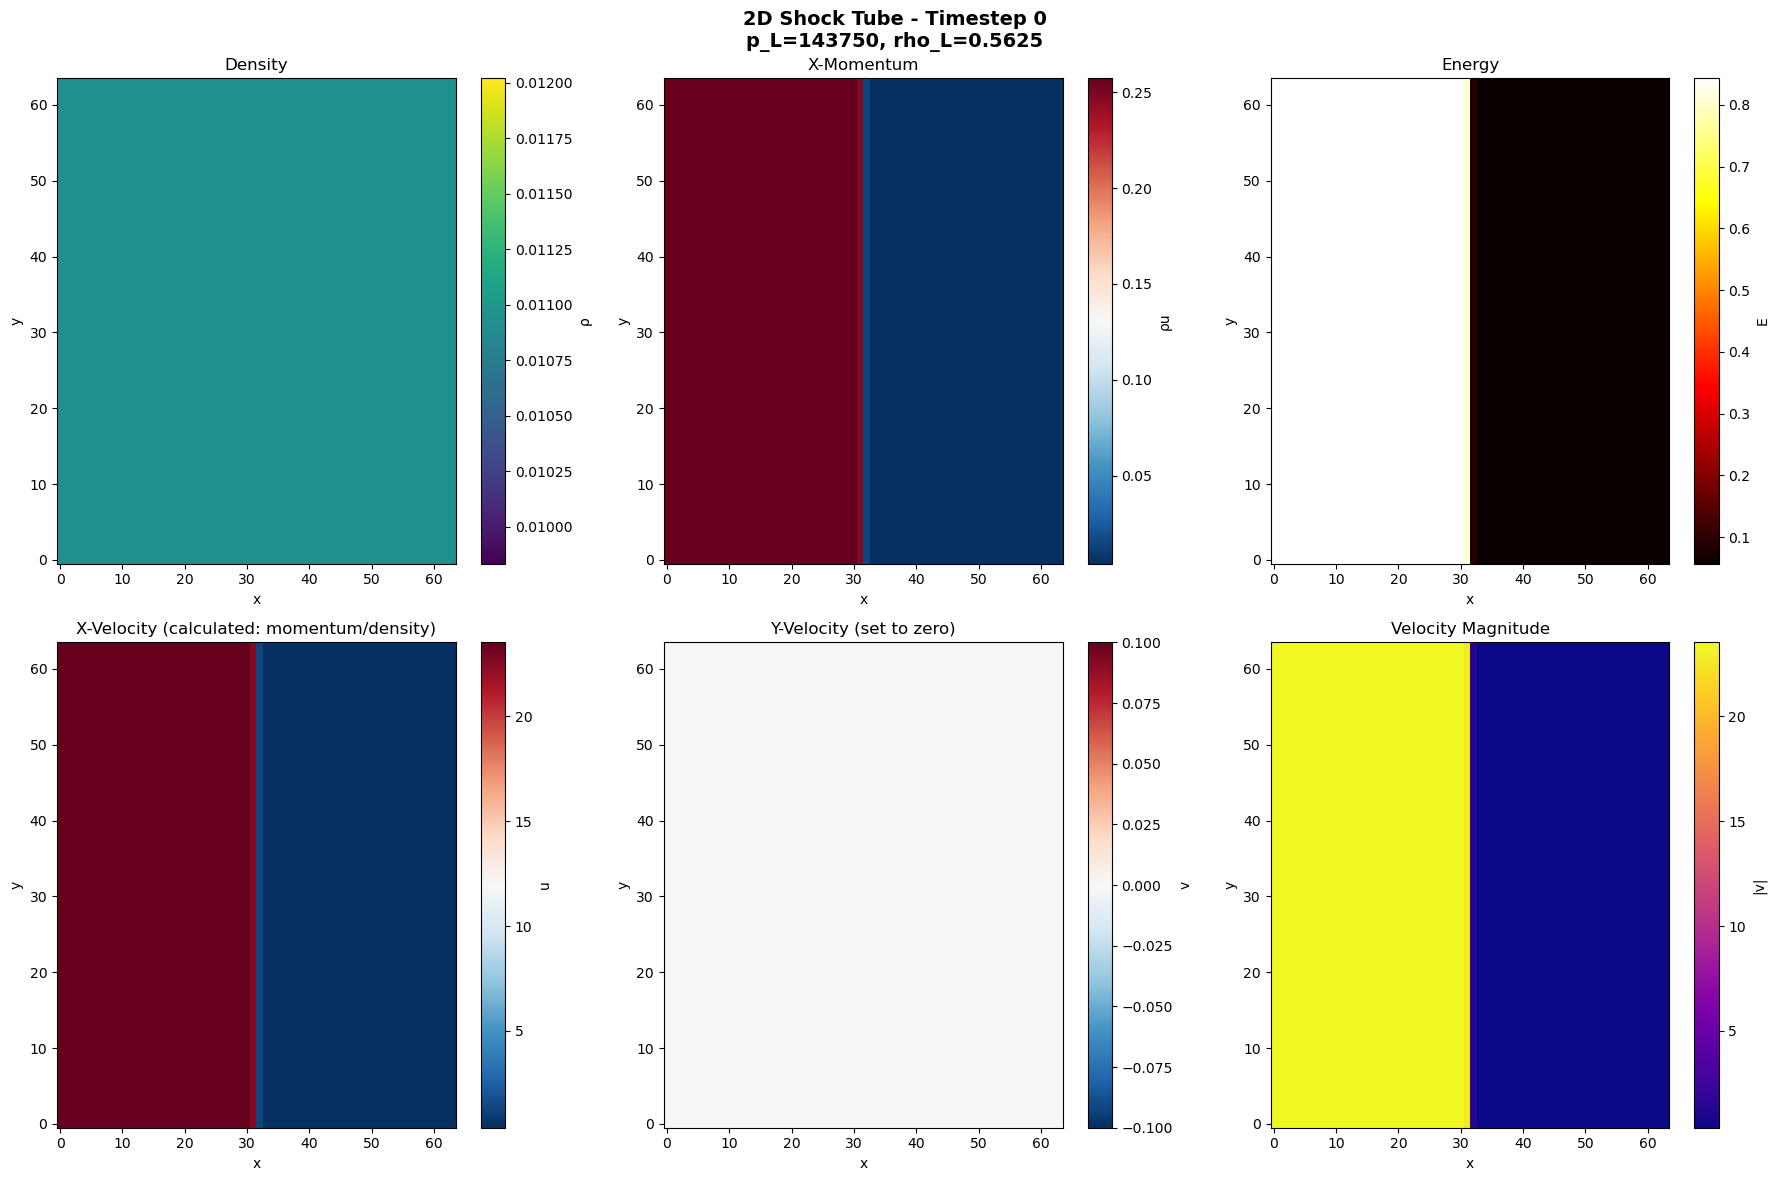

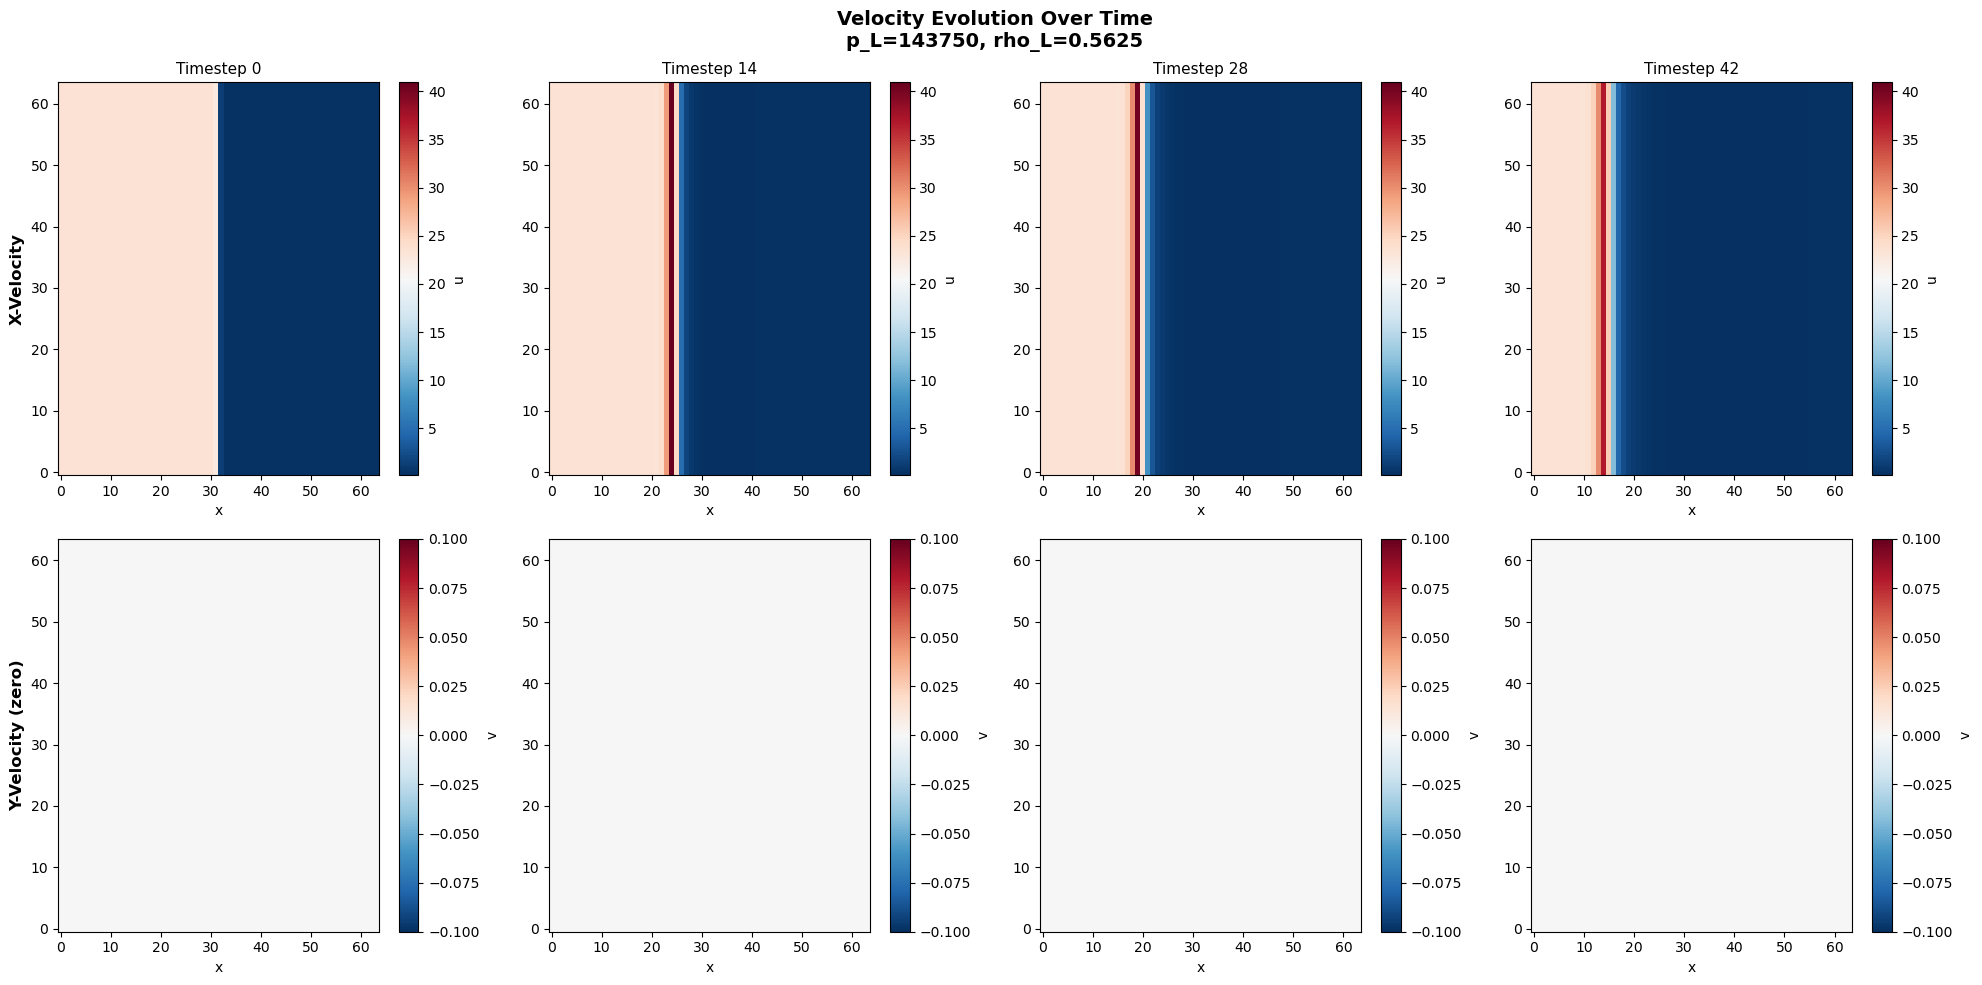

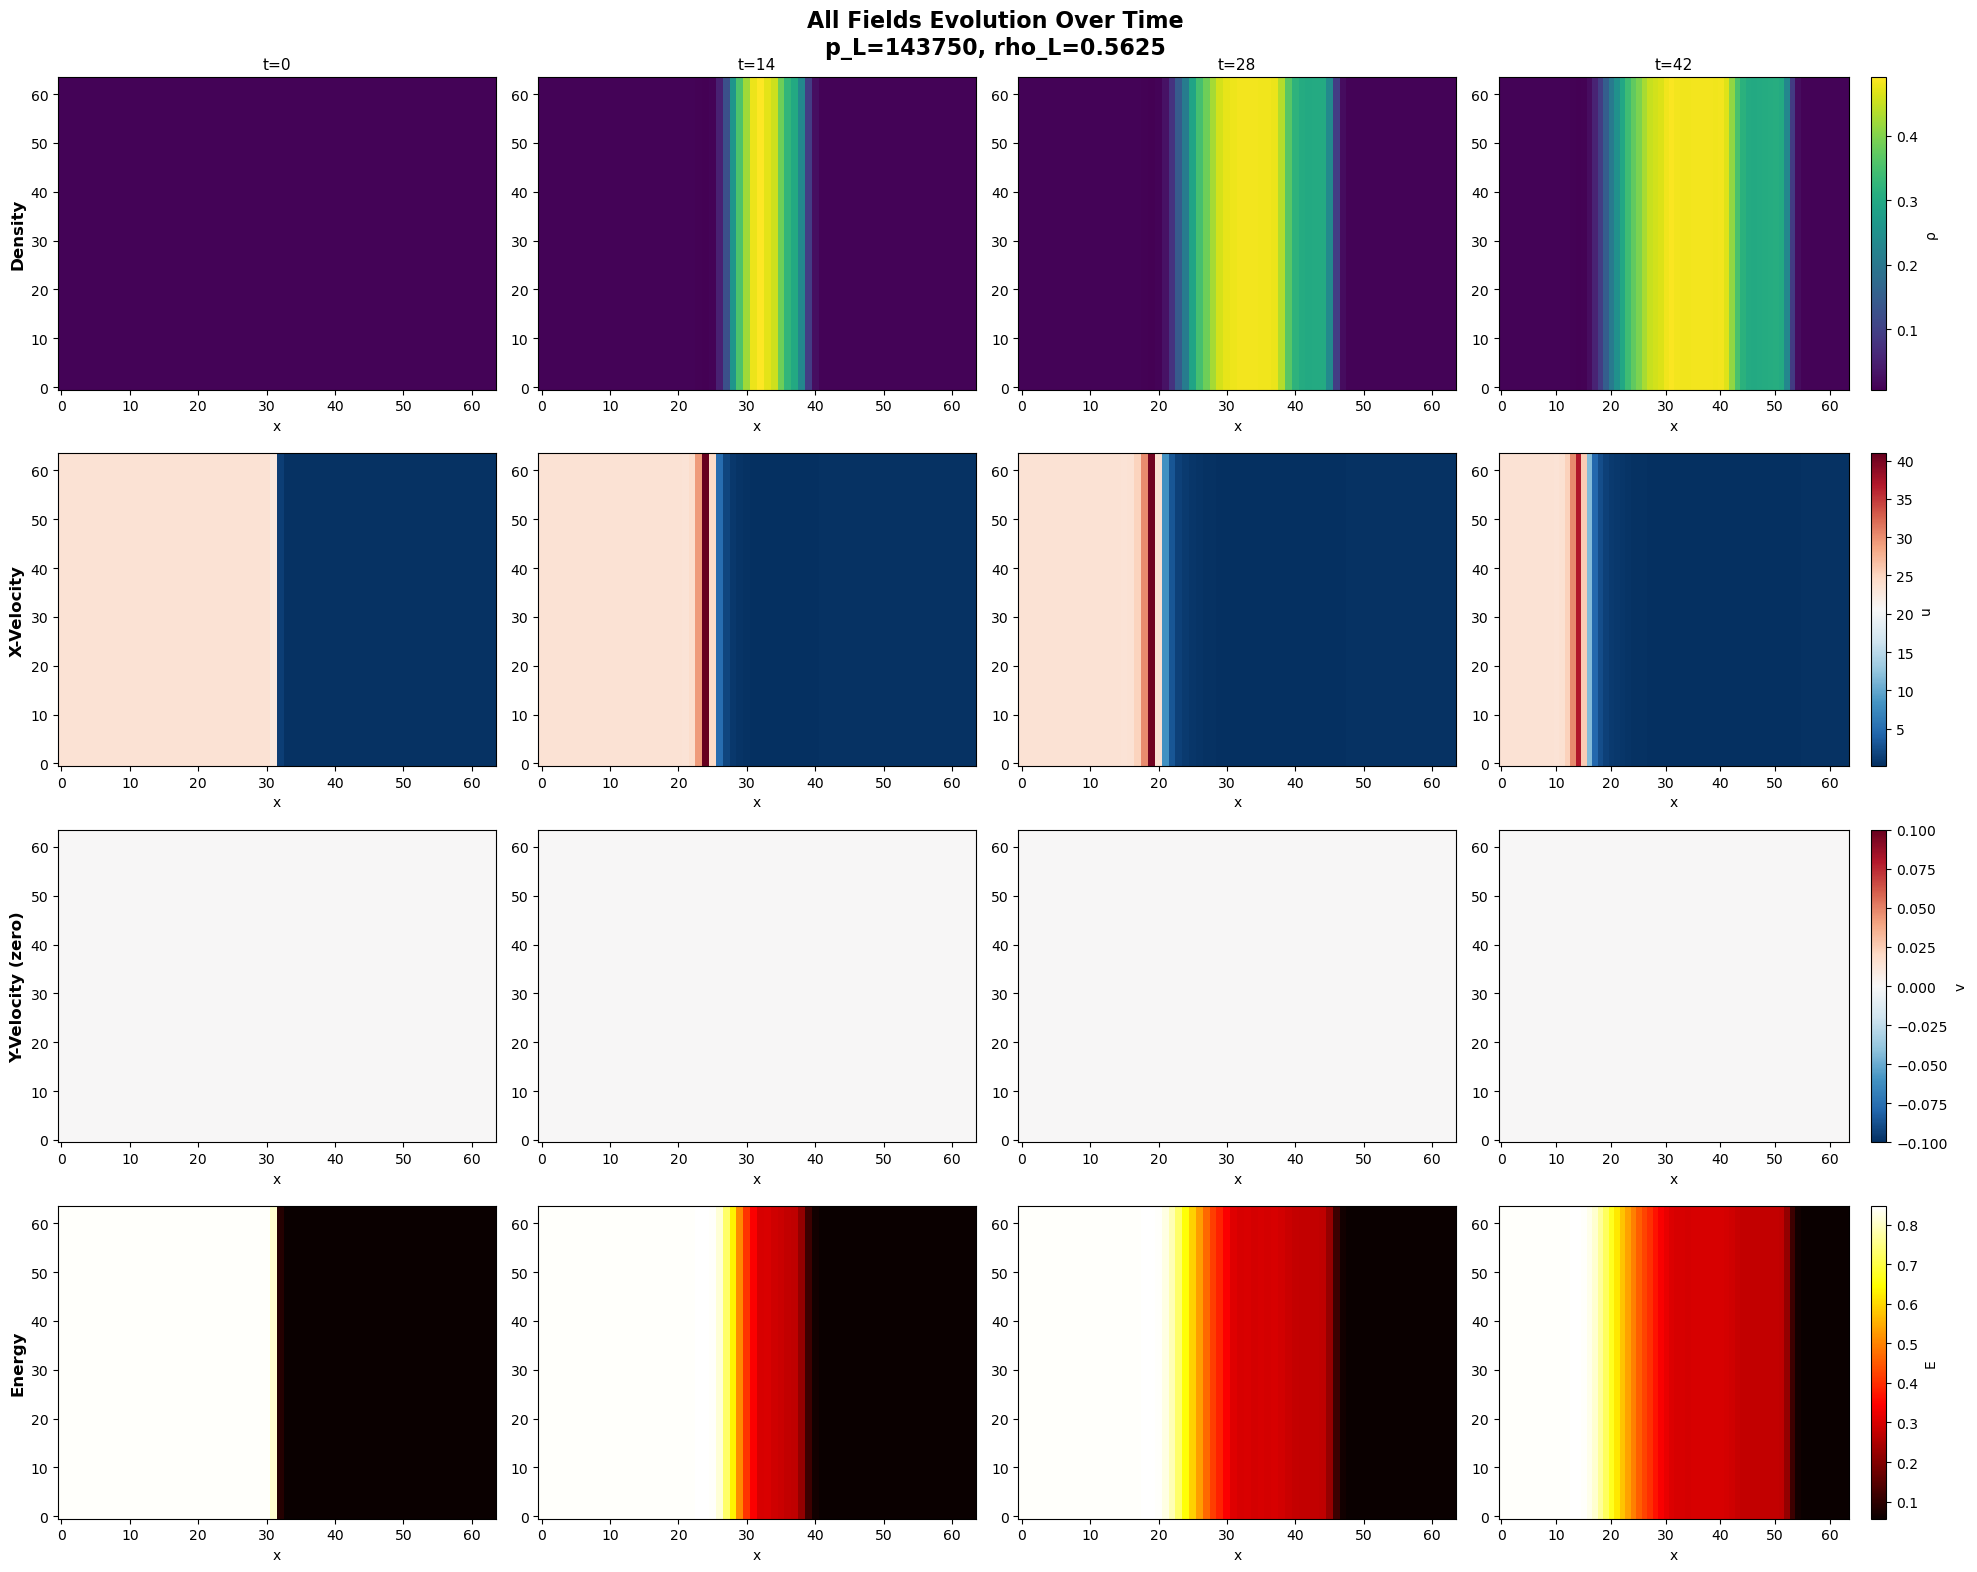

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import re

# Define the data directory
data_dir = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets")

def find_data_files(dataset='test'):
    """
    Find all data files in the specified dataset directory.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    
    Returns:
    --------
    list of tuples: (p_L, rho_L, input_file, target_file)
    """
    dataset_path = data_dir / dataset
    input_files = sorted(dataset_path.glob(f"*_{dataset}_input.npy"))
    
    file_info = []
    for input_file in input_files:
        # Parse filename: p_L_143750_rho_L_0.5625_test_input.npy
        match = re.search(r'p_L_([\d.]+)_rho_L_([\d.]+)', input_file.name)
        if match:
            p_L = match.group(1)
            rho_L = match.group(2)
            
            # Find corresponding target file
            target_file = input_file.parent / input_file.name.replace('_input.npy', '_target.npy')
            
            file_info.append({
                'p_L': p_L,
                'rho_L': rho_L,
                'input_file': input_file,
                'target_file': target_file if target_file.exists() else None
            })
    
    return file_info

def load_sample_data(dataset='test', file_idx=0):
    """
    Load a sample from the dataset.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    file_idx : int
        Index of the file to load from the list of available files
    
    Returns:
    --------
    dict containing data array, metadata, and file info
    """
    files = find_data_files(dataset)
    
    if not files:
        raise ValueError(f"No files found in {dataset} directory")
    
    if file_idx >= len(files):
        raise ValueError(f"File index {file_idx} out of range. Found {len(files)} files.")
    
    file_info = files[file_idx]
    
    # Load the data: shape is (timesteps, channels, height, width)
    data = np.load(file_info['input_file'])
    
    # Load target if available
    target = None
    if file_info['target_file'] and file_info['target_file'].exists():
        target = np.load(file_info['target_file'])
    
    print(f"\nLoaded file: {file_info['input_file'].name}")
    print(f"  p_L: {file_info['p_L']}")
    print(f"  rho_L: {file_info['rho_L']}")
    print(f"  Data shape: {data.shape} (timesteps, channels, height, width)")
    print(f"  Number of timesteps: {data.shape[0]}")
    print(f"  Number of channels: {data.shape[1]}")
    print(f"  Grid size: {data.shape[2]} x {data.shape[3]}")
    
    if target is not None:
        print(f"  Target shape: {target.shape}")
    
    return {
        'data': data,
        'target': target,
        'file_info': file_info,
        'files_available': files
    }

def extract_fields(data, timestep=0):
    """
    Extract individual fields from the data array.
    New format with 5 channels: [x_momentum, density, energy, x_velocity, y_velocity]
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    timestep : int
        Which timestep to extract
    
    Returns:
    --------
    dict with individual field arrays
    """
    return {
        'x_momentum': data[timestep, 0, :, :],
        'density': data[timestep, 1, :, :],
        'energy': data[timestep, 2, :, :],
        'x_velocity': data[timestep, 3, :, :],
        'y_velocity': data[timestep, 4, :, :]
    }

def calculate_velocity(x_momentum, density):
    """
    Calculate x-velocity from x-momentum and density.
    velocity = momentum / density
    
    Parameters:
    -----------
    x_momentum : numpy array
        x-component of momentum
    density : numpy array
        Density field
    
    Returns:
    --------
    x_velocity : numpy array
        x-component of velocity
    """
    # Avoid division by zero
    x_velocity = np.divide(x_momentum, density, 
                          where=density!=0, 
                          out=np.zeros_like(x_momentum))
    return x_velocity

def visualize_shock_tube(fields, timestep=0, file_info=None):
    """
    Visualize the 2D shock tube data.
    
    Parameters:
    -----------
    fields : dict
        Dictionary containing the field variables
    timestep : int
        Timestep index (for title)
    file_info : dict
        File information (for title)
    """
    # Create figure with subplots - now 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    title = f'2D Shock Tube - Timestep {timestep}'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Plot density
    im0 = axes[0, 0].imshow(fields['density'], cmap='viridis', aspect='auto', origin='lower')
    axes[0, 0].set_title('Density', fontsize=12)
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im0, ax=axes[0, 0], label='ρ')
    
    # Plot x-momentum
    im1 = axes[0, 1].imshow(fields['x_momentum'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[0, 1].set_title('X-Momentum', fontsize=12)
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 1], label='ρu')
    
    # Plot energy
    im2 = axes[0, 2].imshow(fields['energy'], cmap='hot', aspect='auto', origin='lower')
    axes[0, 2].set_title('Energy', fontsize=12)
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')
    plt.colorbar(im2, ax=axes[0, 2], label='E')
    
    # Plot x-velocity
    im3 = axes[1, 0].imshow(fields['x_velocity'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[1, 0].set_title('X-Velocity (calculated: momentum/density)', fontsize=12)
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im3, ax=axes[1, 0], label='u')
    
    # Plot y-velocity (all zeros)
    im4 = axes[1, 1].imshow(fields['y_velocity'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[1, 1].set_title('Y-Velocity (set to zero)', fontsize=12)
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    plt.colorbar(im4, ax=axes[1, 1], label='v')
    
    # Add velocity magnitude plot
    velocity_mag = np.sqrt(fields['x_velocity']**2 + fields['y_velocity']**2)
    im5 = axes[1, 2].imshow(velocity_mag, cmap='plasma', aspect='auto', origin='lower')
    axes[1, 2].set_title('Velocity Magnitude', fontsize=12)
    axes[1, 2].set_xlabel('x')
    axes[1, 2].set_ylabel('y')
    plt.colorbar(im5, ax=axes[1, 2], label='|v|')
    
    plt.tight_layout()
    return fig, fields['x_velocity'], fields['y_velocity']

def visualize_time_evolution(data, file_info=None, num_snapshots=4):
    """
    Visualize the time evolution of x-velocity and y-velocity.
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    file_info : dict
        File information
    num_snapshots : int
        Number of time snapshots to display
    """
    num_timesteps = data.shape[0]
    timestep_indices = np.linspace(0, num_timesteps-1, num_snapshots, dtype=int)
    
    fig, axes = plt.subplots(2, num_snapshots, figsize=(5*num_snapshots, 10))
    
    title = 'Velocity Evolution Over Time'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    vmin_x, vmax_x = None, None
    x_velocities = []
    y_velocities = []
    
    # Calculate velocities and find global min/max for consistent colorbar
    for idx in timestep_indices:
        fields = extract_fields(data, timestep=idx)
        x_velocities.append(fields['x_velocity'])
        y_velocities.append(fields['y_velocity'])
        
        if vmin_x is None:
            vmin_x, vmax_x = fields['x_velocity'].min(), fields['x_velocity'].max()
        else:
            vmin_x = min(vmin_x, fields['x_velocity'].min())
            vmax_x = max(vmax_x, fields['x_velocity'].max())
    
    # Plot all timesteps with consistent colorbar
    for i, (idx, x_vel, y_vel) in enumerate(zip(timestep_indices, x_velocities, y_velocities)):
        # X-velocity (top row)
        ax = axes[0, i] if num_snapshots > 1 else axes[0]
        im = ax.imshow(x_vel, cmap='RdBu_r', aspect='auto', origin='lower', vmin=vmin_x, vmax=vmax_x)
        ax.set_title(f'Timestep {idx}', fontsize=11)
        ax.set_xlabel('x')
        if i == 0:
            ax.set_ylabel('X-Velocity', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, label='u')
        
        # Y-velocity (bottom row) - all zeros
        ax = axes[1, i] if num_snapshots > 1 else axes[1]
        im = ax.imshow(y_vel, cmap='RdBu_r', aspect='auto', origin='lower', vmin=-0.1, vmax=0.1)
        ax.set_xlabel('x')
        if i == 0:
            ax.set_ylabel('Y-Velocity (zero)', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, label='v')
    
    plt.tight_layout()
    return fig

def visualize_all_fields_evolution(data, file_info=None, num_snapshots=4):
    """
    Visualize all fields (density, x-velocity, y-velocity, energy) at multiple timesteps.
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    file_info : dict
        File information
    num_snapshots : int
        Number of time snapshots to display
    """
    num_timesteps = data.shape[0]
    timestep_indices = np.linspace(0, num_timesteps-1, num_snapshots, dtype=int)
    
    # Create a figure with 4 rows (density, x-vel, y-vel, energy) and num_snapshots columns
    fig, axes = plt.subplots(4, num_snapshots, figsize=(5*num_snapshots, 16))
    
    title = 'All Fields Evolution Over Time'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Store min/max for consistent colorbars across timesteps for each field
    density_range = [None, None]
    x_velocity_range = [None, None]
    energy_range = [None, None]
    
    all_fields_data = []
    
    # First pass: calculate all fields and find global ranges
    for idx in timestep_indices:
        fields = extract_fields(data, timestep=idx)
        
        all_fields_data.append(fields)
        
        # Update ranges
        if density_range[0] is None:
            density_range = [fields['density'].min(), fields['density'].max()]
            x_velocity_range = [fields['x_velocity'].min(), fields['x_velocity'].max()]
            energy_range = [fields['energy'].min(), fields['energy'].max()]
        else:
            density_range[0] = min(density_range[0], fields['density'].min())
            density_range[1] = max(density_range[1], fields['density'].max())
            x_velocity_range[0] = min(x_velocity_range[0], fields['x_velocity'].min())
            x_velocity_range[1] = max(x_velocity_range[1], fields['x_velocity'].max())
            energy_range[0] = min(energy_range[0], fields['energy'].min())
            energy_range[1] = max(energy_range[1], fields['energy'].max())
    
    # Second pass: plot all fields
    for col, (idx, fields) in enumerate(zip(timestep_indices, all_fields_data)):
        # Row 0: Density
        ax = axes[0, col] if num_snapshots > 1 else axes[0]
        im0 = ax.imshow(fields['density'], cmap='viridis', aspect='auto', origin='lower',
                       vmin=density_range[0], vmax=density_range[1])
        ax.set_title(f't={idx}', fontsize=11)
        if col == 0:
            ax.set_ylabel('Density', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im0, ax=ax, label='ρ')
        
        # Row 1: X-Velocity
        ax = axes[1, col] if num_snapshots > 1 else axes[1]
        im1 = ax.imshow(fields['x_velocity'], cmap='RdBu_r', aspect='auto', origin='lower',
                       vmin=x_velocity_range[0], vmax=x_velocity_range[1])
        if col == 0:
            ax.set_ylabel('X-Velocity', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im1, ax=ax, label='u')
        
        # Row 2: Y-Velocity (all zeros)
        ax = axes[2, col] if num_snapshots > 1 else axes[2]
        im2 = ax.imshow(fields['y_velocity'], cmap='RdBu_r', aspect='auto', origin='lower',
                       vmin=-0.1, vmax=0.1)
        if col == 0:
            ax.set_ylabel('Y-Velocity (zero)', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im2, ax=ax, label='v')
        
        # Row 3: Energy
        ax = axes[3, col] if num_snapshots > 1 else axes[3]
        im3 = ax.imshow(fields['energy'], cmap='hot', aspect='auto', origin='lower',
                       vmin=energy_range[0], vmax=energy_range[1])
        if col == 0:
            ax.set_ylabel('Energy', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im3, ax=ax, label='E')
    
    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # First, let's explore what's actually in the directory
    print("Exploring directory structure...")
    print(f"Base directory: {data_dir}")
    print(f"Exists: {data_dir.exists()}")
    
    if data_dir.exists():
        print("\nContents of base directory:")
        for item in sorted(data_dir.iterdir()):
            print(f"  {item.name} {'(dir)' if item.is_dir() else ''}")
        
        # Check each subdirectory
        for subdir in ['test', 'val', 'train_cases_cnn']:
            subdir_path = data_dir / subdir
            print(f"\n{subdir} directory exists: {subdir_path.exists()}")
            if subdir_path.exists():
                files_list = list(subdir_path.glob("*.npy"))
                print(f"  Found {len(files_list)} .npy files")
                if files_list:
                    print(f"  Sample filenames:")
                    for f in sorted(files_list)[:3]:
                        print(f"    {f.name}")
    
    print("\n" + "="*60)
    
    # List available files
    print("Searching for available files with pattern matching...")
    files = find_data_files(dataset='test')
    print(f"\nFound {len(files)} files in test directory:")
    for i, f in enumerate(files[:5]):  # Show first 5
        print(f"  [{i}] p_L={f['p_L']}, rho_L={f['rho_L']}")
    if len(files) > 5:
        print(f"  ... and {len(files)-5} more")
    
    if not files:
        print("\nNo files found! Please check:")
        print("1. The directory path is correct")
        print("2. The dataset name ('test', 'val', or 'train_cases_cnn')")
        print("3. The file naming pattern")
        import sys
        sys.exit(0)
    
    # Load a sample
    print("\n" + "="*60)
    sample_data = load_sample_data(dataset='test', file_idx=0)
    
    # Extract fields from first timestep
    print("\n" + "="*60)
    print("Extracting fields from timestep 0...")
    fields = extract_fields(sample_data['data'], timestep=0)
    
    print(f"\nField shapes:")
    for key, value in fields.items():
        print(f"  {key}: {value.shape}")
    
    # Calculate velocity statistics
    x_velocity = calculate_velocity(fields['x_momentum'], fields['density'])
    print(f"\nX-Velocity statistics (timestep 0):")
    print(f"  Min: {x_velocity.min():.6f}")
    print(f"  Max: {x_velocity.max():.6f}")
    print(f"  Mean: {x_velocity.mean():.6f}")
    print(f"  Std: {x_velocity.std():.6f}")
    
    # Visualize single timestep
    print("\nGenerating single timestep visualization...")
    fig1, x_vel, y_vel = visualize_shock_tube(fields, timestep=0, 
                                   file_info=sample_data['file_info'])
    
    # Visualize time evolution - velocity only
    print("Generating time evolution visualization...")
    fig2 = visualize_time_evolution(sample_data['data'], 
                                    file_info=sample_data['file_info'],
                                    num_snapshots=4)
    
    # Visualize all fields at multiple timesteps
    print("Generating multi-timestep all-fields visualization...")
    fig3 = visualize_all_fields_evolution(sample_data['data'],
                                          file_info=sample_data['file_info'],
                                          num_snapshots=4)
    
    plt.show()
    
    # Optional: Save figures
    # fig1.savefig('shock_tube_single_timestep.png', dpi=300, bbox_inches='tight')
    # fig2.savefig('shock_tube_time_evolution.png', dpi=300, bbox_inches='tight')

Exploring directory structure...
Base directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets
Exists: True

Contents of base directory:
  cnn_conversion_metadata.json 
  test (dir)
  train (dir)
  val (dir)

test directory exists: True
  Found 150 .npy files
  Sample filenames:
    p_L_143750_rho_L_0.5625_test_input.npy
    p_L_143750_rho_L_0.5625_test_target.npy
    p_L_143750_rho_L_0.5_test_input.npy

val directory exists: True
  Found 50 .npy files
  Sample filenames:
    p_L_100000_rho_L_0.5625_val_input.npy
    p_L_100000_rho_L_0.5625_val_target.npy
    p_L_100000_rho_L_0.5_val_input.npy

train_cases_cnn directory exists: False

Searching for available files with pattern matching...

Found 75 files in test directory:
  [0] p_L=143750, rho_L=0.5625
  [1] p_L=143750, rho_L=0.5
  [2] p_L=143750, rho_L=0.625
  [3] p_L=143750, rho_L=0.6875
  [4] p_L=143750, rho_L=0.75
  ... and 70 more


Loaded file: p_L_143750_rho_L_0.

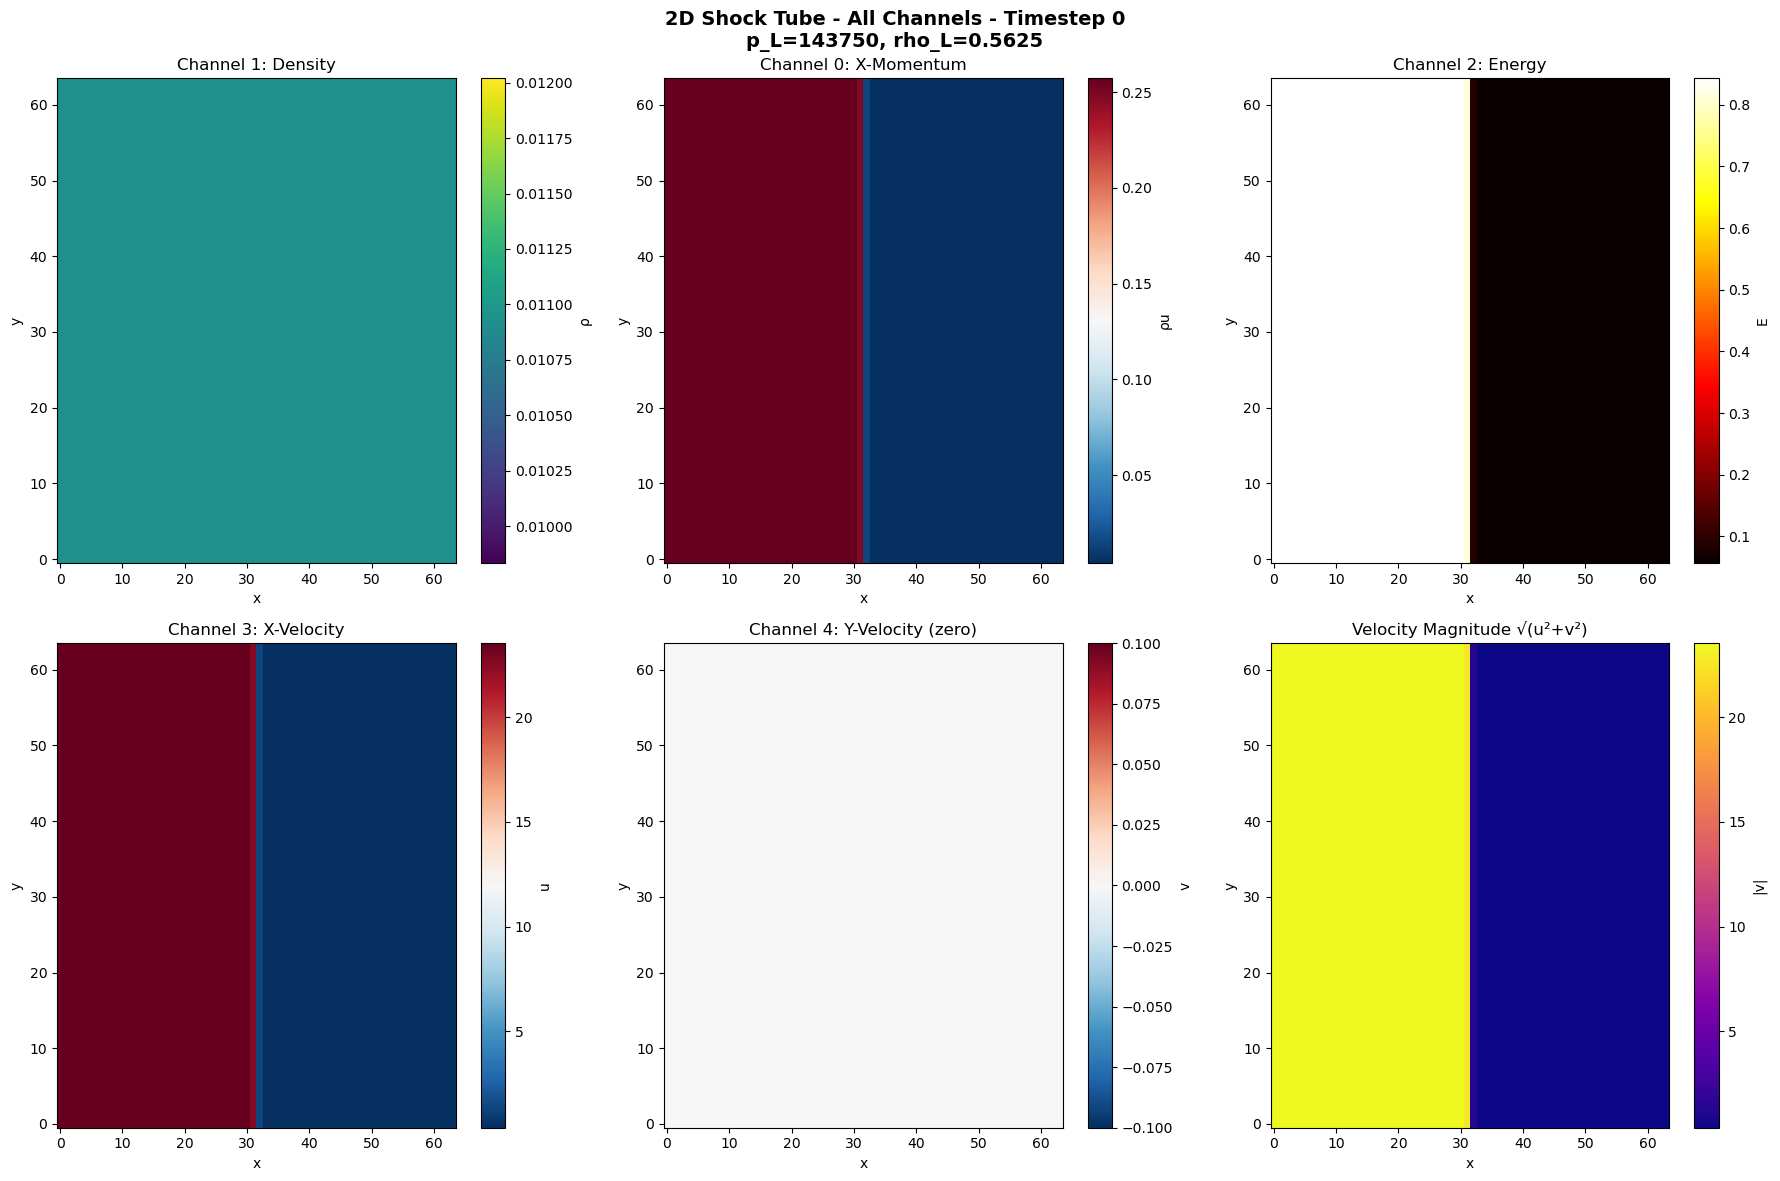

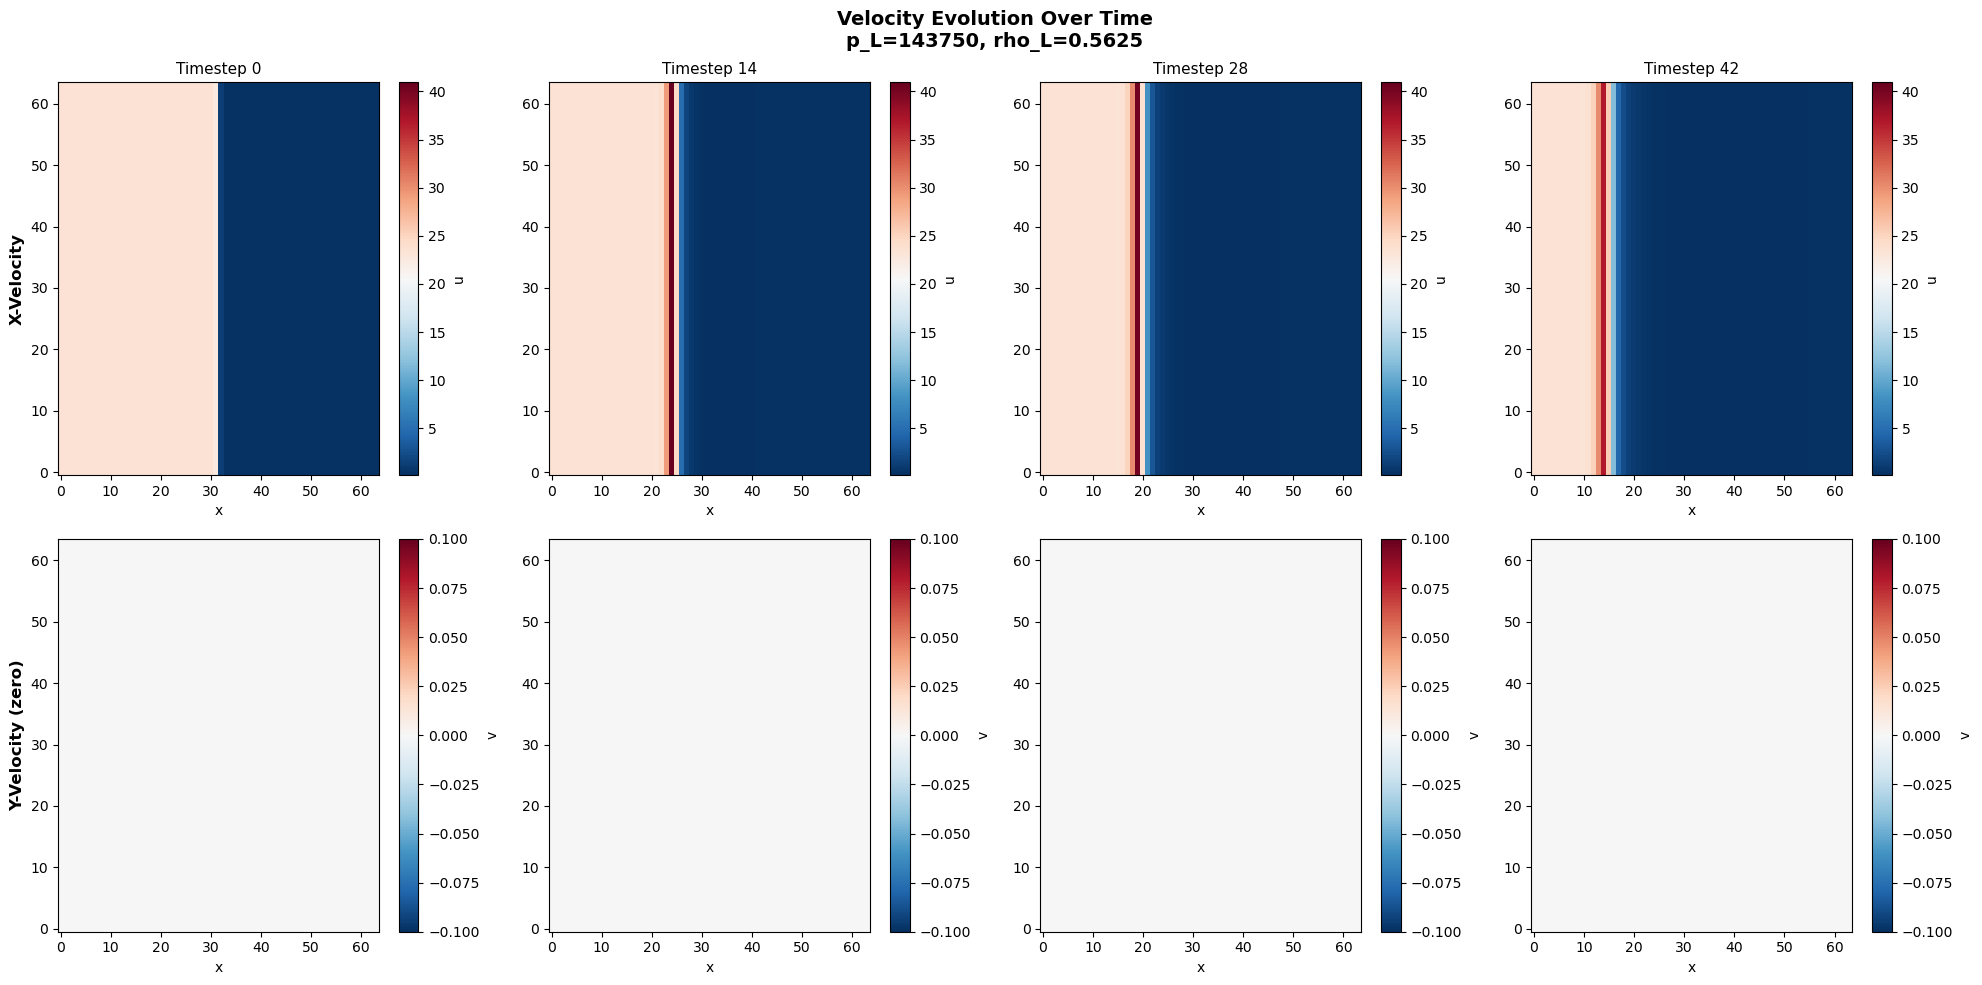

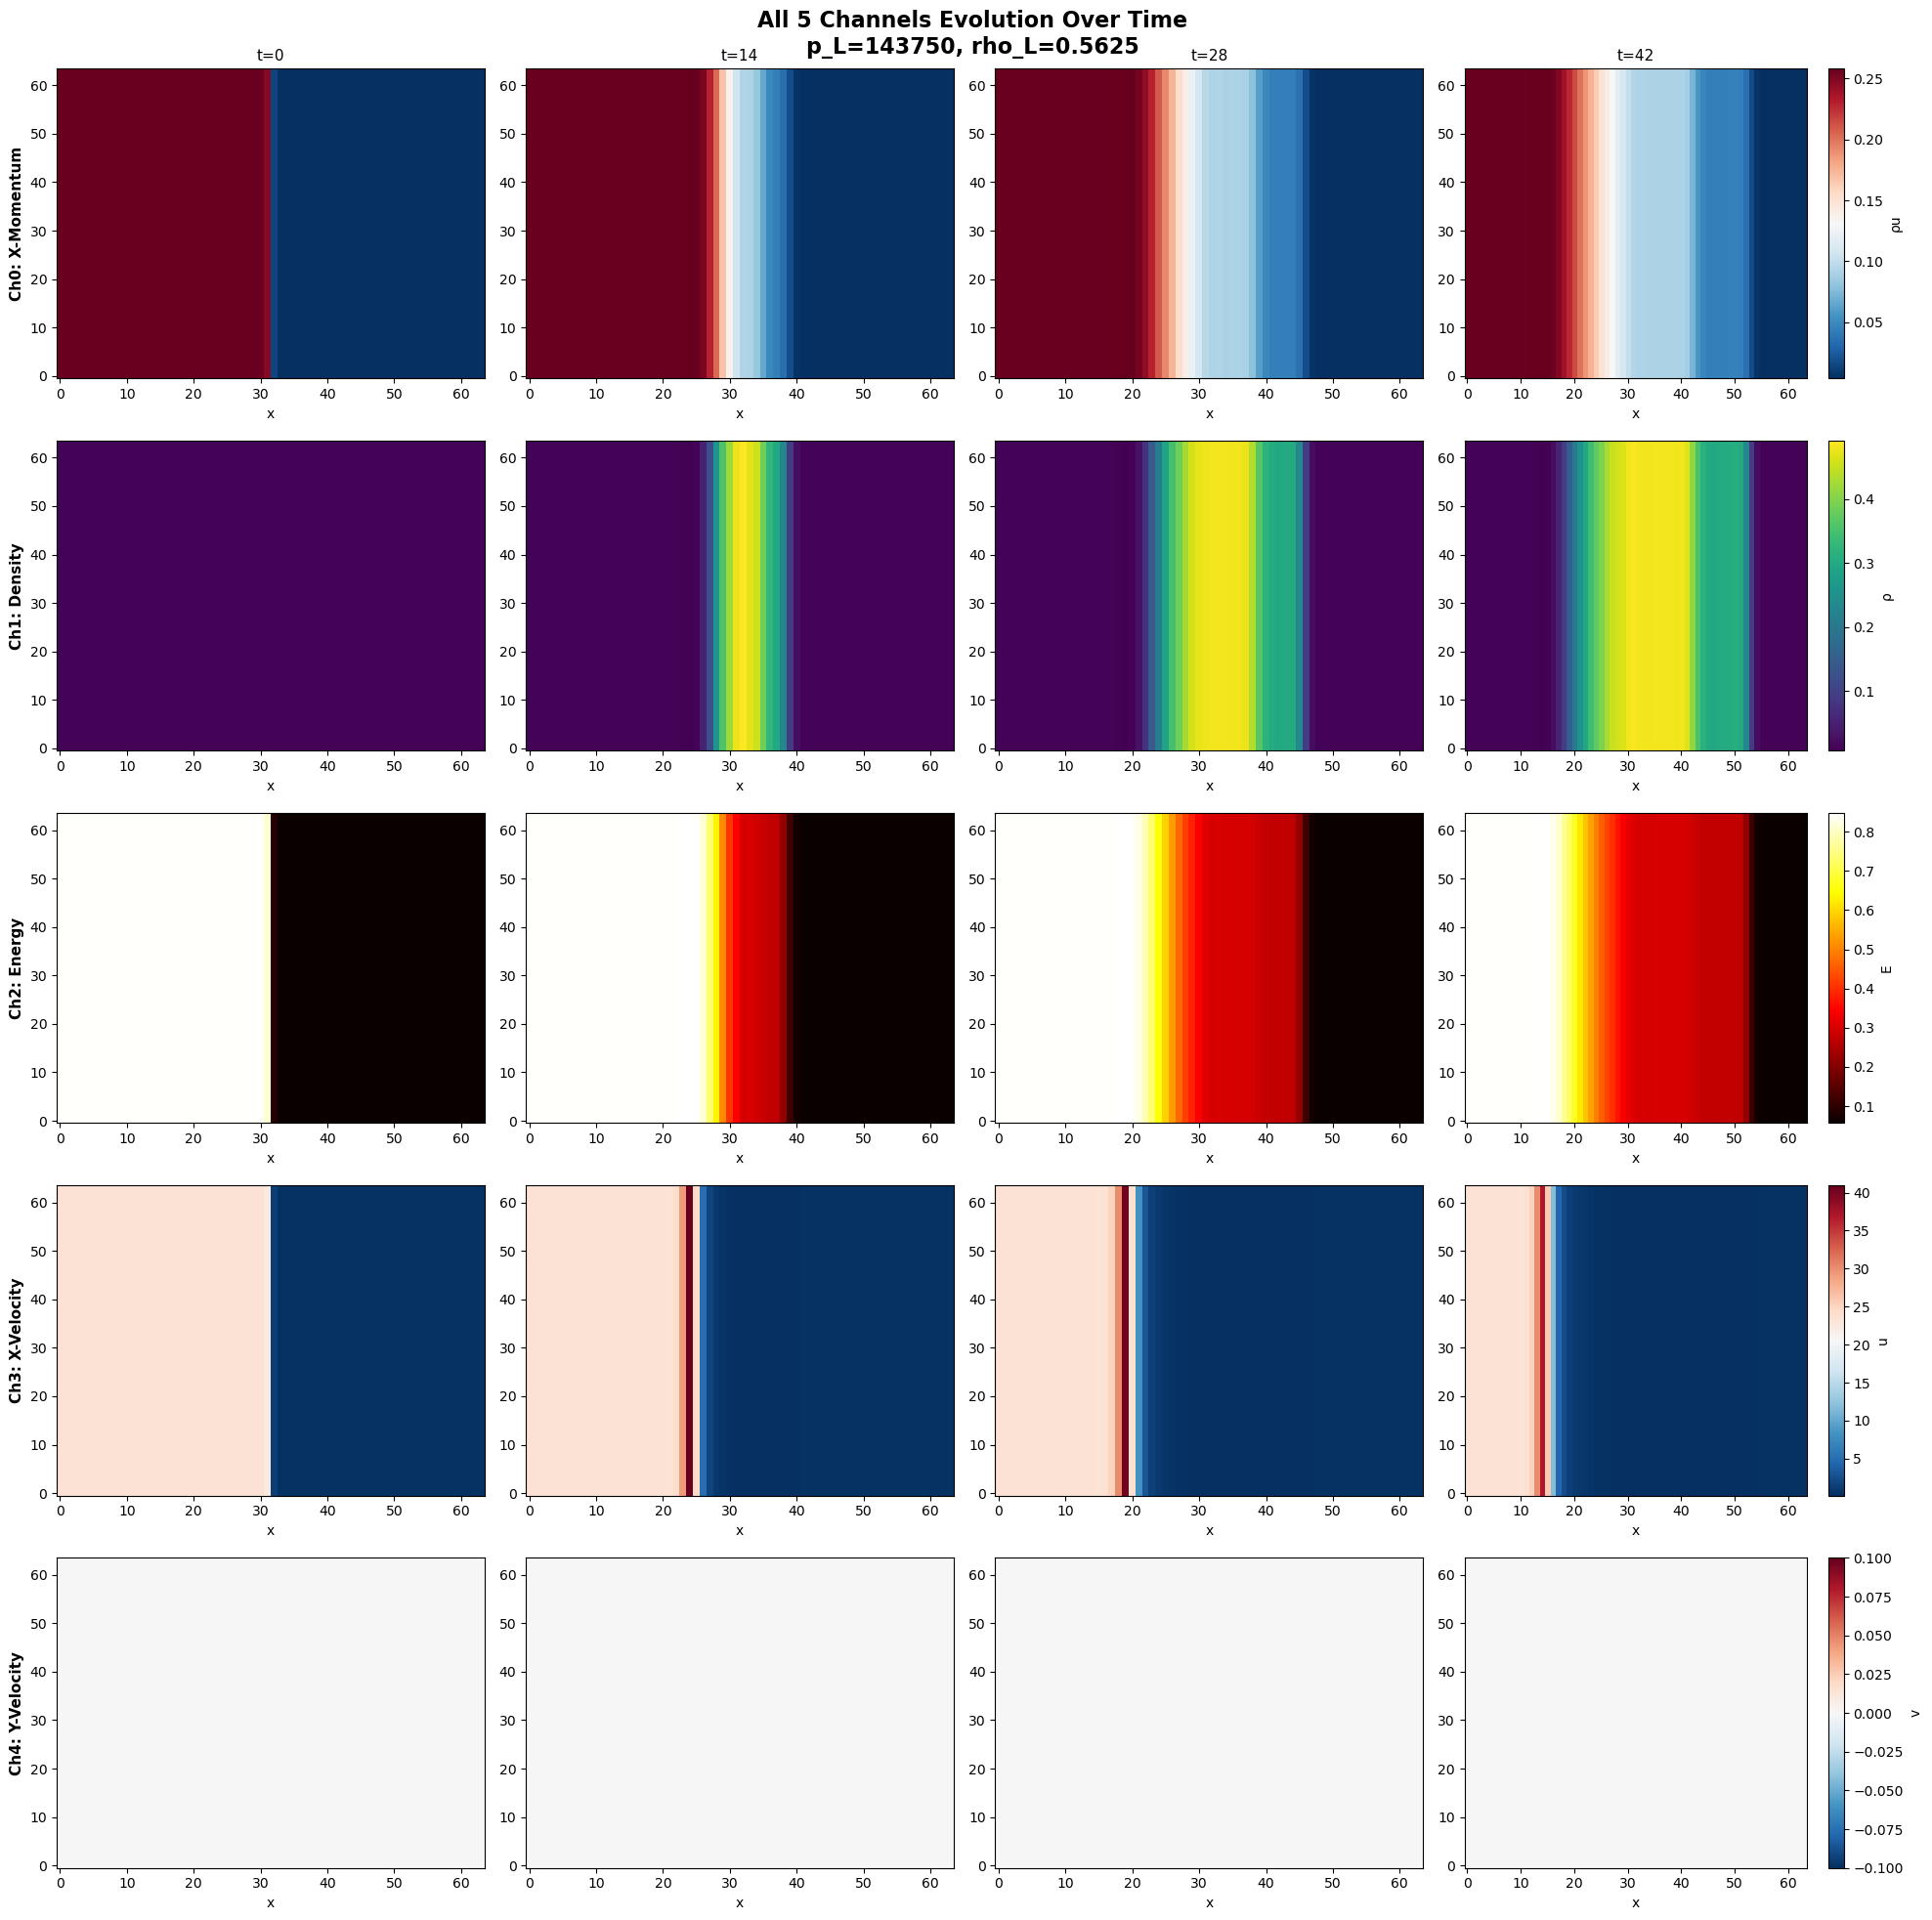

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import re

# Define the data directory
data_dir = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets")

def find_data_files(dataset='test'):
    """
    Find all data files in the specified dataset directory.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    
    Returns:
    --------
    list of tuples: (p_L, rho_L, input_file, target_file)
    """
    dataset_path = data_dir / dataset
    input_files = sorted(dataset_path.glob(f"*_{dataset}_input.npy"))
    
    file_info = []
    for input_file in input_files:
        # Parse filename: p_L_143750_rho_L_0.5625_test_input.npy
        match = re.search(r'p_L_([\d.]+)_rho_L_([\d.]+)', input_file.name)
        if match:
            p_L = match.group(1)
            rho_L = match.group(2)
            
            # Find corresponding target file
            target_file = input_file.parent / input_file.name.replace('_input.npy', '_target.npy')
            
            file_info.append({
                'p_L': p_L,
                'rho_L': rho_L,
                'input_file': input_file,
                'target_file': target_file if target_file.exists() else None
            })
    
    return file_info

def load_sample_data(dataset='test', file_idx=0):
    """
    Load a sample from the dataset.
    
    Parameters:
    -----------
    dataset : str
        'train', 'test', or 'val'
    file_idx : int
        Index of the file to load from the list of available files
    
    Returns:
    --------
    dict containing data array, metadata, and file info
    """
    files = find_data_files(dataset)
    
    if not files:
        raise ValueError(f"No files found in {dataset} directory")
    
    if file_idx >= len(files):
        raise ValueError(f"File index {file_idx} out of range. Found {len(files)} files.")
    
    file_info = files[file_idx]
    
    # Load the data: shape is (timesteps, channels, height, width)
    data = np.load(file_info['input_file'])
    
    # Load target if available
    target = None
    if file_info['target_file'] and file_info['target_file'].exists():
        target = np.load(file_info['target_file'])
    
    print(f"\nLoaded file: {file_info['input_file'].name}")
    print(f"  p_L: {file_info['p_L']}")
    print(f"  rho_L: {file_info['rho_L']}")
    print(f"  Data shape: {data.shape} (timesteps, channels, height, width)")
    print(f"  Number of timesteps: {data.shape[0]}")
    print(f"  Number of channels: {data.shape[1]}")
    print(f"  Grid size: {data.shape[2]} x {data.shape[3]}")
    
    if target is not None:
        print(f"  Target shape: {target.shape}")
    
    return {
        'data': data,
        'target': target,
        'file_info': file_info,
        'files_available': files
    }

def extract_fields(data, timestep=0):
    """
    Extract individual fields from the data array.
    New format with 5 channels: [x_momentum, density, energy, x_velocity, y_velocity]
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    timestep : int
        Which timestep to extract
    
    Returns:
    --------
    dict with individual field arrays
    """
    return {
        'x_momentum': data[timestep, 0, :, :],
        'density': data[timestep, 1, :, :],
        'energy': data[timestep, 2, :, :],
        'x_velocity': data[timestep, 3, :, :],
        'y_velocity': data[timestep, 4, :, :]
    }

def calculate_velocity(x_momentum, density):
    """
    Calculate x-velocity from x-momentum and density.
    velocity = momentum / density
    
    Parameters:
    -----------
    x_momentum : numpy array
        x-component of momentum
    density : numpy array
        Density field
    
    Returns:
    --------
    x_velocity : numpy array
        x-component of velocity
    """
    # Avoid division by zero
    x_velocity = np.divide(x_momentum, density, 
                          where=density!=0, 
                          out=np.zeros_like(x_momentum))
    return x_velocity

def visualize_shock_tube(fields, timestep=0, file_info=None):
    """
    Visualize the 2D shock tube data - all 5 channels.
    
    Parameters:
    -----------
    fields : dict
        Dictionary containing the field variables
    timestep : int
        Timestep index (for title)
    file_info : dict
        File information (for title)
    """
    # Create figure with subplots - 2x3 grid (6 subplots for 5 fields + velocity magnitude)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    title = f'2D Shock Tube - All Channels - Timestep {timestep}'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Plot density (Channel 1)
    im0 = axes[0, 0].imshow(fields['density'], cmap='viridis', aspect='auto', origin='lower')
    axes[0, 0].set_title('Channel 1: Density', fontsize=12)
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im0, ax=axes[0, 0], label='ρ')
    
    # Plot x-momentum (Channel 0)
    im1 = axes[0, 1].imshow(fields['x_momentum'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[0, 1].set_title('Channel 0: X-Momentum', fontsize=12)
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 1], label='ρu')
    
    # Plot energy (Channel 2)
    im2 = axes[0, 2].imshow(fields['energy'], cmap='hot', aspect='auto', origin='lower')
    axes[0, 2].set_title('Channel 2: Energy', fontsize=12)
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')
    plt.colorbar(im2, ax=axes[0, 2], label='E')
    
    # Plot x-velocity (Channel 3)
    im3 = axes[1, 0].imshow(fields['x_velocity'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[1, 0].set_title('Channel 3: X-Velocity', fontsize=12)
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im3, ax=axes[1, 0], label='u')
    
    # Plot y-velocity (Channel 4)
    im4 = axes[1, 1].imshow(fields['y_velocity'], cmap='RdBu_r', aspect='auto', origin='lower')
    axes[1, 1].set_title('Channel 4: Y-Velocity (zero)', fontsize=12)
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    plt.colorbar(im4, ax=axes[1, 1], label='v')
    
    # Add velocity magnitude plot
    velocity_mag = np.sqrt(fields['x_velocity']**2 + fields['y_velocity']**2)
    im5 = axes[1, 2].imshow(velocity_mag, cmap='plasma', aspect='auto', origin='lower')
    axes[1, 2].set_title('Velocity Magnitude √(u²+v²)', fontsize=12)
    axes[1, 2].set_xlabel('x')
    axes[1, 2].set_ylabel('y')
    plt.colorbar(im5, ax=axes[1, 2], label='|v|')
    
    plt.tight_layout()
    return fig, fields['x_velocity'], fields['y_velocity']

def visualize_time_evolution(data, file_info=None, num_snapshots=4):
    """
    Visualize the time evolution of x-velocity and y-velocity.
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    file_info : dict
        File information
    num_snapshots : int
        Number of time snapshots to display
    """
    num_timesteps = data.shape[0]
    timestep_indices = np.linspace(0, num_timesteps-1, num_snapshots, dtype=int)
    
    fig, axes = plt.subplots(2, num_snapshots, figsize=(5*num_snapshots, 10))
    
    title = 'Velocity Evolution Over Time'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    vmin_x, vmax_x = None, None
    x_velocities = []
    y_velocities = []
    
    # Calculate velocities and find global min/max for consistent colorbar
    for idx in timestep_indices:
        fields = extract_fields(data, timestep=idx)
        x_velocities.append(fields['x_velocity'])
        y_velocities.append(fields['y_velocity'])
        
        if vmin_x is None:
            vmin_x, vmax_x = fields['x_velocity'].min(), fields['x_velocity'].max()
        else:
            vmin_x = min(vmin_x, fields['x_velocity'].min())
            vmax_x = max(vmax_x, fields['x_velocity'].max())
    
    # Plot all timesteps with consistent colorbar
    for i, (idx, x_vel, y_vel) in enumerate(zip(timestep_indices, x_velocities, y_velocities)):
        # X-velocity (top row)
        ax = axes[0, i] if num_snapshots > 1 else axes[0]
        im = ax.imshow(x_vel, cmap='RdBu_r', aspect='auto', origin='lower', vmin=vmin_x, vmax=vmax_x)
        ax.set_title(f'Timestep {idx}', fontsize=11)
        ax.set_xlabel('x')
        if i == 0:
            ax.set_ylabel('X-Velocity', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, label='u')
        
        # Y-velocity (bottom row) - all zeros
        ax = axes[1, i] if num_snapshots > 1 else axes[1]
        im = ax.imshow(y_vel, cmap='RdBu_r', aspect='auto', origin='lower', vmin=-0.1, vmax=0.1)
        ax.set_xlabel('x')
        if i == 0:
            ax.set_ylabel('Y-Velocity (zero)', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, label='v')
    
    plt.tight_layout()
    return fig

def visualize_all_fields_evolution(data, file_info=None, num_snapshots=4):
    """
    Visualize all 5 channels at multiple timesteps.
    
    Parameters:
    -----------
    data : numpy array
        Shape (timesteps, channels, height, width)
    file_info : dict
        File information
    num_snapshots : int
        Number of time snapshots to display
    """
    num_timesteps = data.shape[0]
    timestep_indices = np.linspace(0, num_timesteps-1, num_snapshots, dtype=int)
    
    # Create a figure with 5 rows (one per channel) and num_snapshots columns
    fig, axes = plt.subplots(5, num_snapshots, figsize=(5*num_snapshots, 20))
    
    title = 'All 5 Channels Evolution Over Time'
    if file_info:
        title += f"\np_L={file_info['p_L']}, rho_L={file_info['rho_L']}"
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Store min/max for consistent colorbars across timesteps for each field
    momentum_range = [None, None]
    density_range = [None, None]
    energy_range = [None, None]
    x_velocity_range = [None, None]
    
    all_fields_data = []
    
    # First pass: extract all fields and find global ranges
    for idx in timestep_indices:
        fields = extract_fields(data, timestep=idx)
        all_fields_data.append(fields)
        
        # Update ranges
        if momentum_range[0] is None:
            momentum_range = [fields['x_momentum'].min(), fields['x_momentum'].max()]
            density_range = [fields['density'].min(), fields['density'].max()]
            energy_range = [fields['energy'].min(), fields['energy'].max()]
            x_velocity_range = [fields['x_velocity'].min(), fields['x_velocity'].max()]
        else:
            momentum_range[0] = min(momentum_range[0], fields['x_momentum'].min())
            momentum_range[1] = max(momentum_range[1], fields['x_momentum'].max())
            density_range[0] = min(density_range[0], fields['density'].min())
            density_range[1] = max(density_range[1], fields['density'].max())
            energy_range[0] = min(energy_range[0], fields['energy'].min())
            energy_range[1] = max(energy_range[1], fields['energy'].max())
            x_velocity_range[0] = min(x_velocity_range[0], fields['x_velocity'].min())
            x_velocity_range[1] = max(x_velocity_range[1], fields['x_velocity'].max())
    
    # Second pass: plot all fields
    for col, (idx, fields) in enumerate(zip(timestep_indices, all_fields_data)):
        # Row 0: X-Momentum (Channel 0)
        ax = axes[0, col] if num_snapshots > 1 else axes[0]
        im0 = ax.imshow(fields['x_momentum'], cmap='RdBu_r', aspect='auto', origin='lower',
                       vmin=momentum_range[0], vmax=momentum_range[1])
        ax.set_title(f't={idx}', fontsize=11)
        if col == 0:
            ax.set_ylabel('Ch0: X-Momentum', fontsize=11, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im0, ax=ax, label='ρu')
        
        # Row 1: Density (Channel 1)
        ax = axes[1, col] if num_snapshots > 1 else axes[1]
        im1 = ax.imshow(fields['density'], cmap='viridis', aspect='auto', origin='lower',
                       vmin=density_range[0], vmax=density_range[1])
        if col == 0:
            ax.set_ylabel('Ch1: Density', fontsize=11, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im1, ax=ax, label='ρ')
        
        # Row 2: Energy (Channel 2)
        ax = axes[2, col] if num_snapshots > 1 else axes[2]
        im2 = ax.imshow(fields['energy'], cmap='hot', aspect='auto', origin='lower',
                       vmin=energy_range[0], vmax=energy_range[1])
        if col == 0:
            ax.set_ylabel('Ch2: Energy', fontsize=11, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im2, ax=ax, label='E')
        
        # Row 3: X-Velocity (Channel 3)
        ax = axes[3, col] if num_snapshots > 1 else axes[3]
        im3 = ax.imshow(fields['x_velocity'], cmap='RdBu_r', aspect='auto', origin='lower',
                       vmin=x_velocity_range[0], vmax=x_velocity_range[1])
        if col == 0:
            ax.set_ylabel('Ch3: X-Velocity', fontsize=11, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im3, ax=ax, label='u')
        
        # Row 4: Y-Velocity (Channel 4) - all zeros
        ax = axes[4, col] if num_snapshots > 1 else axes[4]
        im4 = ax.imshow(fields['y_velocity'], cmap='RdBu_r', aspect='auto', origin='lower',
                       vmin=-0.1, vmax=0.1)
        if col == 0:
            ax.set_ylabel('Ch4: Y-Velocity', fontsize=11, fontweight='bold')
        ax.set_xlabel('x')
        if col == num_snapshots - 1:
            plt.colorbar(im4, ax=ax, label='v')
    
    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # First, let's explore what's actually in the directory
    print("Exploring directory structure...")
    print(f"Base directory: {data_dir}")
    print(f"Exists: {data_dir.exists()}")
    
    if data_dir.exists():
        print("\nContents of base directory:")
        for item in sorted(data_dir.iterdir()):
            print(f"  {item.name} {'(dir)' if item.is_dir() else ''}")
        
        # Check each subdirectory
        for subdir in ['test', 'val', 'train_cases_cnn']:
            subdir_path = data_dir / subdir
            print(f"\n{subdir} directory exists: {subdir_path.exists()}")
            if subdir_path.exists():
                files_list = list(subdir_path.glob("*.npy"))
                print(f"  Found {len(files_list)} .npy files")
                if files_list:
                    print(f"  Sample filenames:")
                    for f in sorted(files_list)[:3]:
                        print(f"    {f.name}")
    
    print("\n" + "="*60)
    
    # List available files
    print("Searching for available files with pattern matching...")
    files = find_data_files(dataset='test')
    print(f"\nFound {len(files)} files in test directory:")
    for i, f in enumerate(files[:5]):  # Show first 5
        print(f"  [{i}] p_L={f['p_L']}, rho_L={f['rho_L']}")
    if len(files) > 5:
        print(f"  ... and {len(files)-5} more")
    
    if not files:
        print("\nNo files found! Please check:")
        print("1. The directory path is correct")
        print("2. The dataset name ('test', 'val', or 'train_cases_cnn')")
        print("3. The file naming pattern")
        import sys
        sys.exit(0)
    
    # Load a sample
    print("\n" + "="*60)
    sample_data = load_sample_data(dataset='test', file_idx=0)
    
    # Extract fields from first timestep
    print("\n" + "="*60)
    print("Extracting fields from timestep 0...")
    fields = extract_fields(sample_data['data'], timestep=0)
    
    print(f"\nField shapes:")
    for key, value in fields.items():
        print(f"  {key}: {value.shape}")
    
    # Calculate velocity statistics
    x_velocity = calculate_velocity(fields['x_momentum'], fields['density'])
    print(f"\nX-Velocity statistics (timestep 0):")
    print(f"  Min: {x_velocity.min():.6f}")
    print(f"  Max: {x_velocity.max():.6f}")
    print(f"  Mean: {x_velocity.mean():.6f}")
    print(f"  Std: {x_velocity.std():.6f}")
    
    # Visualize single timestep
    print("\nGenerating single timestep visualization...")
    fig1, x_vel, y_vel = visualize_shock_tube(fields, timestep=0, 
                                   file_info=sample_data['file_info'])
    
    # Visualize time evolution - velocity only
    print("Generating time evolution visualization...")
    fig2 = visualize_time_evolution(sample_data['data'], 
                                    file_info=sample_data['file_info'],
                                    num_snapshots=4)
    
    # Visualize all fields at multiple timesteps
    print("Generating multi-timestep all-fields visualization...")
    fig3 = visualize_all_fields_evolution(sample_data['data'],
                                          file_info=sample_data['file_info'],
                                          num_snapshots=4)
    
    plt.show()
    
    # Optional: Save figures
    # fig1.savefig('shock_tube_single_timestep.png', dpi=300, bbox_inches='tight')
    # fig2.savefig('shock_tube_time_evolution.png', dpi=300, bbox_inches='tight')

# processing the data finally for this to work

In [1]:
import torch
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm

class PyGToCNNConverter:
    """
    Convert PyTorch Geometric shock tube datasets to CNN-ready format.
    Converts graph node features to 2D grid images with velocity channels.
    Each case is saved as a single numpy file containing all timesteps.
    """
    
    def __init__(self, source_dir, target_dir):
        self.source_dir = Path(source_dir)
        self.target_dir = Path(target_dir)
        self.target_dir.mkdir(exist_ok=True, parents=True)
        
        # Feature configuration
        # Input features (x): [0:x_pos, 1:y_pos, 2:density, 3:x_momentum, 4:y_momentum, 5:total_energy]
        self.input_feature_indices = [2, 3, 5]  # density, x_momentum, total_energy
        
        # Feature names for the final output (with velocities added)
        self.feature_names = ['density', 'x_momentum', 'total_energy', 'x_velocity', 'y_velocity']
        
        print("🔄 PyG to CNN Converter Initialized")
        print(f"Source: {self.source_dir}")
        print(f"Target: {self.target_dir}")
        print(f"Features: {self.feature_names}")
    
    def calculate_velocity(self, x_momentum, density):
        """
        Calculate x-velocity from x-momentum and density.
        velocity = momentum / density
        """
        x_velocity = np.divide(x_momentum, density, 
                              where=density!=0, 
                              out=np.zeros_like(x_momentum))
        return x_velocity
    
    def convert_pyg_to_grid(self, data):
        """
        Convert a single PyG Data object to grid format.
        Returns: (grid, metadata)
        """
        positions = data.pos.numpy()
        features = data.x.numpy()
        
        # Extract physics features
        physics_features = features[:, self.input_feature_indices]
        
        # Get unique coordinates
        x_coords = positions[:, 0]
        y_coords = positions[:, 1]
        unique_x = np.unique(x_coords)
        unique_y = np.unique(y_coords)
        
        # Map positions to grid indices
        i_indices = np.searchsorted(unique_x, x_coords)
        j_indices = np.searchsorted(unique_y, y_coords)
        
        # Create grid with 5 channels: (5, height, width)
        # [density, x_momentum, total_energy, x_velocity, y_velocity]
        num_channels = 5
        grid = np.zeros((num_channels, len(unique_y), len(unique_x)), dtype=np.float32)
        
        # Fill in the first 3 channels (density, x_momentum, total_energy)
        for node_idx in range(len(physics_features)):
            i = i_indices[node_idx]
            j = j_indices[node_idx]
            grid[0:3, j, i] = physics_features[node_idx]
        
        # Calculate and add velocity channels
        density = grid[0, :, :]
        x_momentum = grid[1, :, :]
        
        # Calculate x-velocity
        x_velocity = self.calculate_velocity(x_momentum, density)
        grid[3, :, :] = x_velocity
        
        # Set y-velocity to zero (1D shock tube)
        grid[4, :, :] = 0.0
        
        # Extract metadata
        metadata = {
            'case_name': getattr(data, 'case_name', None),
            'timestep_current': getattr(data, 'timestep_current', None),
            'timestep_next': getattr(data, 'timestep_next', None),
            'time_current': getattr(data, 'time_current', None),
            'time_next': getattr(data, 'time_next', None),
            'delta_t': getattr(data, 'delta_t', None),
            'pressure_numeric': getattr(data, 'pressure_numeric', None),
            'density_numeric': getattr(data, 'density_numeric', None),
        }
        
        # Extract global parameters if they exist
        if hasattr(data, 'global_params') and data.global_params is not None:
            metadata['global_params'] = data.global_params.numpy().tolist()
        
        return grid, metadata
    
    def convert_case_file(self, input_file, output_dir):
        """
        Convert a single PyG case file to CNN format.
        Saves one numpy file per case containing all timesteps.
        """
        # Load PyG dataset (single case with multiple timesteps)
        pyg_dataset = torch.load(input_file, weights_only=False)
        
        if not isinstance(pyg_dataset, list):
            pyg_dataset = [pyg_dataset]
        
        # Get case name from the first sample
        case_name = getattr(pyg_dataset[0], 'case_name', input_file.stem)
        
        # Convert all timesteps for this case
        grids_list = []
        metadata_list = []
        
        for data in pyg_dataset:
            grid, metadata = self.convert_pyg_to_grid(data)
            grids_list.append(grid)
            metadata_list.append(metadata)
        
        # Stack into (timesteps, channels, H, W)
        full_array = np.array(grids_list, dtype=np.float32)  # (T, 5, H, W)
        
        # Save as single numpy file per case
        output_file = output_dir / f"{case_name}.npy"
        np.save(output_file, full_array)
        
        # Save metadata as JSON
        metadata_file = output_dir / f"{case_name}_metadata.json"
        with open(metadata_file, 'w') as f:
            json.dump(metadata_list, f, indent=2, default=str)
        
        return case_name, len(pyg_dataset), full_array.shape
    
    def convert_split_case_directories(self):
        """Convert train_cases/, val_cases/, test_cases/ directories."""
        print("\n" + "="*70)
        print("CONVERTING SPLIT CASE DIRECTORIES")
        print("="*70)
        
        split_dirs = ['train_cases_normalized', 'val_cases_normalized', 'test_cases_normalized']
        split_names = ['train', 'val', 'test']
        total_samples = 0
        split_info = {}
        
        for split_dir_name, split_name in zip(split_dirs, split_names):
            split_dir = self.source_dir / split_dir_name
            
            if not split_dir.exists():
                # Try non-normalized version
                split_dir = self.source_dir / split_dir_name.replace('_normalized', '')
            
            if not split_dir.exists():
                print(f"  ⚠️  {split_dir_name}: Directory not found")
                split_info[split_name] = []
                continue
            
            print(f"\n  Processing {split_dir_name}:")
            
            # Create output directory (train/, val/, test/)
            output_split_dir = self.target_dir / split_name
            output_split_dir.mkdir(exist_ok=True, parents=True)
            
            case_files = sorted(split_dir.glob("*.pt"))
            print(f"    Found {len(case_files)} case files")
            
            split_samples = 0
            case_names = []
            
            for case_file in tqdm(case_files, desc=f"    Converting {split_name}", leave=False):
                case_name, num_timesteps, shape = self.convert_case_file(case_file, output_split_dir)
                case_names.append(case_name)
                split_samples += num_timesteps
                print(f"      ✅ {case_name}: {num_timesteps} timesteps, shape {shape}")
            
            split_info[split_name] = sorted(case_names)
            total_samples += split_samples
            print(f"    ✅ {split_name}: {split_samples} total timesteps from {len(case_files)} cases")
        
        # Save split information
        split_file = self.target_dir / 'dataset_splits.json'
        with open(split_file, 'w') as f:
            json.dump(split_info, f, indent=2)
        print(f"\n  📋 Split information saved: {split_file}")
        
        return total_samples
    
    def save_conversion_metadata(self):
        """Save metadata about the conversion."""
        metadata = {
            'conversion_type': 'PyG_to_CNN_with_velocities',
            'feature_names': self.feature_names,
            'grid_size': '64x64',
            'file_format': 'numpy (.npy)',
            'data_format': {
                'shape': '(timesteps, channels, height, width)',
                'timesteps': 'Number of temporal samples per case',
                'channels': 5,
                'height': 64,
                'width': 64,
                'channel_order': self.feature_names
            },
            'file_structure': {
                'data_files': '{case_name}.npy',
                'metadata_files': '{case_name}_metadata.json',
                'note': 'One file per case containing all timesteps'
            },
            'velocity_calculation': {
                'x_velocity': 'x_momentum / density',
                'y_velocity': '0 (1D shock tube problem)',
                'note': 'Velocities calculated during conversion'
            },
            'source_directory': str(self.source_dir),
            'target_directory': str(self.target_dir),
            'notes': [
                'Each case is saved as a single file with all timesteps',
                'Shape: (timesteps, 5, 64, 64)',
                'Channels: [density, x_momentum, total_energy, x_velocity, y_velocity]',
                'Position features excluded (encoded in pixel locations)',
                'Y momentum excluded (constant in original data)',
                'Y velocity is zero (1D problem)',
                'All values normalized to [0, 1] range',
                'Use np.load() to read .npy files'
            ]
        }
        
        metadata_file = self.target_dir / 'cnn_conversion_metadata.json'
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"\n📄 Conversion metadata saved: {metadata_file}")
    
    def convert_all(self):
        """Convert all datasets."""
        print("\n" + "="*70)
        print("🚀 STARTING BATCH CONVERSION: PyG → CNN FORMAT (with Velocities)")
        print("="*70)
        
        # Convert split case directories (train_cases/, val_cases/, test_cases/)
        total_samples = self.convert_split_case_directories()
        
        # Save metadata
        self.save_conversion_metadata()
        
        # Summary
        print("\n" + "="*70)
        print("🎉 CONVERSION COMPLETE!")
        print("="*70)
        print(f"📊 Total timesteps converted: {total_samples}")
        print(f"📁 Output directory: {self.target_dir}")
        print("\n✅ CNN-ready datasets created:")
        print("   Format: One numpy file per case")
        print("   Shape: (timesteps, 5, 64, 64)")
        print("   Channels: [Density, X Momentum, Total Energy, X Velocity, Y Velocity]")
        print("\n📂 Directory structure:")
        print("   train/ - Training cases")
        print("   val/   - Validation cases")
        print("   test/  - Test cases")
        print("\n📂 File structure per case:")
        print("   {case_name}.npy - All timesteps for the case")
        print("   {case_name}_metadata.json - Metadata for each timestep")


def main():
    """Main execution function."""
    SOURCE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets"
    TARGET_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets"
    
    # Initialize converter
    converter = PyGToCNNConverter(SOURCE_DIR, TARGET_DIR)
    
    # Convert all datasets
    converter.convert_all()
    
    print("\n💡 To load CNN datasets in your training code:")
    print("   import numpy as np")
    print("   from pathlib import Path")
    print("   ")
    print("   # Load a single case (all timesteps)")
    print("   data = np.load('train/case_name.npy')  # shape: (T, 5, 64, 64)")
    print("   ")
    print("   # Access individual channels")
    print("   density = data[:, 0, :, :]      # (T, 64, 64)")
    print("   x_momentum = data[:, 1, :, :]   # (T, 64, 64)")
    print("   total_energy = data[:, 2, :, :] # (T, 64, 64)")
    print("   x_velocity = data[:, 3, :, :]   # (T, 64, 64)")
    print("   y_velocity = data[:, 4, :, :]   # (T, 64, 64) - all zeros")
    print("   ")
    print("   # Load all cases in a split")
    print("   train_dir = Path('cnn_datasets/train')")
    print("   for npy_file in train_dir.glob('*.npy'):")
    print("       case_data = np.load(npy_file)")
    print("       # case_data shape: (timesteps, 5, 64, 64)")


if __name__ == "__main__":
    main()

🔄 PyG to CNN Converter Initialized
Source: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets
Target: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets
Features: ['density', 'x_momentum', 'total_energy', 'x_velocity', 'y_velocity']

🚀 STARTING BATCH CONVERSION: PyG → CNN FORMAT (with Velocities)

CONVERTING SPLIT CASE DIRECTORIES

  Processing train_cases_normalized:
    Found 400 case files


    Converting train:   0%|          | 1/400 [00:03<21:50,  3.28s/it]

      ✅ p_L_100000_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   0%|          | 2/400 [00:03<10:14,  1.54s/it]

      ✅ p_L_100000_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   1%|          | 3/400 [00:04<06:44,  1.02s/it]

      ✅ p_L_100000_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   1%|          | 4/400 [00:04<04:50,  1.36it/s]

      ✅ p_L_100000_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   1%|▏         | 5/400 [00:04<03:46,  1.75it/s]

      ✅ p_L_100000_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   2%|▏         | 6/400 [00:05<03:29,  1.88it/s]

      ✅ p_L_100000_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   2%|▏         | 7/400 [00:05<02:54,  2.25it/s]

      ✅ p_L_100000_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   2%|▏         | 8/400 [00:05<02:46,  2.35it/s]

      ✅ p_L_100000_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   2%|▏         | 9/400 [00:06<02:50,  2.29it/s]

      ✅ p_L_100000_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   2%|▎         | 10/400 [00:06<02:31,  2.57it/s]

      ✅ p_L_100000_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   3%|▎         | 11/400 [00:07<02:57,  2.19it/s]

      ✅ p_L_100000_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   3%|▎         | 12/400 [00:07<02:44,  2.35it/s]

      ✅ p_L_100000_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   3%|▎         | 13/400 [00:07<02:41,  2.40it/s]

      ✅ p_L_100000_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   4%|▎         | 14/400 [00:08<02:37,  2.45it/s]

      ✅ p_L_106250_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   4%|▍         | 15/400 [00:08<02:34,  2.50it/s]

      ✅ p_L_106250_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   4%|▍         | 16/400 [00:09<02:40,  2.39it/s]

      ✅ p_L_106250_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   4%|▍         | 17/400 [00:09<02:34,  2.48it/s]

      ✅ p_L_106250_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   4%|▍         | 18/400 [00:09<02:22,  2.69it/s]

      ✅ p_L_106250_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   5%|▍         | 19/400 [00:09<02:06,  3.00it/s]

      ✅ p_L_106250_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   5%|▌         | 20/400 [00:10<02:00,  3.15it/s]

      ✅ p_L_106250_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   5%|▌         | 21/400 [00:10<01:57,  3.23it/s]

      ✅ p_L_106250_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   6%|▌         | 22/400 [00:10<02:09,  2.92it/s]

      ✅ p_L_106250_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   6%|▌         | 23/400 [00:11<02:12,  2.85it/s]

      ✅ p_L_106250_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   6%|▌         | 24/400 [00:11<02:06,  2.98it/s]

      ✅ p_L_106250_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   6%|▋         | 25/400 [00:11<01:57,  3.19it/s]

      ✅ p_L_106250_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   6%|▋         | 26/400 [00:12<02:09,  2.89it/s]

      ✅ p_L_106250_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   7%|▋         | 27/400 [00:12<02:07,  2.92it/s]

      ✅ p_L_112500_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   7%|▋         | 28/400 [00:12<02:09,  2.87it/s]

      ✅ p_L_112500_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   7%|▋         | 29/400 [00:13<02:01,  3.05it/s]

      ✅ p_L_112500_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   8%|▊         | 30/400 [00:13<01:57,  3.14it/s]

      ✅ p_L_112500_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   8%|▊         | 31/400 [00:13<02:11,  2.80it/s]

      ✅ p_L_112500_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   8%|▊         | 32/400 [00:14<02:10,  2.83it/s]

      ✅ p_L_112500_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   8%|▊         | 33/400 [00:14<02:10,  2.82it/s]

      ✅ p_L_112500_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   8%|▊         | 34/400 [00:15<02:03,  2.95it/s]

      ✅ p_L_112500_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   9%|▉         | 35/400 [00:15<01:58,  3.08it/s]

      ✅ p_L_112500_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   9%|▉         | 36/400 [00:15<02:12,  2.74it/s]

      ✅ p_L_112500_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:   9%|▉         | 37/400 [00:16<02:24,  2.51it/s]

      ✅ p_L_112500_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  10%|▉         | 38/400 [00:16<02:26,  2.47it/s]

      ✅ p_L_112500_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  10%|▉         | 39/400 [00:17<02:26,  2.46it/s]

      ✅ p_L_112500_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  10%|█         | 40/400 [00:17<02:32,  2.36it/s]

      ✅ p_L_112500_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  10%|█         | 41/400 [00:17<02:29,  2.40it/s]

      ✅ p_L_112500_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  10%|█         | 42/400 [00:18<02:30,  2.38it/s]

      ✅ p_L_112500_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  11%|█         | 43/400 [00:18<02:30,  2.38it/s]

      ✅ p_L_112500_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  11%|█         | 44/400 [00:19<02:19,  2.55it/s]

      ✅ p_L_112500_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  11%|█▏        | 45/400 [00:19<02:15,  2.61it/s]

      ✅ p_L_112500_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  12%|█▏        | 46/400 [00:19<02:07,  2.78it/s]

      ✅ p_L_112500_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  12%|█▏        | 47/400 [00:20<02:16,  2.59it/s]

      ✅ p_L_112500_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  12%|█▏        | 48/400 [00:20<02:14,  2.61it/s]

      ✅ p_L_112500_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  12%|█▏        | 49/400 [00:20<02:06,  2.78it/s]

      ✅ p_L_112500_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  12%|█▎        | 50/400 [00:21<02:07,  2.75it/s]

      ✅ p_L_112500_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  13%|█▎        | 51/400 [00:21<02:04,  2.80it/s]

      ✅ p_L_118750_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  13%|█▎        | 52/400 [00:21<02:05,  2.78it/s]

      ✅ p_L_118750_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  13%|█▎        | 53/400 [00:22<01:56,  2.98it/s]

      ✅ p_L_118750_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  14%|█▎        | 54/400 [00:22<02:07,  2.71it/s]

      ✅ p_L_118750_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  14%|█▍        | 55/400 [00:23<02:07,  2.70it/s]

      ✅ p_L_118750_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  14%|█▍        | 56/400 [00:23<01:59,  2.88it/s]

      ✅ p_L_118750_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  14%|█▍        | 57/400 [00:23<01:53,  3.03it/s]

      ✅ p_L_118750_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  14%|█▍        | 58/400 [00:24<01:56,  2.94it/s]

      ✅ p_L_118750_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  15%|█▍        | 59/400 [00:24<01:52,  3.03it/s]

      ✅ p_L_118750_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  15%|█▌        | 60/400 [00:24<01:58,  2.86it/s]

      ✅ p_L_118750_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  15%|█▌        | 61/400 [00:25<01:51,  3.03it/s]

      ✅ p_L_118750_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  16%|█▌        | 62/400 [00:25<01:43,  3.26it/s]

      ✅ p_L_118750_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  16%|█▌        | 63/400 [00:25<01:47,  3.14it/s]

      ✅ p_L_118750_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  16%|█▌        | 64/400 [00:25<01:45,  3.20it/s]

      ✅ p_L_118750_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  16%|█▋        | 65/400 [00:26<01:43,  3.25it/s]

      ✅ p_L_118750_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  16%|█▋        | 66/400 [00:26<01:45,  3.17it/s]

      ✅ p_L_118750_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  17%|█▋        | 67/400 [00:26<01:43,  3.21it/s]

      ✅ p_L_118750_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  17%|█▋        | 68/400 [00:27<01:48,  3.06it/s]

      ✅ p_L_118750_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  17%|█▋        | 69/400 [00:27<01:54,  2.88it/s]

      ✅ p_L_118750_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  18%|█▊        | 70/400 [00:28<02:01,  2.72it/s]

      ✅ p_L_118750_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  18%|█▊        | 71/400 [00:28<01:56,  2.82it/s]

      ✅ p_L_118750_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  18%|█▊        | 72/400 [00:28<01:47,  3.05it/s]

      ✅ p_L_118750_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  18%|█▊        | 73/400 [00:29<02:05,  2.61it/s]

      ✅ p_L_118750_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  18%|█▊        | 74/400 [00:29<01:59,  2.74it/s]

      ✅ p_L_118750_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  19%|█▉        | 75/400 [00:29<01:50,  2.94it/s]

      ✅ p_L_118750_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  19%|█▉        | 76/400 [00:30<01:59,  2.72it/s]

      ✅ p_L_125000_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  19%|█▉        | 77/400 [00:30<01:55,  2.79it/s]

      ✅ p_L_125000_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  20%|█▉        | 78/400 [00:31<02:10,  2.46it/s]

      ✅ p_L_125000_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  20%|█▉        | 79/400 [00:31<02:01,  2.65it/s]

      ✅ p_L_125000_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  20%|██        | 80/400 [00:31<02:02,  2.61it/s]

      ✅ p_L_125000_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  20%|██        | 81/400 [00:32<02:09,  2.47it/s]

      ✅ p_L_125000_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  20%|██        | 82/400 [00:32<02:06,  2.51it/s]

      ✅ p_L_125000_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  21%|██        | 83/400 [00:32<02:01,  2.62it/s]

      ✅ p_L_125000_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  21%|██        | 84/400 [00:33<02:07,  2.48it/s]

      ✅ p_L_125000_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  21%|██▏       | 85/400 [00:33<02:10,  2.42it/s]

      ✅ p_L_125000_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  22%|██▏       | 86/400 [00:34<02:05,  2.50it/s]

      ✅ p_L_125000_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  22%|██▏       | 87/400 [00:34<01:59,  2.61it/s]

      ✅ p_L_125000_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  22%|██▏       | 88/400 [00:34<01:49,  2.86it/s]

      ✅ p_L_125000_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  22%|██▏       | 89/400 [00:35<01:53,  2.73it/s]

      ✅ p_L_125000_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  22%|██▎       | 90/400 [00:35<02:09,  2.39it/s]

      ✅ p_L_125000_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  23%|██▎       | 91/400 [00:35<01:55,  2.68it/s]

      ✅ p_L_125000_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  23%|██▎       | 92/400 [00:36<01:46,  2.89it/s]

      ✅ p_L_125000_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  23%|██▎       | 93/400 [00:36<01:51,  2.76it/s]

      ✅ p_L_125000_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  24%|██▎       | 94/400 [00:37<01:52,  2.71it/s]

      ✅ p_L_125000_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  24%|██▍       | 95/400 [00:37<02:00,  2.54it/s]

      ✅ p_L_125000_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  24%|██▍       | 96/400 [00:37<02:07,  2.38it/s]

      ✅ p_L_125000_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  24%|██▍       | 97/400 [00:38<01:58,  2.56it/s]

      ✅ p_L_125000_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  24%|██▍       | 98/400 [00:38<02:03,  2.45it/s]

      ✅ p_L_125000_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  25%|██▍       | 99/400 [00:39<01:51,  2.70it/s]

      ✅ p_L_125000_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  25%|██▌       | 100/400 [00:39<01:48,  2.76it/s]

      ✅ p_L_125000_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  25%|██▌       | 101/400 [00:39<01:56,  2.57it/s]

      ✅ p_L_131250_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  26%|██▌       | 102/400 [00:40<01:45,  2.81it/s]

      ✅ p_L_131250_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  26%|██▌       | 103/400 [00:40<01:51,  2.65it/s]

      ✅ p_L_131250_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  26%|██▌       | 104/400 [00:40<01:48,  2.74it/s]

      ✅ p_L_131250_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  26%|██▋       | 105/400 [00:41<01:56,  2.53it/s]

      ✅ p_L_131250_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  26%|██▋       | 106/400 [00:41<01:49,  2.69it/s]

      ✅ p_L_131250_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  27%|██▋       | 107/400 [00:42<01:49,  2.67it/s]

      ✅ p_L_131250_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  27%|██▋       | 108/400 [00:42<01:42,  2.86it/s]

      ✅ p_L_131250_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  27%|██▋       | 109/400 [00:42<01:48,  2.69it/s]

      ✅ p_L_131250_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  28%|██▊       | 110/400 [00:43<01:42,  2.83it/s]

      ✅ p_L_131250_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  28%|██▊       | 111/400 [00:43<01:45,  2.73it/s]

      ✅ p_L_131250_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  28%|██▊       | 112/400 [00:43<01:44,  2.75it/s]

      ✅ p_L_131250_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  28%|██▊       | 113/400 [00:44<01:40,  2.85it/s]

      ✅ p_L_131250_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  28%|██▊       | 114/400 [00:44<01:44,  2.74it/s]

      ✅ p_L_131250_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  29%|██▉       | 115/400 [00:44<01:42,  2.79it/s]

      ✅ p_L_131250_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  29%|██▉       | 116/400 [00:45<01:33,  3.03it/s]

      ✅ p_L_131250_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  29%|██▉       | 117/400 [00:45<02:00,  2.35it/s]

      ✅ p_L_131250_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  30%|██▉       | 118/400 [00:46<01:52,  2.51it/s]

      ✅ p_L_131250_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  30%|██▉       | 119/400 [00:46<01:40,  2.81it/s]

      ✅ p_L_131250_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  30%|███       | 120/400 [00:46<01:33,  2.99it/s]

      ✅ p_L_131250_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  30%|███       | 121/400 [00:46<01:32,  3.03it/s]

      ✅ p_L_131250_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  30%|███       | 122/400 [00:47<01:35,  2.90it/s]

      ✅ p_L_131250_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  31%|███       | 123/400 [00:47<01:27,  3.18it/s]

      ✅ p_L_131250_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  31%|███       | 124/400 [00:48<01:39,  2.78it/s]

      ✅ p_L_131250_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  31%|███▏      | 125/400 [00:48<01:38,  2.79it/s]

      ✅ p_L_131250_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  32%|███▏      | 126/400 [00:48<01:36,  2.83it/s]

      ✅ p_L_137500_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  32%|███▏      | 127/400 [00:49<01:35,  2.86it/s]

      ✅ p_L_137500_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  32%|███▏      | 128/400 [00:49<01:43,  2.62it/s]

      ✅ p_L_137500_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  32%|███▏      | 129/400 [00:49<01:38,  2.76it/s]

      ✅ p_L_137500_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  32%|███▎      | 130/400 [00:50<01:35,  2.82it/s]

      ✅ p_L_137500_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  33%|███▎      | 131/400 [00:50<01:31,  2.94it/s]

      ✅ p_L_137500_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  33%|███▎      | 132/400 [00:50<01:31,  2.93it/s]

      ✅ p_L_137500_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  33%|███▎      | 133/400 [00:51<01:41,  2.63it/s]

      ✅ p_L_137500_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  34%|███▎      | 134/400 [00:51<01:46,  2.50it/s]

      ✅ p_L_137500_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  34%|███▍      | 135/400 [00:52<02:00,  2.19it/s]

      ✅ p_L_137500_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  34%|███▍      | 136/400 [00:52<01:50,  2.39it/s]

      ✅ p_L_137500_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  34%|███▍      | 137/400 [00:53<01:40,  2.61it/s]

      ✅ p_L_137500_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  34%|███▍      | 138/400 [00:53<01:49,  2.39it/s]

      ✅ p_L_137500_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  35%|███▍      | 139/400 [00:53<01:38,  2.65it/s]

      ✅ p_L_137500_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  35%|███▌      | 140/400 [00:54<01:31,  2.84it/s]

      ✅ p_L_137500_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  35%|███▌      | 141/400 [00:54<01:31,  2.83it/s]

      ✅ p_L_137500_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  36%|███▌      | 142/400 [00:54<01:35,  2.72it/s]

      ✅ p_L_137500_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  36%|███▌      | 143/400 [00:55<01:31,  2.82it/s]

      ✅ p_L_137500_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  36%|███▌      | 144/400 [00:55<01:25,  2.98it/s]

      ✅ p_L_137500_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  36%|███▋      | 145/400 [00:55<01:31,  2.79it/s]

      ✅ p_L_137500_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  36%|███▋      | 146/400 [00:56<01:39,  2.55it/s]

      ✅ p_L_137500_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  37%|███▋      | 147/400 [00:56<01:33,  2.70it/s]

      ✅ p_L_137500_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  37%|███▋      | 148/400 [00:56<01:23,  3.02it/s]

      ✅ p_L_137500_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  37%|███▋      | 149/400 [00:57<01:17,  3.24it/s]

      ✅ p_L_137500_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  38%|███▊      | 150/400 [00:57<01:21,  3.07it/s]

      ✅ p_L_137500_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  38%|███▊      | 151/400 [00:57<01:23,  2.98it/s]

      ✅ p_L_143750_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  38%|███▊      | 152/400 [00:58<01:35,  2.61it/s]

      ✅ p_L_143750_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  38%|███▊      | 153/400 [00:58<01:37,  2.54it/s]

      ✅ p_L_143750_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  38%|███▊      | 154/400 [00:59<01:24,  2.91it/s]

      ✅ p_L_143750_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  39%|███▉      | 155/400 [00:59<01:20,  3.03it/s]

      ✅ p_L_143750_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  39%|███▉      | 156/400 [00:59<01:20,  3.01it/s]

      ✅ p_L_143750_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  39%|███▉      | 157/400 [01:00<01:23,  2.91it/s]

      ✅ p_L_143750_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  40%|███▉      | 158/400 [01:00<01:32,  2.61it/s]

      ✅ p_L_143750_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  40%|███▉      | 159/400 [01:00<01:25,  2.81it/s]

      ✅ p_L_143750_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  40%|████      | 160/400 [01:01<01:21,  2.95it/s]

      ✅ p_L_143750_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  40%|████      | 161/400 [01:01<01:24,  2.83it/s]

      ✅ p_L_143750_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  40%|████      | 162/400 [01:01<01:23,  2.84it/s]

      ✅ p_L_143750_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  41%|████      | 163/400 [01:02<01:21,  2.91it/s]

      ✅ p_L_143750_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  41%|████      | 164/400 [01:02<01:21,  2.90it/s]

      ✅ p_L_150000_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  41%|████▏     | 165/400 [01:02<01:22,  2.83it/s]

      ✅ p_L_150000_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  42%|████▏     | 166/400 [01:03<01:30,  2.58it/s]

      ✅ p_L_150000_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  42%|████▏     | 167/400 [01:03<01:35,  2.45it/s]

      ✅ p_L_150000_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  42%|████▏     | 168/400 [01:04<01:27,  2.64it/s]

      ✅ p_L_150000_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  42%|████▏     | 169/400 [01:04<01:21,  2.83it/s]

      ✅ p_L_150000_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  42%|████▎     | 170/400 [01:04<01:19,  2.91it/s]

      ✅ p_L_150000_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  43%|████▎     | 171/400 [01:05<01:16,  3.00it/s]

      ✅ p_L_150000_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  43%|████▎     | 172/400 [01:05<01:13,  3.09it/s]

      ✅ p_L_150000_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  43%|████▎     | 173/400 [01:05<01:12,  3.12it/s]

      ✅ p_L_150000_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  44%|████▎     | 174/400 [01:05<01:12,  3.11it/s]

      ✅ p_L_150000_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  44%|████▍     | 175/400 [01:06<01:21,  2.76it/s]

      ✅ p_L_150000_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  44%|████▍     | 176/400 [01:06<01:19,  2.81it/s]

      ✅ p_L_150000_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  44%|████▍     | 177/400 [01:07<01:16,  2.93it/s]

      ✅ p_L_156250_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  44%|████▍     | 178/400 [01:07<01:15,  2.94it/s]

      ✅ p_L_156250_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  45%|████▍     | 179/400 [01:07<01:08,  3.25it/s]

      ✅ p_L_156250_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  45%|████▌     | 180/400 [01:07<01:07,  3.27it/s]

      ✅ p_L_156250_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  45%|████▌     | 181/400 [01:08<01:17,  2.81it/s]

      ✅ p_L_156250_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  46%|████▌     | 182/400 [01:08<01:16,  2.85it/s]

      ✅ p_L_156250_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  46%|████▌     | 183/400 [01:09<01:12,  2.98it/s]

      ✅ p_L_156250_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  46%|████▌     | 184/400 [01:09<01:17,  2.80it/s]

      ✅ p_L_156250_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  46%|████▋     | 185/400 [01:09<01:24,  2.54it/s]

      ✅ p_L_156250_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  46%|████▋     | 186/400 [01:10<01:22,  2.59it/s]

      ✅ p_L_156250_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  47%|████▋     | 187/400 [01:10<01:15,  2.81it/s]

      ✅ p_L_156250_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  47%|████▋     | 188/400 [01:11<01:27,  2.42it/s]

      ✅ p_L_156250_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  47%|████▋     | 189/400 [01:11<01:21,  2.58it/s]

      ✅ p_L_156250_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  48%|████▊     | 190/400 [01:11<01:15,  2.80it/s]

      ✅ p_L_162500_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  48%|████▊     | 191/400 [01:12<01:14,  2.82it/s]

      ✅ p_L_162500_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  48%|████▊     | 192/400 [01:12<01:09,  2.99it/s]

      ✅ p_L_162500_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  48%|████▊     | 193/400 [01:12<01:10,  2.95it/s]

      ✅ p_L_162500_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  48%|████▊     | 194/400 [01:13<01:07,  3.04it/s]

      ✅ p_L_162500_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  49%|████▉     | 195/400 [01:13<01:13,  2.80it/s]

      ✅ p_L_162500_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  49%|████▉     | 196/400 [01:14<01:29,  2.29it/s]

      ✅ p_L_162500_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  49%|████▉     | 197/400 [01:14<01:23,  2.42it/s]

      ✅ p_L_162500_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  50%|████▉     | 198/400 [01:14<01:20,  2.50it/s]

      ✅ p_L_162500_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  50%|████▉     | 199/400 [01:15<01:11,  2.81it/s]

      ✅ p_L_162500_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  50%|█████     | 200/400 [01:15<01:09,  2.87it/s]

      ✅ p_L_162500_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  50%|█████     | 201/400 [01:15<01:09,  2.87it/s]

      ✅ p_L_162500_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  50%|█████     | 202/400 [01:16<01:08,  2.87it/s]

      ✅ p_L_162500_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  51%|█████     | 203/400 [01:16<01:09,  2.84it/s]

      ✅ p_L_168750_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  51%|█████     | 204/400 [01:16<01:08,  2.86it/s]

      ✅ p_L_168750_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  51%|█████▏    | 205/400 [01:17<01:05,  2.98it/s]

      ✅ p_L_168750_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  52%|█████▏    | 206/400 [01:17<01:01,  3.14it/s]

      ✅ p_L_168750_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  52%|█████▏    | 207/400 [01:17<01:06,  2.90it/s]

      ✅ p_L_168750_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  52%|█████▏    | 208/400 [01:18<01:06,  2.87it/s]

      ✅ p_L_168750_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  52%|█████▏    | 209/400 [01:18<01:05,  2.91it/s]

      ✅ p_L_168750_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  52%|█████▎    | 210/400 [01:18<01:02,  3.06it/s]

      ✅ p_L_168750_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  53%|█████▎    | 211/400 [01:19<01:10,  2.68it/s]

      ✅ p_L_168750_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  53%|█████▎    | 212/400 [01:19<01:13,  2.54it/s]

      ✅ p_L_168750_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  53%|█████▎    | 213/400 [01:20<01:11,  2.62it/s]

      ✅ p_L_168750_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  54%|█████▎    | 214/400 [01:20<01:22,  2.25it/s]

      ✅ p_L_168750_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  54%|█████▍    | 215/400 [01:21<01:20,  2.29it/s]

      ✅ p_L_168750_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  54%|█████▍    | 216/400 [01:21<01:19,  2.31it/s]

      ✅ p_L_50000_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  54%|█████▍    | 217/400 [01:21<01:15,  2.43it/s]

      ✅ p_L_50000_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  55%|█████▍    | 218/400 [01:22<01:13,  2.49it/s]

      ✅ p_L_50000_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  55%|█████▍    | 219/400 [01:22<01:08,  2.64it/s]

      ✅ p_L_50000_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  55%|█████▌    | 220/400 [01:22<01:08,  2.62it/s]

      ✅ p_L_50000_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  55%|█████▌    | 221/400 [01:23<01:01,  2.89it/s]

      ✅ p_L_50000_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  56%|█████▌    | 222/400 [01:23<01:10,  2.52it/s]

      ✅ p_L_50000_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  56%|█████▌    | 223/400 [01:24<01:08,  2.60it/s]

      ✅ p_L_50000_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  56%|█████▌    | 224/400 [01:24<01:13,  2.41it/s]

      ✅ p_L_50000_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  56%|█████▋    | 225/400 [01:24<01:12,  2.42it/s]

      ✅ p_L_50000_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  56%|█████▋    | 226/400 [01:25<01:05,  2.64it/s]

      ✅ p_L_50000_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  57%|█████▋    | 227/400 [01:25<01:00,  2.88it/s]

      ✅ p_L_50000_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  57%|█████▋    | 228/400 [01:25<01:02,  2.73it/s]

      ✅ p_L_50000_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  57%|█████▋    | 229/400 [01:26<01:06,  2.56it/s]

      ✅ p_L_56250_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  57%|█████▊    | 230/400 [01:26<01:15,  2.25it/s]

      ✅ p_L_56250_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  58%|█████▊    | 231/400 [01:27<01:13,  2.30it/s]

      ✅ p_L_56250_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  58%|█████▊    | 232/400 [01:27<01:11,  2.36it/s]

      ✅ p_L_56250_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  58%|█████▊    | 233/400 [01:28<01:03,  2.63it/s]

      ✅ p_L_56250_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  58%|█████▊    | 234/400 [01:28<00:59,  2.80it/s]

      ✅ p_L_56250_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  59%|█████▉    | 235/400 [01:28<01:00,  2.75it/s]

      ✅ p_L_56250_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  59%|█████▉    | 236/400 [01:29<00:56,  2.91it/s]

      ✅ p_L_56250_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  59%|█████▉    | 237/400 [01:29<01:07,  2.41it/s]

      ✅ p_L_56250_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  60%|█████▉    | 238/400 [01:29<01:03,  2.56it/s]

      ✅ p_L_56250_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  60%|█████▉    | 239/400 [01:30<00:59,  2.69it/s]

      ✅ p_L_56250_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  60%|██████    | 240/400 [01:30<00:56,  2.84it/s]

      ✅ p_L_56250_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  60%|██████    | 241/400 [01:30<00:52,  3.04it/s]

      ✅ p_L_56250_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  60%|██████    | 242/400 [01:31<00:50,  3.13it/s]

      ✅ p_L_56250_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  61%|██████    | 243/400 [01:31<00:56,  2.79it/s]

      ✅ p_L_56250_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  61%|██████    | 244/400 [01:32<01:04,  2.41it/s]

      ✅ p_L_56250_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  61%|██████▏   | 245/400 [01:32<01:03,  2.46it/s]

      ✅ p_L_56250_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  62%|██████▏   | 246/400 [01:32<01:01,  2.50it/s]

      ✅ p_L_56250_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  62%|██████▏   | 247/400 [01:33<00:56,  2.69it/s]

      ✅ p_L_56250_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  62%|██████▏   | 248/400 [01:33<00:54,  2.77it/s]

      ✅ p_L_56250_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  62%|██████▏   | 249/400 [01:33<00:49,  3.03it/s]

      ✅ p_L_56250_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  62%|██████▎   | 250/400 [01:34<00:49,  3.03it/s]

      ✅ p_L_56250_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  63%|██████▎   | 251/400 [01:34<00:46,  3.20it/s]

      ✅ p_L_62500_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  63%|██████▎   | 252/400 [01:34<00:46,  3.22it/s]

      ✅ p_L_62500_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  63%|██████▎   | 253/400 [01:35<00:52,  2.81it/s]

      ✅ p_L_62500_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  64%|██████▎   | 254/400 [01:35<00:50,  2.87it/s]

      ✅ p_L_62500_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  64%|██████▍   | 255/400 [01:35<00:47,  3.07it/s]

      ✅ p_L_62500_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  64%|██████▍   | 256/400 [01:36<00:46,  3.10it/s]

      ✅ p_L_62500_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  64%|██████▍   | 257/400 [01:36<00:44,  3.22it/s]

      ✅ p_L_62500_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  64%|██████▍   | 258/400 [01:36<00:47,  3.00it/s]

      ✅ p_L_62500_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  65%|██████▍   | 259/400 [01:37<00:44,  3.20it/s]

      ✅ p_L_62500_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  65%|██████▌   | 260/400 [01:37<00:49,  2.84it/s]

      ✅ p_L_62500_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  65%|██████▌   | 261/400 [01:37<00:47,  2.93it/s]

      ✅ p_L_62500_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  66%|██████▌   | 262/400 [01:38<00:52,  2.62it/s]

      ✅ p_L_62500_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  66%|██████▌   | 263/400 [01:38<00:54,  2.51it/s]

      ✅ p_L_62500_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  66%|██████▌   | 264/400 [01:39<00:54,  2.51it/s]

      ✅ p_L_62500_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  66%|██████▋   | 265/400 [01:39<00:48,  2.76it/s]

      ✅ p_L_62500_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  66%|██████▋   | 266/400 [01:39<00:52,  2.53it/s]

      ✅ p_L_62500_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  67%|██████▋   | 267/400 [01:40<00:56,  2.37it/s]

      ✅ p_L_62500_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  67%|██████▋   | 268/400 [01:41<01:05,  2.02it/s]

      ✅ p_L_62500_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  67%|██████▋   | 269/400 [01:41<00:55,  2.37it/s]

      ✅ p_L_62500_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  68%|██████▊   | 270/400 [01:41<00:55,  2.32it/s]

      ✅ p_L_62500_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  68%|██████▊   | 271/400 [01:42<00:54,  2.37it/s]

      ✅ p_L_62500_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  68%|██████▊   | 272/400 [01:42<00:49,  2.59it/s]

      ✅ p_L_62500_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  68%|██████▊   | 273/400 [01:42<00:53,  2.39it/s]

      ✅ p_L_62500_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  68%|██████▊   | 274/400 [01:43<00:46,  2.71it/s]

      ✅ p_L_62500_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  69%|██████▉   | 275/400 [01:43<00:43,  2.84it/s]

      ✅ p_L_62500_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  69%|██████▉   | 276/400 [01:43<00:43,  2.85it/s]

      ✅ p_L_68750_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  69%|██████▉   | 277/400 [01:44<00:38,  3.17it/s]

      ✅ p_L_68750_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  70%|██████▉   | 278/400 [01:44<00:37,  3.24it/s]

      ✅ p_L_68750_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  70%|██████▉   | 279/400 [01:44<00:39,  3.09it/s]

      ✅ p_L_68750_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  70%|███████   | 280/400 [01:44<00:36,  3.27it/s]

      ✅ p_L_68750_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  70%|███████   | 281/400 [01:45<00:37,  3.18it/s]

      ✅ p_L_68750_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  70%|███████   | 282/400 [01:45<00:40,  2.93it/s]

      ✅ p_L_68750_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  71%|███████   | 283/400 [01:45<00:37,  3.08it/s]

      ✅ p_L_68750_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  71%|███████   | 284/400 [01:46<00:36,  3.16it/s]

      ✅ p_L_68750_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  71%|███████▏  | 285/400 [01:46<00:36,  3.19it/s]

      ✅ p_L_68750_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  72%|███████▏  | 286/400 [01:46<00:38,  2.98it/s]

      ✅ p_L_68750_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  72%|███████▏  | 287/400 [01:47<00:39,  2.90it/s]

      ✅ p_L_68750_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  72%|███████▏  | 288/400 [01:47<00:39,  2.82it/s]

      ✅ p_L_68750_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  72%|███████▏  | 289/400 [01:48<00:41,  2.69it/s]

      ✅ p_L_68750_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  72%|███████▎  | 290/400 [01:48<00:37,  2.91it/s]

      ✅ p_L_68750_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  73%|███████▎  | 291/400 [01:48<00:35,  3.11it/s]

      ✅ p_L_68750_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  73%|███████▎  | 292/400 [01:49<00:37,  2.88it/s]

      ✅ p_L_68750_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  73%|███████▎  | 293/400 [01:49<00:39,  2.68it/s]

      ✅ p_L_68750_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  74%|███████▎  | 294/400 [01:49<00:38,  2.74it/s]

      ✅ p_L_68750_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  74%|███████▍  | 295/400 [01:50<00:41,  2.51it/s]

      ✅ p_L_68750_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  74%|███████▍  | 296/400 [01:50<00:39,  2.62it/s]

      ✅ p_L_68750_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  74%|███████▍  | 297/400 [01:51<00:39,  2.59it/s]

      ✅ p_L_68750_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  74%|███████▍  | 298/400 [01:51<00:38,  2.62it/s]

      ✅ p_L_68750_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  75%|███████▍  | 299/400 [01:51<00:36,  2.79it/s]

      ✅ p_L_68750_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  75%|███████▌  | 300/400 [01:52<00:35,  2.83it/s]

      ✅ p_L_68750_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  75%|███████▌  | 301/400 [01:52<00:34,  2.89it/s]

      ✅ p_L_75000_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  76%|███████▌  | 302/400 [01:52<00:35,  2.78it/s]

      ✅ p_L_75000_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  76%|███████▌  | 303/400 [01:53<00:31,  3.05it/s]

      ✅ p_L_75000_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  76%|███████▌  | 304/400 [01:53<00:35,  2.71it/s]

      ✅ p_L_75000_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  76%|███████▋  | 305/400 [01:53<00:32,  2.91it/s]

      ✅ p_L_75000_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  76%|███████▋  | 306/400 [01:54<00:31,  2.94it/s]

      ✅ p_L_75000_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  77%|███████▋  | 307/400 [01:54<00:33,  2.78it/s]

      ✅ p_L_75000_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  77%|███████▋  | 308/400 [01:54<00:32,  2.85it/s]

      ✅ p_L_75000_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  77%|███████▋  | 309/400 [01:55<00:32,  2.78it/s]

      ✅ p_L_75000_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  78%|███████▊  | 310/400 [01:55<00:32,  2.77it/s]

      ✅ p_L_75000_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  78%|███████▊  | 311/400 [01:55<00:31,  2.86it/s]

      ✅ p_L_75000_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  78%|███████▊  | 312/400 [01:56<00:33,  2.61it/s]

      ✅ p_L_75000_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  78%|███████▊  | 313/400 [01:56<00:32,  2.66it/s]

      ✅ p_L_75000_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  78%|███████▊  | 314/400 [01:57<00:38,  2.21it/s]

      ✅ p_L_75000_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  79%|███████▉  | 315/400 [01:57<00:36,  2.35it/s]

      ✅ p_L_75000_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  79%|███████▉  | 316/400 [01:58<00:37,  2.23it/s]

      ✅ p_L_75000_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  79%|███████▉  | 317/400 [01:58<00:35,  2.37it/s]

      ✅ p_L_75000_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  80%|███████▉  | 318/400 [01:59<00:38,  2.15it/s]

      ✅ p_L_75000_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  80%|███████▉  | 319/400 [01:59<00:36,  2.23it/s]

      ✅ p_L_75000_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  80%|████████  | 320/400 [01:59<00:33,  2.41it/s]

      ✅ p_L_75000_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  80%|████████  | 321/400 [02:00<00:31,  2.48it/s]

      ✅ p_L_75000_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  80%|████████  | 322/400 [02:00<00:31,  2.46it/s]

      ✅ p_L_75000_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  81%|████████  | 323/400 [02:01<00:28,  2.66it/s]

      ✅ p_L_75000_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  81%|████████  | 324/400 [02:01<00:26,  2.86it/s]

      ✅ p_L_75000_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  81%|████████▏ | 325/400 [02:01<00:26,  2.83it/s]

      ✅ p_L_75000_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  82%|████████▏ | 326/400 [02:02<00:26,  2.74it/s]

      ✅ p_L_81250_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  82%|████████▏ | 327/400 [02:02<00:28,  2.60it/s]

      ✅ p_L_81250_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  82%|████████▏ | 328/400 [02:02<00:26,  2.76it/s]

      ✅ p_L_81250_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  82%|████████▏ | 329/400 [02:03<00:24,  2.91it/s]

      ✅ p_L_81250_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  82%|████████▎ | 330/400 [02:03<00:26,  2.64it/s]

      ✅ p_L_81250_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  83%|████████▎ | 331/400 [02:03<00:24,  2.81it/s]

      ✅ p_L_81250_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  83%|████████▎ | 332/400 [02:04<00:23,  2.86it/s]

      ✅ p_L_81250_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  83%|████████▎ | 333/400 [02:04<00:27,  2.47it/s]

      ✅ p_L_81250_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  84%|████████▎ | 334/400 [02:05<00:26,  2.52it/s]

      ✅ p_L_81250_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  84%|████████▍ | 335/400 [02:05<00:26,  2.47it/s]

      ✅ p_L_81250_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  84%|████████▍ | 336/400 [02:05<00:23,  2.67it/s]

      ✅ p_L_81250_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  84%|████████▍ | 337/400 [02:06<00:22,  2.78it/s]

      ✅ p_L_81250_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  84%|████████▍ | 338/400 [02:06<00:27,  2.29it/s]

      ✅ p_L_81250_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  85%|████████▍ | 339/400 [02:07<00:22,  2.67it/s]

      ✅ p_L_81250_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  85%|████████▌ | 340/400 [02:07<00:23,  2.59it/s]

      ✅ p_L_81250_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  85%|████████▌ | 341/400 [02:07<00:22,  2.63it/s]

      ✅ p_L_81250_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  86%|████████▌ | 342/400 [02:08<00:20,  2.86it/s]

      ✅ p_L_81250_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  86%|████████▌ | 343/400 [02:08<00:20,  2.75it/s]

      ✅ p_L_81250_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  86%|████████▌ | 344/400 [02:08<00:21,  2.62it/s]

      ✅ p_L_81250_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  86%|████████▋ | 345/400 [02:09<00:20,  2.74it/s]

      ✅ p_L_81250_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  86%|████████▋ | 346/400 [02:09<00:17,  3.03it/s]

      ✅ p_L_81250_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  87%|████████▋ | 347/400 [02:09<00:16,  3.17it/s]

      ✅ p_L_81250_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  87%|████████▋ | 348/400 [02:10<00:17,  2.89it/s]

      ✅ p_L_81250_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  87%|████████▋ | 349/400 [02:10<00:17,  2.98it/s]

      ✅ p_L_81250_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  88%|████████▊ | 350/400 [02:10<00:18,  2.75it/s]

      ✅ p_L_81250_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  88%|████████▊ | 351/400 [02:11<00:17,  2.76it/s]

      ✅ p_L_87500_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  88%|████████▊ | 352/400 [02:11<00:15,  3.00it/s]

      ✅ p_L_87500_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  88%|████████▊ | 353/400 [02:11<00:15,  3.12it/s]

      ✅ p_L_87500_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  88%|████████▊ | 354/400 [02:12<00:13,  3.40it/s]

      ✅ p_L_87500_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  89%|████████▉ | 355/400 [02:12<00:13,  3.39it/s]

      ✅ p_L_87500_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  89%|████████▉ | 356/400 [02:12<00:14,  3.05it/s]

      ✅ p_L_87500_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  89%|████████▉ | 357/400 [02:13<00:13,  3.08it/s]

      ✅ p_L_87500_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  90%|████████▉ | 358/400 [02:13<00:14,  2.82it/s]

      ✅ p_L_87500_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  90%|████████▉ | 359/400 [02:13<00:13,  3.01it/s]

      ✅ p_L_87500_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  90%|█████████ | 360/400 [02:14<00:12,  3.22it/s]

      ✅ p_L_87500_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  90%|█████████ | 361/400 [02:14<00:12,  3.20it/s]

      ✅ p_L_87500_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  90%|█████████ | 362/400 [02:14<00:12,  2.97it/s]

      ✅ p_L_87500_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  91%|█████████ | 363/400 [02:15<00:11,  3.23it/s]

      ✅ p_L_87500_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  91%|█████████ | 364/400 [02:15<00:11,  3.07it/s]

      ✅ p_L_87500_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  91%|█████████▏| 365/400 [02:15<00:14,  2.49it/s]

      ✅ p_L_87500_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  92%|█████████▏| 366/400 [02:16<00:13,  2.51it/s]

      ✅ p_L_87500_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  92%|█████████▏| 367/400 [02:16<00:11,  2.88it/s]

      ✅ p_L_87500_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  92%|█████████▏| 368/400 [02:17<00:11,  2.69it/s]

      ✅ p_L_87500_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  92%|█████████▏| 369/400 [02:17<00:10,  2.90it/s]

      ✅ p_L_87500_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  92%|█████████▎| 370/400 [02:17<00:09,  3.08it/s]

      ✅ p_L_87500_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  93%|█████████▎| 371/400 [02:17<00:10,  2.89it/s]

      ✅ p_L_87500_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  93%|█████████▎| 372/400 [02:18<00:09,  2.86it/s]

      ✅ p_L_87500_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  93%|█████████▎| 373/400 [02:18<00:09,  2.82it/s]

      ✅ p_L_87500_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  94%|█████████▎| 374/400 [02:18<00:08,  2.98it/s]

      ✅ p_L_87500_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  94%|█████████▍| 375/400 [02:19<00:08,  2.91it/s]

      ✅ p_L_87500_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  94%|█████████▍| 376/400 [02:19<00:08,  2.84it/s]

      ✅ p_L_93750_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  94%|█████████▍| 377/400 [02:20<00:08,  2.82it/s]

      ✅ p_L_93750_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  94%|█████████▍| 378/400 [02:20<00:07,  2.89it/s]

      ✅ p_L_93750_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  95%|█████████▍| 379/400 [02:20<00:06,  3.05it/s]

      ✅ p_L_93750_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  95%|█████████▌| 380/400 [02:20<00:06,  3.27it/s]

      ✅ p_L_93750_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  95%|█████████▌| 381/400 [02:21<00:07,  2.69it/s]

      ✅ p_L_93750_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  96%|█████████▌| 382/400 [02:21<00:06,  2.73it/s]

      ✅ p_L_93750_rho_L_0.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  96%|█████████▌| 383/400 [02:22<00:05,  2.94it/s]

      ✅ p_L_93750_rho_L_0.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  96%|█████████▌| 384/400 [02:22<00:05,  2.87it/s]

      ✅ p_L_93750_rho_L_1.0625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  96%|█████████▋| 385/400 [02:22<00:05,  2.84it/s]

      ✅ p_L_93750_rho_L_1.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  96%|█████████▋| 386/400 [02:23<00:04,  2.84it/s]

      ✅ p_L_93750_rho_L_1.125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  97%|█████████▋| 387/400 [02:23<00:04,  2.75it/s]

      ✅ p_L_93750_rho_L_1.1875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  97%|█████████▋| 388/400 [02:23<00:04,  2.76it/s]

      ✅ p_L_93750_rho_L_1.25: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  97%|█████████▋| 389/400 [02:24<00:03,  2.78it/s]

      ✅ p_L_93750_rho_L_1.3125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  98%|█████████▊| 390/400 [02:24<00:03,  2.63it/s]

      ✅ p_L_93750_rho_L_1.375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  98%|█████████▊| 391/400 [02:25<00:03,  2.79it/s]

      ✅ p_L_93750_rho_L_1.4375: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  98%|█████████▊| 392/400 [02:25<00:03,  2.65it/s]

      ✅ p_L_93750_rho_L_1.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  98%|█████████▊| 393/400 [02:25<00:02,  2.87it/s]

      ✅ p_L_93750_rho_L_1.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  98%|█████████▊| 394/400 [02:26<00:02,  2.78it/s]

      ✅ p_L_93750_rho_L_1.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  99%|█████████▉| 395/400 [02:26<00:01,  2.92it/s]

      ✅ p_L_93750_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  99%|█████████▉| 396/400 [02:26<00:01,  2.89it/s]

      ✅ p_L_93750_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting train:  99%|█████████▉| 397/400 [02:27<00:01,  2.90it/s]

      ✅ p_L_93750_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting train: 100%|█████████▉| 398/400 [02:27<00:00,  2.94it/s]

      ✅ p_L_93750_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting train: 100%|█████████▉| 399/400 [02:27<00:00,  2.80it/s]

      ✅ p_L_93750_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


      ✅ p_L_93750_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)
    ✅ train: 17200 total timesteps from 400 cases

  Processing val_cases_normalized:
    Found 25 case files


    Converting val:   4%|▍         | 1/25 [00:00<00:06,  3.64it/s]

      ✅ p_L_100000_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:   8%|▊         | 2/25 [00:00<00:07,  3.01it/s]

      ✅ p_L_100000_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  12%|█▏        | 3/25 [00:00<00:06,  3.22it/s]

      ✅ p_L_100000_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  16%|█▌        | 4/25 [00:01<00:06,  3.18it/s]

      ✅ p_L_100000_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  20%|██        | 5/25 [00:01<00:06,  2.90it/s]

      ✅ p_L_100000_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  24%|██▍       | 6/25 [00:01<00:06,  2.96it/s]

      ✅ p_L_100000_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  28%|██▊       | 7/25 [00:02<00:05,  3.08it/s]

      ✅ p_L_100000_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  32%|███▏      | 8/25 [00:02<00:05,  2.93it/s]

      ✅ p_L_100000_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  36%|███▌      | 9/25 [00:02<00:05,  2.94it/s]

      ✅ p_L_100000_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  40%|████      | 10/25 [00:03<00:04,  3.31it/s]

      ✅ p_L_100000_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  44%|████▍     | 11/25 [00:03<00:04,  2.82it/s]

      ✅ p_L_100000_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  48%|████▊     | 12/25 [00:04<00:05,  2.51it/s]

      ✅ p_L_100000_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  52%|█████▏    | 13/25 [00:04<00:04,  2.71it/s]

      ✅ p_L_106250_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  56%|█████▌    | 14/25 [00:04<00:04,  2.65it/s]

      ✅ p_L_106250_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  60%|██████    | 15/25 [00:05<00:04,  2.28it/s]

      ✅ p_L_106250_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  64%|██████▍   | 16/25 [00:05<00:03,  2.61it/s]

      ✅ p_L_106250_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  68%|██████▊   | 17/25 [00:06<00:03,  2.64it/s]

      ✅ p_L_106250_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  72%|███████▏  | 18/25 [00:06<00:02,  2.52it/s]

      ✅ p_L_106250_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  76%|███████▌  | 19/25 [00:06<00:02,  2.69it/s]

      ✅ p_L_106250_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  80%|████████  | 20/25 [00:07<00:01,  2.66it/s]

      ✅ p_L_106250_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  84%|████████▍ | 21/25 [00:07<00:01,  2.67it/s]

      ✅ p_L_106250_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  88%|████████▊ | 22/25 [00:08<00:01,  2.56it/s]

      ✅ p_L_106250_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  92%|█████████▏| 23/25 [00:08<00:00,  2.60it/s]

      ✅ p_L_106250_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting val:  96%|█████████▌| 24/25 [00:08<00:00,  2.72it/s]

      ✅ p_L_106250_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


      ✅ p_L_112500_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)
    ✅ val: 1075 total timesteps from 25 cases

  Processing test_cases_normalized:
    Found 75 case files


    Converting test:   1%|▏         | 1/75 [00:00<00:28,  2.58it/s]

      ✅ p_L_143750_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:   3%|▎         | 2/75 [00:00<00:27,  2.62it/s]

      ✅ p_L_143750_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:   4%|▍         | 3/75 [00:01<00:25,  2.79it/s]

      ✅ p_L_143750_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:   5%|▌         | 4/75 [00:01<00:24,  2.95it/s]

      ✅ p_L_143750_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:   7%|▋         | 5/75 [00:01<00:25,  2.70it/s]

      ✅ p_L_143750_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:   8%|▊         | 6/75 [00:02<00:24,  2.85it/s]

      ✅ p_L_143750_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:   9%|▉         | 7/75 [00:02<00:22,  2.97it/s]

      ✅ p_L_143750_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  11%|█         | 8/75 [00:03<00:27,  2.42it/s]

      ✅ p_L_143750_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  12%|█▏        | 9/75 [00:03<00:25,  2.60it/s]

      ✅ p_L_143750_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  13%|█▎        | 10/75 [00:03<00:24,  2.70it/s]

      ✅ p_L_143750_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  15%|█▍        | 11/75 [00:03<00:21,  2.96it/s]

      ✅ p_L_143750_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  16%|█▌        | 12/75 [00:04<00:22,  2.82it/s]

      ✅ p_L_143750_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  17%|█▋        | 13/75 [00:04<00:20,  2.96it/s]

      ✅ p_L_150000_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  19%|█▊        | 14/75 [00:05<00:23,  2.56it/s]

      ✅ p_L_150000_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  20%|██        | 15/75 [00:05<00:21,  2.83it/s]

      ✅ p_L_150000_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  21%|██▏       | 16/75 [00:05<00:21,  2.75it/s]

      ✅ p_L_150000_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  23%|██▎       | 17/75 [00:06<00:21,  2.70it/s]

      ✅ p_L_150000_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  24%|██▍       | 18/75 [00:06<00:21,  2.67it/s]

      ✅ p_L_150000_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  25%|██▌       | 19/75 [00:06<00:19,  2.80it/s]

      ✅ p_L_150000_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  27%|██▋       | 20/75 [00:07<00:20,  2.74it/s]

      ✅ p_L_150000_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  28%|██▊       | 21/75 [00:07<00:20,  2.60it/s]

      ✅ p_L_150000_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  29%|██▉       | 22/75 [00:07<00:18,  2.84it/s]

      ✅ p_L_150000_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  31%|███       | 23/75 [00:08<00:19,  2.65it/s]

      ✅ p_L_150000_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  32%|███▏      | 24/75 [00:08<00:17,  2.92it/s]

      ✅ p_L_150000_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  33%|███▎      | 25/75 [00:08<00:16,  3.09it/s]

      ✅ p_L_156250_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  35%|███▍      | 26/75 [00:09<00:16,  2.96it/s]

      ✅ p_L_156250_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  36%|███▌      | 27/75 [00:09<00:17,  2.81it/s]

      ✅ p_L_156250_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  37%|███▋      | 28/75 [00:10<00:15,  2.99it/s]

      ✅ p_L_156250_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  39%|███▊      | 29/75 [00:10<00:16,  2.73it/s]

      ✅ p_L_156250_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  40%|████      | 30/75 [00:11<00:24,  1.81it/s]

      ✅ p_L_156250_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  41%|████▏     | 31/75 [00:11<00:21,  2.04it/s]

      ✅ p_L_156250_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  43%|████▎     | 32/75 [00:12<00:19,  2.18it/s]

      ✅ p_L_156250_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  44%|████▍     | 33/75 [00:12<00:20,  2.05it/s]

      ✅ p_L_156250_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  45%|████▌     | 34/75 [00:13<00:20,  2.04it/s]

      ✅ p_L_156250_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  47%|████▋     | 35/75 [00:13<00:18,  2.11it/s]

      ✅ p_L_156250_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  48%|████▊     | 36/75 [00:14<00:18,  2.16it/s]

      ✅ p_L_156250_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  49%|████▉     | 37/75 [00:14<00:15,  2.48it/s]

      ✅ p_L_162500_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  51%|█████     | 38/75 [00:14<00:14,  2.55it/s]

      ✅ p_L_162500_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  52%|█████▏    | 39/75 [00:15<00:14,  2.44it/s]

      ✅ p_L_162500_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  53%|█████▎    | 40/75 [00:15<00:14,  2.43it/s]

      ✅ p_L_162500_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  55%|█████▍    | 41/75 [00:16<00:14,  2.29it/s]

      ✅ p_L_162500_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  56%|█████▌    | 42/75 [00:16<00:12,  2.59it/s]

      ✅ p_L_162500_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  57%|█████▋    | 43/75 [00:16<00:12,  2.57it/s]

      ✅ p_L_162500_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  59%|█████▊    | 44/75 [00:17<00:11,  2.75it/s]

      ✅ p_L_162500_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  60%|██████    | 45/75 [00:17<00:10,  2.76it/s]

      ✅ p_L_162500_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  61%|██████▏   | 46/75 [00:17<00:10,  2.66it/s]

      ✅ p_L_162500_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  63%|██████▎   | 47/75 [00:18<00:10,  2.73it/s]

      ✅ p_L_162500_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  64%|██████▍   | 48/75 [00:18<00:09,  2.88it/s]

      ✅ p_L_162500_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  65%|██████▌   | 49/75 [00:18<00:08,  2.92it/s]

      ✅ p_L_168750_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  67%|██████▋   | 50/75 [00:19<00:08,  2.80it/s]

      ✅ p_L_168750_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  68%|██████▊   | 51/75 [00:19<00:08,  2.69it/s]

      ✅ p_L_168750_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  69%|██████▉   | 52/75 [00:20<00:09,  2.55it/s]

      ✅ p_L_168750_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  71%|███████   | 53/75 [00:20<00:08,  2.54it/s]

      ✅ p_L_168750_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  72%|███████▏  | 54/75 [00:20<00:08,  2.62it/s]

      ✅ p_L_168750_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  73%|███████▎  | 55/75 [00:21<00:07,  2.82it/s]

      ✅ p_L_168750_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  75%|███████▍  | 56/75 [00:21<00:06,  2.84it/s]

      ✅ p_L_168750_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  76%|███████▌  | 57/75 [00:21<00:06,  2.86it/s]

      ✅ p_L_168750_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  77%|███████▋  | 58/75 [00:22<00:05,  3.03it/s]

      ✅ p_L_168750_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  79%|███████▊  | 59/75 [00:22<00:04,  3.24it/s]

      ✅ p_L_168750_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  80%|████████  | 60/75 [00:22<00:04,  3.24it/s]

      ✅ p_L_168750_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  81%|████████▏ | 61/75 [00:22<00:04,  3.24it/s]

      ✅ p_L_50000_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  83%|████████▎ | 62/75 [00:23<00:03,  3.30it/s]

      ✅ p_L_50000_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  84%|████████▍ | 63/75 [00:23<00:03,  3.37it/s]

      ✅ p_L_50000_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  85%|████████▌ | 64/75 [00:23<00:03,  3.05it/s]

      ✅ p_L_50000_rho_L_0.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  87%|████████▋ | 65/75 [00:24<00:03,  3.17it/s]

      ✅ p_L_50000_rho_L_0.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  88%|████████▊ | 66/75 [00:24<00:03,  2.91it/s]

      ✅ p_L_50000_rho_L_0.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  89%|████████▉ | 67/75 [00:24<00:02,  3.10it/s]

      ✅ p_L_50000_rho_L_1.6875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  91%|█████████ | 68/75 [00:25<00:03,  2.25it/s]

      ✅ p_L_50000_rho_L_1.75: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  92%|█████████▏| 69/75 [00:25<00:02,  2.35it/s]

      ✅ p_L_50000_rho_L_1.8125: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  93%|█████████▎| 70/75 [00:26<00:01,  2.55it/s]

      ✅ p_L_50000_rho_L_1.875: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  95%|█████████▍| 71/75 [00:26<00:01,  2.75it/s]

      ✅ p_L_50000_rho_L_1.9375: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  96%|█████████▌| 72/75 [00:26<00:01,  2.95it/s]

      ✅ p_L_50000_rho_L_2.0: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  97%|█████████▋| 73/75 [00:27<00:00,  2.92it/s]

      ✅ p_L_56250_rho_L_0.5625: 43 timesteps, shape (43, 5, 64, 64)


    Converting test:  99%|█████████▊| 74/75 [00:27<00:00,  2.44it/s]

      ✅ p_L_56250_rho_L_0.5: 43 timesteps, shape (43, 5, 64, 64)


      ✅ p_L_56250_rho_L_0.625: 43 timesteps, shape (43, 5, 64, 64)
    ✅ test: 3225 total timesteps from 75 cases

  📋 Split information saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets/dataset_splits.json

📄 Conversion metadata saved: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets/cnn_conversion_metadata.json

🎉 CONVERSION COMPLETE!
📊 Total timesteps converted: 21500
📁 Output directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets

✅ CNN-ready datasets created:
   Format: One numpy file per case
   Shape: (timesteps, 5, 64, 64)
   Channels: [Density, X Momentum, Total Energy, X Velocity, Y Velocity]

📂 Directory structure:
   train/ - Training cases
   val/   - Validation cases
   test/  - Test cases

📂 File structure per case:
   {case_name}.npy - All timesteps for the case
   {case_na

SHOCK TUBE DATA VISUALIZATION

File: p_L_100000_rho_L_0.9375.npy
Shape: (43, 5, 64, 64)
  Timesteps: 43
  Channels: 5
  Grid size: 64x64

DATA STATISTICS

Density:
  Min: 0.027947
  Max: 0.451782
  Mean: 0.239114
  Std: 0.186940

X Momentum:
  Min: 0.005168
  Max: 0.532214
  Mean: 0.119330
  Std: 0.181677

Total Energy:
  Min: 0.030114
  Max: 0.580324
  Mean: 0.303830
  Std: 0.238969

X Velocity:
  Min: 0.011443
  Max: 3.428243
  Mean: 0.848653
  Std: 1.156808

Y Velocity:
  Min: 0.000000
  Max: 0.000000
  Mean: 0.000000
  Std: 0.000000

VISUALIZING TIMESTEPS: [0, 10, 21, 32, 42]

✅ Visualization saved as 'shocktube_visualization.png'


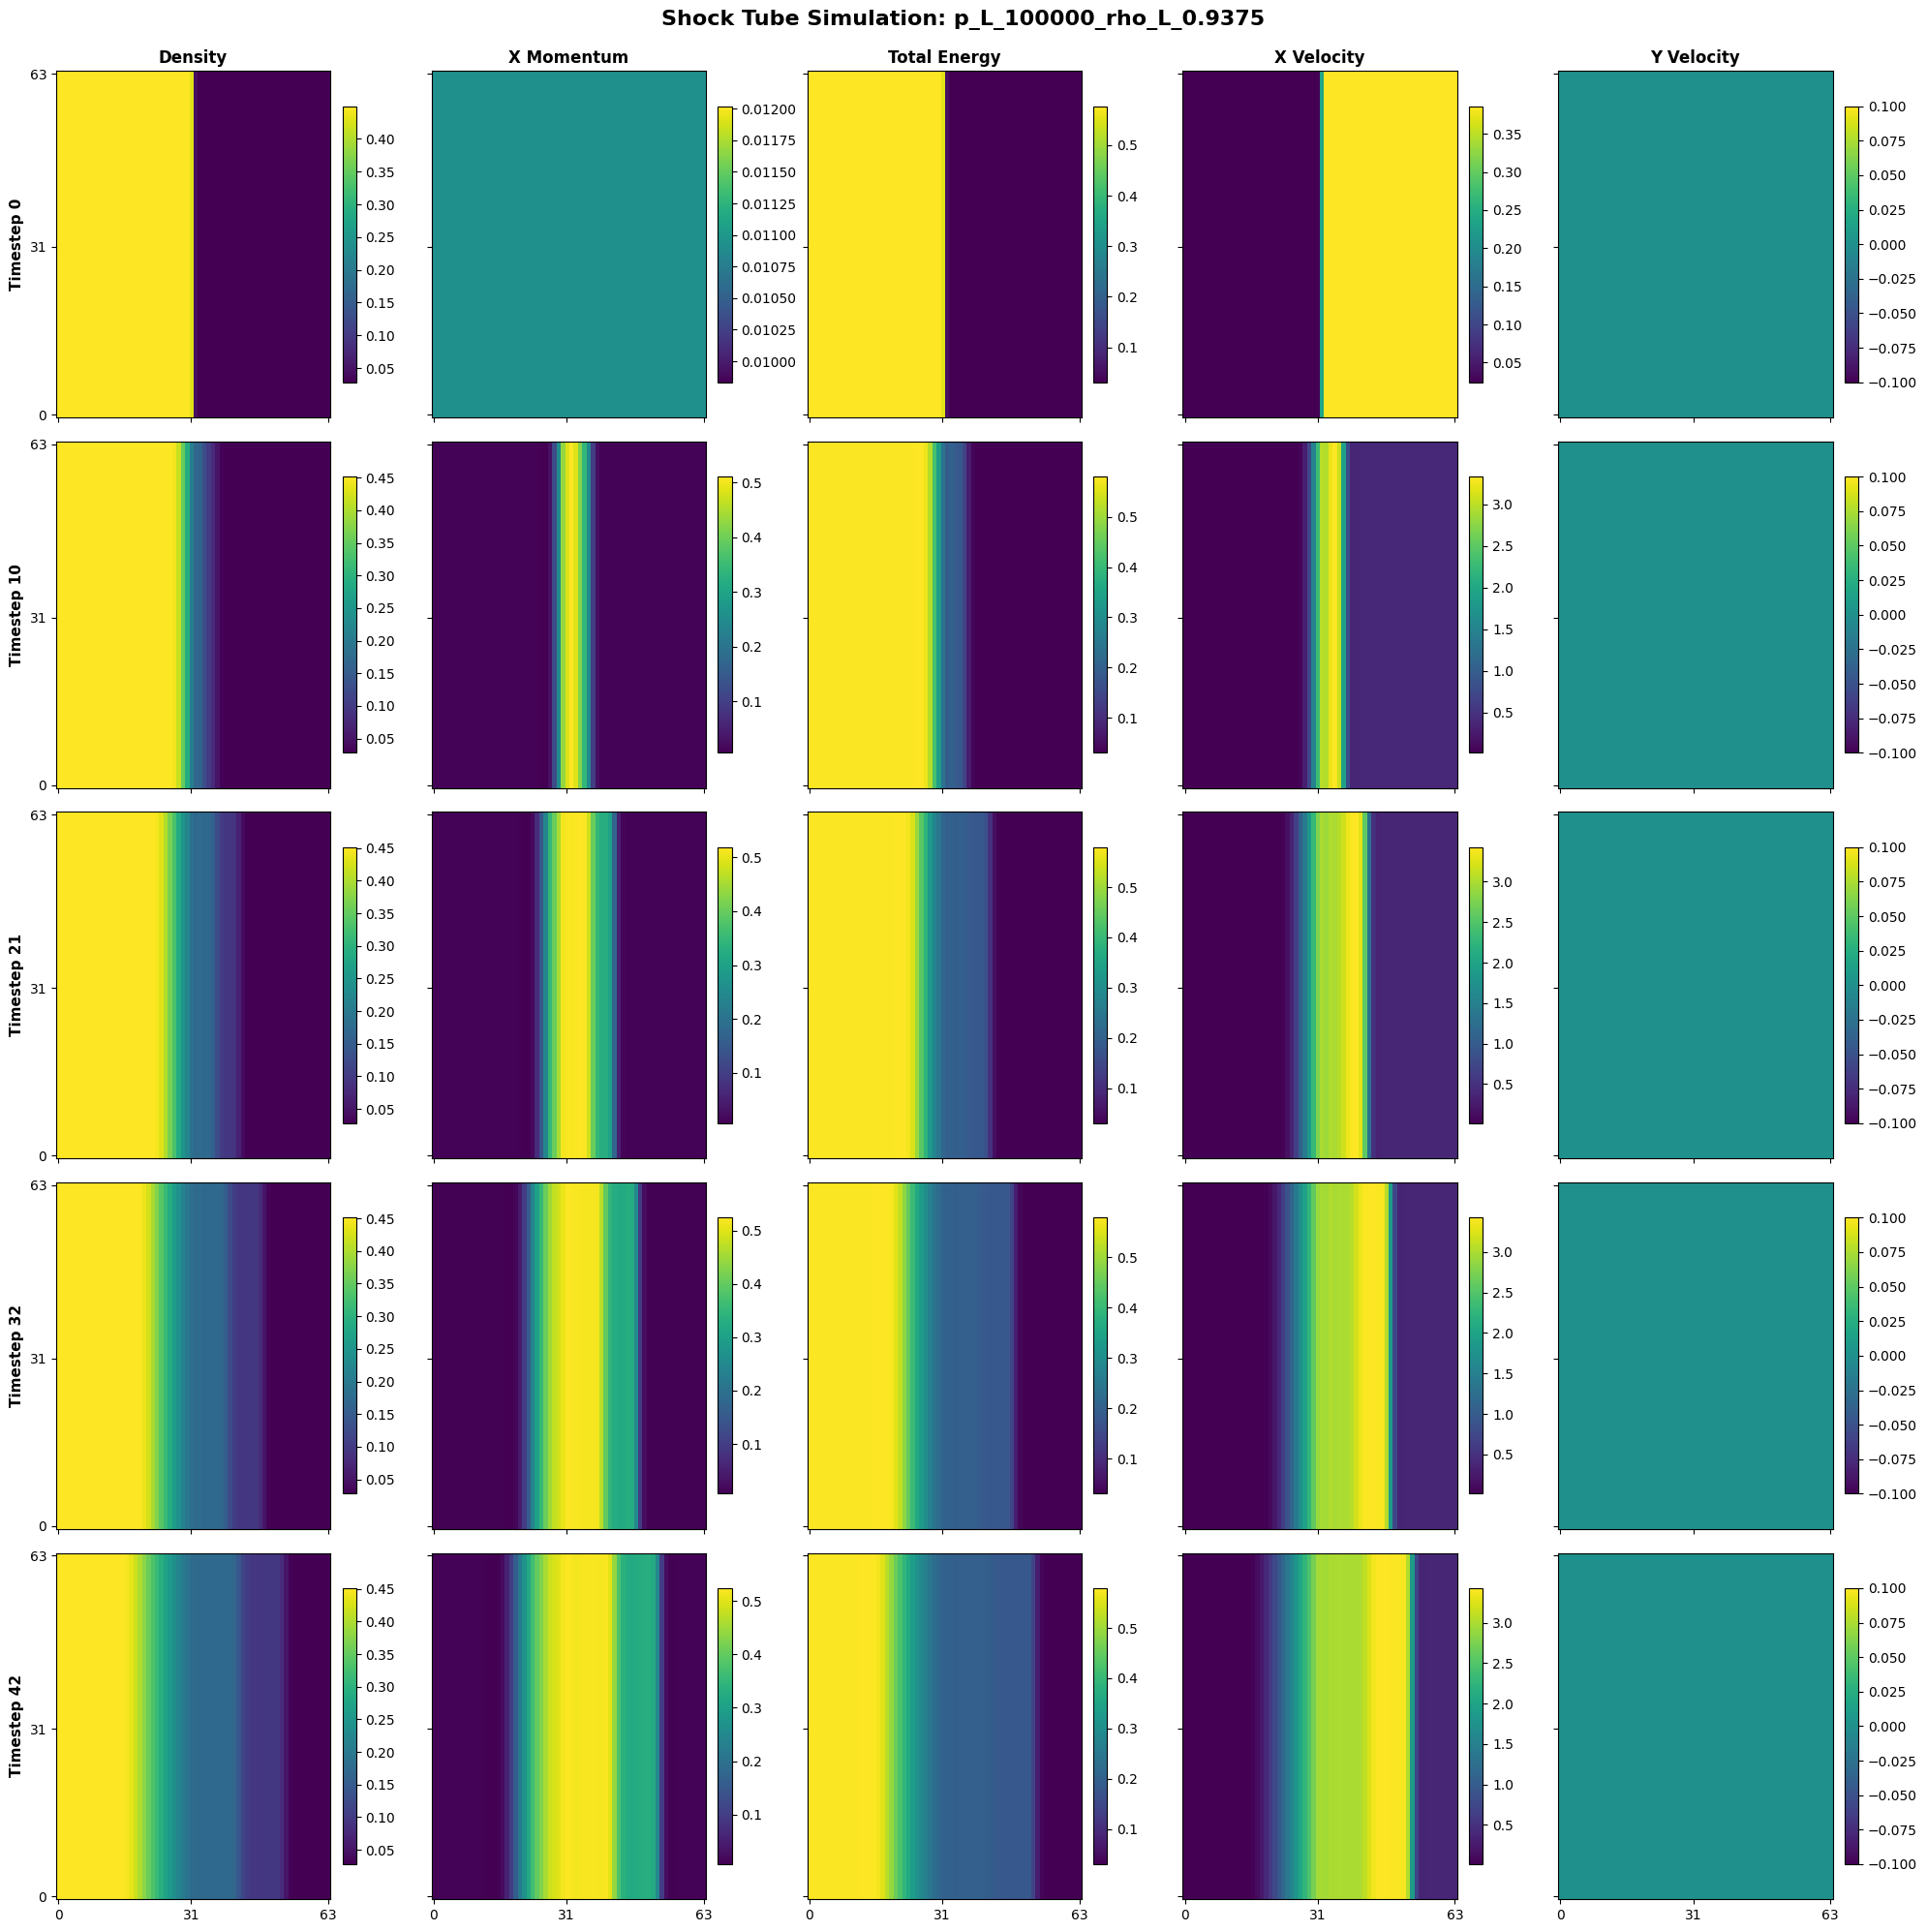


CREATING 1D PROFILES (center line)
✅ Profiles saved as 'shocktube_profiles.png'


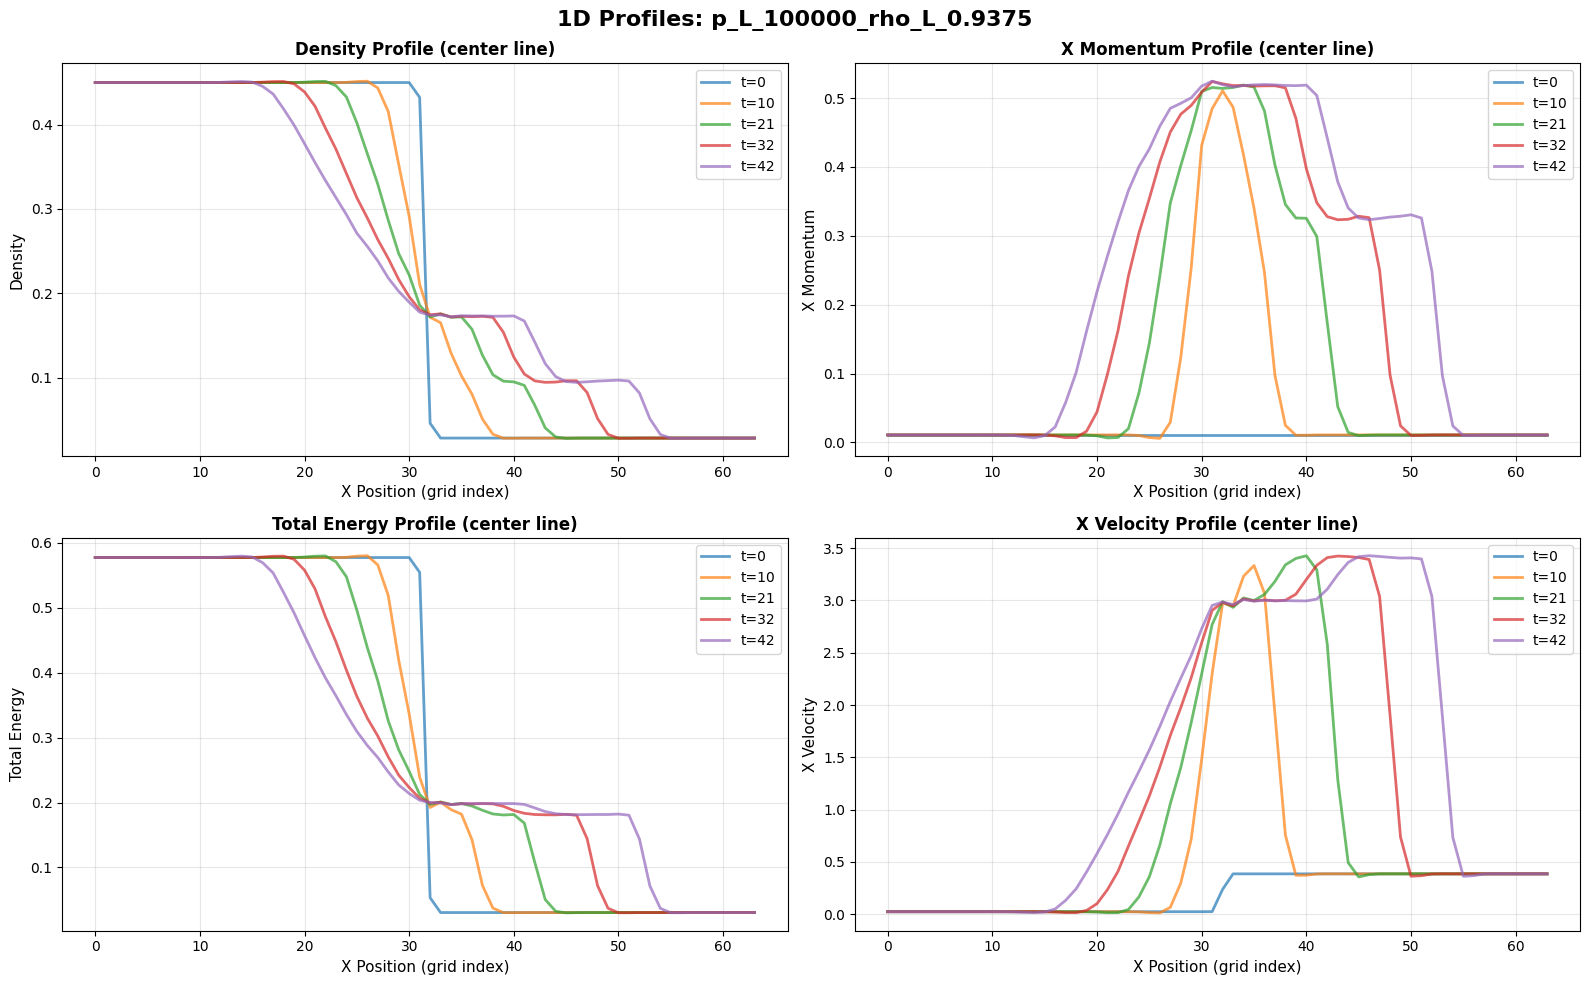


VERIFICATION
Y Velocity channel (should be all zeros): True
  Max absolute value: 0.0

Verifying velocity calculation (x_velocity = x_momentum / density):
  Timestep 0: True
  Timestep 10: True
  Timestep 21: True

VISUALIZATION COMPLETE!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the data
data_file = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/cnn_datasets/train/p_L_100000_rho_L_0.9375.npy"
data = np.load(data_file)

print("="*70)
print("SHOCK TUBE DATA VISUALIZATION")
print("="*70)
print(f"\nFile: {Path(data_file).name}")
print(f"Shape: {data.shape}")
print(f"  Timesteps: {data.shape[0]}")
print(f"  Channels: {data.shape[1]}")
print(f"  Grid size: {data.shape[2]}x{data.shape[3]}")

# Channel names
channel_names = ['Density', 'X Momentum', 'Total Energy', 'X Velocity', 'Y Velocity']

# Print statistics
print("\n" + "="*70)
print("DATA STATISTICS")
print("="*70)
for i, name in enumerate(channel_names):
    print(f"\n{name}:")
    print(f"  Min: {data[:, i, :, :].min():.6f}")
    print(f"  Max: {data[:, i, :, :].max():.6f}")
    print(f"  Mean: {data[:, i, :, :].mean():.6f}")
    print(f"  Std: {data[:, i, :, :].std():.6f}")

# Select timesteps to visualize
num_timesteps = data.shape[0]
if num_timesteps <= 6:
    timesteps_to_plot = list(range(num_timesteps))
else:
    # Plot first, middle, and last few timesteps
    timesteps_to_plot = [0, num_timesteps//4, num_timesteps//2, 3*num_timesteps//4, num_timesteps-1]

print(f"\n" + "="*70)
print(f"VISUALIZING TIMESTEPS: {timesteps_to_plot}")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(len(timesteps_to_plot), 5, figsize=(20, 4*len(timesteps_to_plot)))

if len(timesteps_to_plot) == 1:
    axes = axes.reshape(1, -1)

for row_idx, t in enumerate(timesteps_to_plot):
    for col_idx, channel_name in enumerate(channel_names):
        ax = axes[row_idx, col_idx]
        
        # Get the data for this timestep and channel
        channel_data = data[t, col_idx, :, :]
        
        # Plot
        im = ax.imshow(channel_data, cmap='viridis', aspect='auto', origin='lower')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Set title
        if row_idx == 0:
            ax.set_title(f'{channel_name}', fontsize=12, fontweight='bold')
        
        # Add timestep label on the left
        if col_idx == 0:
            ax.set_ylabel(f'Timestep {t}', fontsize=11, fontweight='bold')
        
        # Remove tick labels for cleaner look
        ax.set_xticks([0, 31, 63])
        ax.set_yticks([0, 31, 63])
        if row_idx < len(timesteps_to_plot) - 1:
            ax.set_xticklabels([])
        if col_idx > 0:
            ax.set_yticklabels([])

plt.suptitle(f'Shock Tube Simulation: {Path(data_file).stem}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('shocktube_visualization.png', dpi=150, bbox_inches='tight')
print("\n✅ Visualization saved as 'shocktube_visualization.png'")
plt.show()

# Create a second figure showing 1D profiles along the center line
print("\n" + "="*70)
print("CREATING 1D PROFILES (center line)")
print("="*70)

fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))
axes2 = axes2.flatten()

# We'll skip Y Velocity since it's all zeros
channels_to_profile = [0, 1, 2, 3]  # Density, X Momentum, Total Energy, X Velocity
profile_names = ['Density', 'X Momentum', 'Total Energy', 'X Velocity']

for idx, (channel_idx, name) in enumerate(zip(channels_to_profile, profile_names)):
    ax = axes2[idx]
    
    # Extract center line (middle row) for each timestep
    center_y = data.shape[2] // 2
    
    for t in timesteps_to_plot:
        profile = data[t, channel_idx, center_y, :]
        ax.plot(profile, label=f't={t}', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('X Position (grid index)', fontsize=11)
    ax.set_ylabel(name, fontsize=11)
    ax.set_title(f'{name} Profile (center line)', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'1D Profiles: {Path(data_file).stem}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('shocktube_profiles.png', dpi=150, bbox_inches='tight')
print("✅ Profiles saved as 'shocktube_profiles.png'")
plt.show()

# Print verification that Y velocity is all zeros
print("\n" + "="*70)
print("VERIFICATION")
print("="*70)
print(f"Y Velocity channel (should be all zeros): {np.allclose(data[:, 4, :, :], 0)}")
print(f"  Max absolute value: {np.abs(data[:, 4, :, :]).max()}")

# Check velocity calculation
print("\nVerifying velocity calculation (x_velocity = x_momentum / density):")
for t in timesteps_to_plot[:3]:  # Check first 3 timesteps
    x_momentum = data[t, 1, :, :]
    density = data[t, 0, :, :]
    x_velocity = data[t, 3, :, :]
    
    expected_velocity = np.divide(x_momentum, density, 
                                  where=density!=0, 
                                  out=np.zeros_like(x_momentum))
    
    is_correct = np.allclose(x_velocity, expected_velocity, rtol=1e-5)
    print(f"  Timestep {t}: {is_correct}")

print("\n" + "="*70)
print("VISUALIZATION COMPLETE!")
print("="*70)